# ML MB model with custom loss function for predicting MB on monthly resolution

Based on tests performed in notebook test_custom_loss.ipynb

In [1]:
# Import libraries
import joblib
import numpy as np
import pandas as pd
import xgboost as xgb
from matplotlib import pyplot as plt
from tqdm import tqdm
from itertools import product
import dill as pickle

from sklearn.model_selection import KFold
from sklearn.model_selection import GroupKFold
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

from plotting_functions import plot_prediction_per_fold
from plotting_functions import plot_prediction
from plotting_functions import plot_gsearch_results

### 0.1 Helper functions

In [2]:
# Functions for data processing

# Reshape dataframe to monthly resolution
def reshape_dataset_monthly(df, id_vars, variables, months_order): 

    df_list = []

    for var in variables:
        # Filter columns for the current variable and the ID columns
        cols = [col for col in df.columns if col.startswith(var) or col in id_vars]
        df_var = df[cols]

        # Rename the columns to have just the month
        df_var = df_var.rename(columns=lambda x: x.split('_')[-1] if x not in id_vars else x)

        # Melt the DataFrame to long format and add month order
        df_melted = pd.melt(df_var, id_vars=id_vars, var_name='month', value_name=var)
        df_melted['month'] = pd.Categorical(df_melted['month'], categories=months_order, ordered=True)

        df_list.append(df_melted)

    # Combine all reshaped DataFrames
    df_final = df_list[0]
    for df_temp in df_list[1:]:
        df_final = pd.merge(df_final, df_temp, on=id_vars + ['month'], how='left')

    # Sort the DataFrame based on ID variables and month
    df_final = df_final.sort_values(by=id_vars + ['month'])

    return(df_final)

In [3]:
# Get mass balance predictions for a given season (winter, summer annual)
def get_prediction_per_season(X_train_s, y_train_s, splits_s, best_model, months=12):
    y_pred_list = []
    y_test_list = []
    i=0

    for train_index, test_index in splits_s:
        # Loops over n_splits iterations and gets train and test splits in each fold
        X_train, X_test = X_train_s[train_index], X_train_s[test_index]
        y_train, y_test = y_train_s[train_index], y_train_s[test_index]
        best_model.fit(X_train, y_train)
        y_pred = best_model.predict(X_test)

        indices = np.argwhere((X_test == months))[:,0]
        y_test_crop = y_test[indices]
        y_pred_crop = y_pred[indices]

        y_test_list.extend(y_test_crop)
        y_pred_list.extend(y_pred_crop)

        i=i+1

    # Arrays of predictions and observations for each fold
    y_test_all = np.hstack([*y_test_list])
    y_pred_all = np.hstack([*y_pred_list])

    return y_test_all, y_pred_all

In [4]:
def get_prediction_per_season_test(X_test, y_test, best_model, months=12):

    y_pred = best_model.predict(X_test)

    indices = np.argwhere((X_test[:,-2] == months))[:,0]
    y_test_crop = y_test[indices]
    y_pred_crop = y_pred[indices]

    return y_test_crop, y_pred_crop

### 0.2 Plotting functions

In [5]:
def plot_prediction_subplot(y1, y2, data_type:str, ax, n_toplot=10**10, fold=False):
    """
    Plot model predictions y1 vs. actual observations y2 and show
    calculated error metrics.

    Parameters:
    y1 : np.array
        Predicted labels.
    y2 : np.array
        Actual labels.
    data_type : str
        Type of data, e.g. "Validation" or "Test".
    ax : array
        Axis object
    n_toplot : int
        Number of points to plot. 
    """
    
    from scipy.stats import gaussian_kde
    from sklearn.metrics import r2_score, mean_squared_error, root_mean_squared_error

    if fold:
        figsize=(5,5)
        fontsize=12
        s= 15
    else:
        figsize=(8,8)
        fontsize=16
        s= 20
    
    idxs = np.arange(len(y1))
    np.random.shuffle(idxs)

    y_max = 8#7 #max(max(y1), max(y2))[0] + 1
    y_min = -15#1 #min(min(y1), min(y2))[0] - 1
    
    y_expected = y1.reshape(-1)[idxs[:n_toplot]]
    y_predicted = y2.reshape(-1)[idxs[:n_toplot]]

    xy = np.vstack([y_expected, y_predicted])
    z = gaussian_kde(xy)(xy)
    # Sort the points by density, so that the densest points are plotted last
    idx = z.argsort()
    y_plt, ann_plt, z = y_expected[idx], y_predicted[idx], z[idx]
    
    #fig = plt.figure(figsize=figsize)
    sc = ax.scatter(y_plt, ann_plt, c=z, s=s)
    sc.set_clim(0,0.2)
    #plt.tick_params(labelsize=14)
    plt.colorbar(sc,ax=ax,fraction=0.046) 
    lineStart = y_min
    lineEnd = y_max
    ax.plot([lineStart, lineEnd], [lineStart, lineEnd], 'k-')
    ax.set_title("Model Evaluation " + data_type, fontsize=fontsize)
    ax.set_ylabel('Modeled SMB (m.w.e)', fontsize=fontsize)
    ax.set_xlabel('Reference SMB (m.w.e)', fontsize=fontsize)
    ax.axvline(0.0, ls='-.', c='k')
    ax.axhline(0.0, ls='-.', c='k')
    ax.set_xlim(lineStart, lineEnd)
    ax.set_ylim(lineStart, lineEnd)
    ax.set_box_aspect(1)
    
    textstr = '\n'.join((
    r'$RMSE=%.2f$' % (root_mean_squared_error(y_expected, y_predicted), ),
    r'$MSE=%.2f$' % (mean_squared_error(y_expected, y_predicted, ), ),
    r'$R^2=%.2f$' % (r2_score(y_expected, y_predicted), )))
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    # place a text box in upper left in axes coords
    ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=14,
            verticalalignment='top', bbox=props)
    
    return ax
    #plt.show()

In [6]:
def plot_prediction_per_season(y_test_all, y_pred_all, season='Annual'):

    from scipy.stats import gaussian_kde
    from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, root_mean_squared_error
    
    figsize=(5,5)
    fontsize=16
    s= 20
    n_toplot=10**10
    
    idxs = np.arange(len(y_test_all))
    np.random.shuffle(idxs)

    y_max = 8#7 #max(max(y1), max(y2))[0] + 1
    y_min = -15#1 #min(min(y1), min(y2))[0] - 1
    
    y_expected = y_test_all.reshape(-1)[idxs[:n_toplot]]
    y_predicted = y_pred_all.reshape(-1)[idxs[:n_toplot]]

    xy = np.vstack([y_expected, y_predicted])
    z = gaussian_kde(xy)(xy)
    # Sort the points by density, so that the densest points are plotted last
    idx = z.argsort()
    y_plt, ann_plt, z = y_expected[idx], y_predicted[idx], z[idx]
    
    fig = plt.figure(figsize=figsize, dpi=100)
    plt.title(season + " mass balance", fontsize=20)
    plt.ylabel('Modeled mass balance (m w.e)', fontsize=fontsize)
    plt.xlabel('Observed mass balance (m w.e)', fontsize=fontsize)
    sc = plt.scatter(y_plt, ann_plt, c=z, s=s)
    plt.clim(0,0.4)
    plt.tick_params(labelsize=14)
    #plt.colorbar(sc) 
    lineStart = y_min
    lineEnd = y_max
    plt.plot([lineStart, lineEnd], [lineStart, lineEnd], 'k-')
    plt.axvline(0.0, ls='-.', c='k')
    plt.axhline(0.0, ls='-.', c='k')
    plt.xlim(lineStart, lineEnd)
    plt.ylim(lineStart, lineEnd)
    plt.gca().set_box_aspect(1)
    
    textstr = '\n'.join((
    r'$RMSE=%.2f$' % (root_mean_squared_error(y_expected, y_predicted), ),
    r'$MSE=%.2f$' % (mean_squared_error(y_expected, y_predicted, ), ),
    r'$MAE=%.2f$' % (mean_absolute_error(y_expected, y_predicted), ),
    r'$R^2=%.2f$' % (r2_score(y_expected, y_predicted), )))
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    # place a text box in upper left in axes coords
    plt.text(0.05, 0.95, textstr, transform=plt.gca().transAxes, fontsize=14,
            verticalalignment='top', bbox=props)

    plt.tight_layout()
    plt.show()

## 1 Prepare training and test data

In [7]:
# Specify filepaths and filenames.          
loc = 'local'

if loc == 'cryocloud':
    filepath = '/home/jovyan/ML_MB_Norway_data/'
elif loc == 'local':
    filepath = 'Data/'

filename = '2023-08-28_stake_mb_norway_cleaned_ids_latlon_wattributes_climate.csv'

# Load data.
data = pd.read_csv(filepath + filename)

# Add year column
data['year']=pd.to_datetime(data['dt_curr_year_max_date'].astype('string'), format="%d.%m.%Y %H:%M")
data['year'] = data.year.dt.year.astype('Int64')

# Remove cells with nan in balance_netto.
glacier_data_annual = data[data['balance_netto'].notna()]
glacier_data_annual.reset_index(drop=True, inplace=True)

glacier_data_winter = data[data['balance_winter'].notna()]
glacier_data_winter.reset_index(drop=True, inplace=True)

glacier_data_summer = data[data['balance_summer'].notna()]
glacier_data_summer.reset_index(drop=True, inplace=True)

C:\Users\kasj\AppData\Local\Temp\ipykernel_19192\398696404.py:12: DtypeWarning: Columns (20) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(filepath + filename)


In [8]:
test_glaciers = [54, 703, 941, 1135, 1280, 2085, 2320, 2478, 2768, 2769, 3133, 3137, 3138, 3141]

# Get test dataset for each of annual, winter and summer mass balance
df_test_annual = glacier_data_annual[glacier_data_annual['BREID'].isin(test_glaciers)]
df_test_winter = glacier_data_winter[glacier_data_winter['BREID'].isin(test_glaciers)]
df_test_summer = glacier_data_summer[glacier_data_summer['BREID'].isin(test_glaciers)]
# 54 has 189 points
# 703 has 30 points
# 941 has 70 points
# 1280 has 71 points
# 2320 has 83 points
# 2478 has 89 points
# 2769 has 121 points
# 3133 has 38 points
# 3137 has 65 points
# 3138 has 6 points
# 3141 has 72 points

# Get training dataset for each of annual, winter and summer mass balance
df_train_annual = glacier_data_annual[~glacier_data_annual['BREID'].isin(test_glaciers)]
df_train_winter = glacier_data_winter[~glacier_data_winter['BREID'].isin(test_glaciers)]
df_train_summer = glacier_data_summer[~glacier_data_summer['BREID'].isin(test_glaciers)]

# Add number of months to each dataframe
df_train_annual['n_months']=12
df_train_winter['n_months']=7
df_train_summer['n_months']=5
df_test_annual['n_months']=12
df_test_winter['n_months']=7
df_test_summer['n_months']=5

print(f'Train/test annual: {len(df_train_annual)}/{len(df_test_annual)}')
print(f'Train/test winter: {len(df_train_winter)}/{len(df_test_winter)}')
print(f'Train/test summer: {len(df_train_summer)}/{len(df_test_summer)}')
print(f'All train/test: {len(df_train_annual)+len(df_train_winter)+len(df_train_summer)} / {len(df_test_annual)+len(df_test_winter)+len(df_test_summer)}')
print(f'Fraction train/test: {(len(df_train_annual)+len(df_train_winter)+len(df_train_summer)) / (len(df_test_annual)+len(df_test_winter)+len(df_test_summer)+len(df_train_annual)+len(df_train_winter)+len(df_train_summer))} / {(len(df_test_annual)+len(df_test_winter)+len(df_test_summer)) /(len(df_test_annual)+len(df_test_winter)+len(df_test_summer) + len(df_train_annual)+len(df_train_winter)+len(df_train_summer))}')
print(f'Total entries: {len(df_test_annual)+len(df_test_winter)+len(df_test_summer) + len(df_train_annual)+len(df_train_winter)+len(df_train_summer)}')


Train/test annual: 2845/1065
Train/test winter: 2752/1000
Train/test summer: 2901/1028
All train/test: 8498 / 3093
Fraction train/test: 0.7331550340781641 / 0.26684496592183593
Total entries: 11591


C:\Users\kasj\AppData\Local\Temp\ipykernel_19192\1542360467.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_annual['n_months']=12
C:\Users\kasj\AppData\Local\Temp\ipykernel_19192\1542360467.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_winter['n_months']=7
C:\Users\kasj\AppData\Local\Temp\ipykernel_19192\1542360467.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the c

In [9]:
df_test_annual

RGIID         GLIMSID  BREID  utm_zone  utm_east_approx  \
0     RGI60-08.01258  G021737E70130N     54        34         529400.0   
1     RGI60-08.01258  G021737E70130N     54        34         529400.0   
2     RGI60-08.01258  G021737E70130N     54        34         529400.0   
3     RGI60-08.01258  G021737E70130N     54        34         529400.0   
4     RGI60-08.01258  G021737E70130N     54        34         529400.0   
...              ...             ...    ...       ...              ...   
3905  RGI60-08.02969  G006362E59989N   3141        32         351800.0   
3906  RGI60-08.02969  G006362E59989N   3141        32         351800.0   
3907  RGI60-08.02969  G006362E59989N   3141        32         351800.0   
3908  RGI60-08.02969  G006362E59989N   3141        32         351800.0   
3909  RGI60-08.02969  G006362E59989N   3141        32         351800.0   

      utm_north_approx  altitude_approx location_description location_id  \
0            7780050.0            500.0  Nederst på bretunga         L10   
1            7780050.0            500.0  Nederst på bretunga         L10   
2            7780050.0            500.0  Nederst på bretunga         L10   
3            7780050.0            500.0  Nederst på bretunga         L10   
4            7780050.0            500.0  Nederst på bretunga         L10   
...                ...              ...                  ...         ...   
3905         6647500.0           1080.0  Nederst på bretunga         B15   
3906         6647500.0           1080.0  Nederst på bretunga         B15   
3907         6647500.0           1080.0  Nederst på bretunga         B15   
3908         6647500.0           1080.0  Nederst på bretunga         B15   
3909         6647500.0           1080.0  Nederst på bretunga         B15   

     stake_no  ...    tp_mar    tp_apr    tp_may    tp_jun    tp_jul  \
0       L1012  ...  0.002688  0.002334  0.001159  0.003054  0.003977   
1       L1013  ...  0.004597  0.005634  0.002244  0.003412  0.000891   
2       L1013  ...  0.003286  0.003739  0.004709  0.005111  0.001253   
3       L1013  ...  0.002263  0.001256  0.002129  0.003969  0.003559   
4       L1016  ...  0.004417  0.002704  0.003991  0.001780  0.004257   
...       ...  ...       ...       ...       ...       ...       ...   
3905    B1509  ...  0.007288  0.003555  0.005019  0.004730  0.007226   
3906    B1509  ...  0.000807  0.009360  0.006135  0.006760  0.005158   
3907    B1514  ...  0.010311  0.006261  0.008175  0.005974  0.006563   
3908    B1514  ...  0.003751  0.004573  0.004449  0.005235  0.008926   
3909    B1514  ...  0.009703  0.007457  0.003567  0.008162  0.007537   

        tp_aug    tp_sep altitude_climate  year n_months  
0     0.004691  0.001449       341.227919  2013       12  
1     0.002129  0.004860       341.227919  2014       12  
2     0.002506  0.003256       341.227919  2015       12  
3     0.002119  0.002851       341.227919  2016       12  
4     0.005193  0.000710       341.227919  2017       12  
...        ...       ...              ...   ...      ...  
3905  0.005739  0.011397       917.419759  2012       12  
3906  0.008218  0.005461       917.419759  2013       12  
3907  0.008015  0.003896       917.419759  2015       12  
3908  0.011151  0.009556       917.419759  2016       12  
3909  0.007390  0.006440       917.419759  2017       12  

[1065 rows x 303 columns]

### 1.1 Prepare training data

In [10]:
# Select columns to drop
cols = ['RGIID','GLIMSID','utm_zone','utm_east_approx','utm_north_approx','altitude_approx',
        'location_description','location_id','stake_no','utm_east','utm_north','dt_prev_year_min_date','dt_curr_year_max_date',
        'dt_curr_year_min_date','stake_remark','flag_correction','approx_loc','approx_altitude',
        'diff_north','diff_east','diff_altitude','diff_netto','lat_approx','lon_approx',
        'topo','dis_from_border', 'lat','lon', 'slope_factor']

snow_depth_m = ['sde_oct','sde_nov','sde_dec','sde_jan','sde_feb','sde_mar','sde_apr','sde_may','sde_jun','sde_jul','sde_aug','sde_sep']
snow_density = ['rsn_oct','rsn_nov','rsn_dec','rsn_jan','rsn_feb','rsn_mar','rsn_apr','rsn_may','rsn_jun','rsn_jul','rsn_aug','rsn_sep']
evaporation = ['es_oct','es_nov','es_dec','es_jan','es_feb','es_mar','es_apr','es_may','es_jun','es_jul','es_aug','es_sep']
snow_cover = ['snowc_oct','snowc_nov','snowc_dec','snowc_jan','snowc_feb','snowc_mar','snowc_apr','snowc_may','snowc_jun','snowc_jul','snowc_aug','snowc_sep']
snow_depth_we = ['sd_oct','sd_nov','sd_dec','sd_jan','sd_feb','sd_mar','sd_apr','sd_may','sd_jun','sd_jul','sd_aug','sd_sep']
snow_temp = ['tsn_oct','tsn_nov','tsn_dec','tsn_jan','tsn_feb','tsn_mar','tsn_apr','tsn_may','tsn_jun','tsn_jul','tsn_aug','tsn_sep']
snow_melt = ['smlt_oct','smlt_nov','smlt_dec','smlt_jan','smlt_feb','smlt_mar','smlt_apr','smlt_may','smlt_jun','smlt_jul','smlt_aug','smlt_sep']
snowfall = ['sf_oct','sf_nov','sf_dec','sf_jan','sf_feb','sf_mar','sf_apr','sf_may','sf_jun','sf_jul','sf_aug','sf_sep']
snow_albedo = ['asn_oct','asn_nov','asn_dec','asn_jan','asn_feb','asn_mar','asn_apr','asn_may','asn_jun','asn_jul','asn_aug','asn_sep']
dewpt_temp = ['d2m_oct','d2m_nov','d2m_dec','d2m_jan','d2m_feb','d2m_mar','d2m_apr','d2m_may','d2m_jun','d2m_jul','d2m_aug','d2m_sep']
surface_pressure = ['sp_oct','sp_nov','sp_dec','sp_jan','sp_feb','sp_mar','sp_apr','sp_may','sp_jun','sp_jul','sp_aug','sp_sep']
sol_rad_net = ['ssr_oct','ssr_nov','ssr_dec','ssr_jan','ssr_feb','ssr_mar','ssr_apr','ssr_may','ssr_jun','ssr_jul','ssr_aug','ssr_sep']
sol_therm_down = ['strd_oct','strd_nov','strd_dec','strd_jan','strd_feb','strd_mar','strd_apr','strd_may','strd_jun','strd_jul','strd_aug','strd_sep']
sol_rad_down = ['ssrd_oct','ssrd_nov','ssrd_dec','ssrd_jan','ssrd_feb','ssrd_mar','ssrd_apr','ssrd_may','ssrd_jun','ssrd_jul','ssrd_aug','ssrd_sep']
u_wind = ['u10_oct','u10_nov','u10_dec','u10_jan','u10_feb','u10_mar','u10_apr','u10_may','u10_jun','u10_jul','u10_aug','u10_sep']
v_wind = ['v10_oct','v10_nov','v10_dec','v10_jan','v10_feb','v10_mar','v10_apr','v10_may','v10_jun','v10_jul','v10_aug','v10_sep']
f_albedo = ['fal_oct','fal_nov','fal_dec','fal_jan','fal_feb','fal_mar','fal_apr','fal_may','fal_jun','fal_jul','fal_aug','fal_sep']

drop_cols = [y for x in [cols, snow_depth_m, snow_density, evaporation, snow_cover, snow_depth_we, snow_temp, snow_melt, snowfall, snow_albedo, 
                         dewpt_temp, surface_pressure, sol_rad_net, sol_therm_down, u_wind, v_wind] for y in x]
#drop_cols = [y for x in [cols, snow_depth_m, snow_density, evaporation, snow_cover, snow_depth_we, snow_temp, snow_melt, snowfall, snow_albedo, 
#                         dewpt_temp, surface_pressure, sol_rad_down, sol_therm_down, u_wind, v_wind, f_albedo] for y in x]

# Select features for training
df_train_annual_clean = df_train_annual.drop(drop_cols, axis=1)
df_train_winter_clean = df_train_winter.drop(drop_cols, axis=1)
df_train_summer_clean = df_train_summer.drop(drop_cols, axis=1)
df_train_annual_clean = df_train_annual_clean.drop(['balance_winter','balance_summer'], axis=1)
df_train_winter_clean = df_train_winter_clean.drop(['balance_netto', 'balance_summer'], axis=1)
df_train_summer_clean = df_train_summer_clean.drop(['balance_netto', 'balance_winter'], axis=1)

# Rename target columns to same name
df_train_annual_clean.rename(columns={'balance_netto' : 'balance'}, inplace=True)
df_train_winter_clean.rename(columns={'balance_winter' : 'balance'}, inplace=True)
df_train_summer_clean.rename(columns={'balance_summer' : 'balance'}, inplace=True)

# df_train_X_... now contains columns of all chosen features and column with annual, winter or summer balance

# For summer balance, replace column values in accumulation months with NaN (oct, nov, dec, jan, feb, mar, apr, may)
# For winter balance, replace column values in ablation months with NaN (may, jun, jul, aug, sep, oct)
var = ['t2m', 'sshf', 'slhf', 'ssrd', 'fal','str', 'tp']
#var = ['t2m', 'sshf', 'slhf', 'ssr','str', 'tp']
mon_summer = ['may', 'jun', 'jul', 'aug', 'sep']
mon_winter = ['oct', 'nov', 'dec', 'jan', 'feb', 'mar', 'apr']#,'may']

for name in var:
    for mon in mon_summer:
        if mon not in mon_winter:
            df_train_winter_clean[name+'_'+mon]= np.nan
for name in var:   
    for mon in mon_winter:
        if mon not in mon_summer:
            df_train_summer_clean[name+'_'+mon]= np.nan

# Combine all annual, winter and summer data in one dataframe
#df_train_all = pd.concat([df_train_annual_clean, df_train_summer_clean, df_train_winter_clean])

# Use altitude_diff instead of altitude and altitude_climate
df_train_summer_clean['altitude_diff'] = df_train_summer_clean['altitude_climate']-df_train_summer_clean['altitude']
df_train_winter_clean['altitude_diff'] = df_train_winter_clean['altitude_climate']-df_train_winter_clean['altitude']
df_train_annual_clean['altitude_diff'] = df_train_annual_clean['altitude_climate']-df_train_annual_clean['altitude']

df_train_summer_clean = df_train_summer_clean.drop(['altitude','altitude_climate'], axis=1)
df_train_winter_clean = df_train_winter_clean.drop(['altitude','altitude_climate'], axis=1)
df_train_annual_clean = df_train_annual_clean.drop(['altitude','altitude_climate'], axis=1)

df_train_summer_clean = df_train_summer_clean.dropna(axis=1, how='all')
df_train_winter_clean = df_train_winter_clean.dropna(axis=1, how='all')
df_train_annual_clean = df_train_annual_clean.dropna(axis=1, how='all')

n_summer = len(df_train_summer_clean)
n_winter = len(df_train_winter_clean)
n_annual = len(df_train_annual_clean)

df_train_summer_clean.insert(0, 'id', list(range(n_summer)))
df_train_winter_clean.insert(0, 'id', list(range(n_summer, n_summer+n_winter)))
df_train_annual_clean.insert(0, 'id', list(range(n_summer+n_winter, n_summer+n_winter+n_annual)))

# Columns that are not monthly climate variables (identifiers and static variables)
#id_vars = ['id','BREID', 'year', 'altitude','balance','aspect','slope','altitude_climate','n_months']
id_vars = ['id','BREID', 'year', 'altitude_diff','balance','aspect','slope','n_months']
#id_vars = ['id','BREID', 'year', 'altitude_diff','balance','aspect','slope','cidx','n_months']

# Extract the unique variable names and month names from the column names
#variables = set(col.split('_')[0] for col in df.columns if col not in id_vars)
#months = set(col.split('_')[-1] for col in df.columns if col not in id_vars)
variables = ['t2m', 'sshf', 'slhf', 'ssrd', 'fal','str', 'tp']
#variables = ['t2m', 'sshf', 'slhf', 'ssr','str', 'tp']
#variables = ['t2m', 'tp']

summer_months_order = ['may', 'jun', 'jul', 'aug', 'sep']
winter_months_order = ['oct','nov','dec','jan','feb','mar','apr']#,'may']
annual_months_order = ['oct','nov','dec','jan','feb','mar','apr', 'may', 'jun', 'jul', 'aug', 'sep']

# Reshape dataframes to monthly resolution
df_train_summer_final = reshape_dataset_monthly(df_train_summer_clean, id_vars, variables, summer_months_order)
df_train_winter_final = reshape_dataset_monthly(df_train_winter_clean, id_vars, variables, winter_months_order)
df_train_annual_final = reshape_dataset_monthly(df_train_annual_clean, id_vars, variables, annual_months_order)

# Combine training data in one dataframe
df_train_summer_final.reset_index(drop=True, inplace=True)
df_train_winter_final.reset_index(drop=True, inplace=True)
df_train_annual_final.reset_index(drop=True, inplace=True)

data_list = [df_train_summer_final, df_train_winter_final, df_train_annual_final]
df_train_final = pd.concat(data_list)
df_train_final

id  BREID  year  altitude_diff  balance    aspect     slope  \
0         0    596  1963      11.181943    -3.41  2.509464  0.238202   
1         0    596  1963      11.181943    -3.41  2.509464  0.238202   
2         0    596  1963      11.181943    -3.41  2.509464  0.238202   
3         0    596  1963      11.181943    -3.41  2.509464  0.238202   
4         0    596  1963      11.181943    -3.41  2.509464  0.238202   
...     ...    ...   ...            ...      ...       ...       ...   
34135  8497   3129  1967    -592.166788     1.58  2.526225  0.068208   
34136  8497   3129  1967    -592.166788     1.58  2.526225  0.068208   
34137  8497   3129  1967    -592.166788     1.58  2.526225  0.068208   
34138  8497   3129  1967    -592.166788     1.58  2.526225  0.068208   
34139  8497   3129  1967    -592.166788     1.58  2.526225  0.068208   

       n_months month         t2m          sshf       slhf        ssrd  \
0             5   may  274.658875  1.493194e+04  -375995.0  18766128.0   
1             5   jun  274.336243 -1.636112e+05  -521774.5  21166500.0   
2             5   jul  277.882172 -1.717710e+06 -2857569.5  15175713.0   
3             5   aug  281.432678 -1.826724e+06 -3644167.5  11799862.0   
4             5   sep  276.588593 -4.764911e+05 -1239184.5   6023235.0   
...         ...   ...         ...           ...        ...         ...   
34135        12   may  274.327118 -9.279995e+05  -247320.5  17505508.0   
34136        12   jun  277.050171 -8.421614e+05   101172.0  20268490.0   
34137        12   jul  278.294403 -4.923712e+05   282694.5  15490057.0   
34138        12   aug  280.939240 -1.117702e+06 -2140415.0  12475600.0   
34139        12   sep  280.146698 -9.786440e+05 -2591796.0   8269476.0   

            fal         str        tp  
0      0.596335 -2832247.00  0.001702  
1      0.613368 -2748427.50  0.001953  
2      0.282537 -3019285.50  0.004025  
3      0.123184 -4122848.50  0.002591  
4      0.295263 -2144487.50  0.006047  
...         ...         ...       ...  
34135  0.618479 -2179443.00  0.004908  
34136  0.551025 -2504472.50  0.007480  
34137  0.481296  -862670.75  0.006605  
34138  0.284415 -2001555.00  0.006391  
34139  0.119172 -3330040.00  0.005946  

[67909 rows x 16 columns]

In [11]:
df_train_final.reset_index(drop=True, inplace=True)

In [12]:
# add sshf and sslf variables
#df_train_final['sthf'] = df_train_final['sshf']+df_train_final['slhf']
#df_train_final = df_train_final.drop(columns=['sshf','slhf'])
#df_train_final

In [13]:
#df_train_final.to_csv('Data/old_data/' + 'dataset_norway_monthly.csv', index=None)

In [14]:
df_train_final.isna().sum()

id               0
BREID            0
year             0
altitude_diff    0
balance          0
aspect           0
slope            0
n_months         0
month            0
t2m              0
sshf             0
slhf             0
ssrd             0
fal              0
str              0
tp               0
dtype: int64

### 1.2 Prepare test data

In [15]:
# Prepare test

# Cols to drop for test
# DOES NOT INCLUDE RGIID BECAUSE THIS IS NEEDED FOR MODEL COMPARISON
cols_test = ['GLIMSID','utm_zone','utm_east_approx','utm_north_approx','altitude_approx',
        'location_description','location_id','stake_no','utm_east','utm_north','dt_prev_year_min_date','dt_curr_year_max_date',
        'dt_curr_year_min_date','stake_remark','flag_correction','approx_loc','approx_altitude',
        'diff_north','diff_east','diff_altitude','diff_netto','lat_approx','lon_approx',
        'topo','dis_from_border', 'lat','lon', 'slope_factor']
drop_cols_test = [y for x in [cols_test, snow_depth_m, snow_density, evaporation, snow_cover, snow_depth_we, snow_temp, snow_melt, snowfall, snow_albedo, 
                         dewpt_temp, surface_pressure, sol_rad_net, sol_therm_down, u_wind, v_wind] for y in x]
#drop_cols_test = [y for x in [cols_test, snow_depth_m, snow_density, evaporation, snow_cover, snow_depth_we, snow_temp, snow_melt, snowfall, snow_albedo, 
#                         dewpt_temp, surface_pressure, sol_rad_down, sol_therm_down, u_wind, v_wind, f_albedo] for y in x]

# Select features for training
df_test_annual_clean = df_test_annual.drop(drop_cols_test, axis=1)
df_test_winter_clean = df_test_winter.drop(drop_cols_test, axis=1)
df_test_summer_clean = df_test_summer.drop(drop_cols_test, axis=1)
df_test_annual_clean = df_test_annual_clean.drop(['balance_winter','balance_summer'], axis=1)
df_test_winter_clean = df_test_winter_clean.drop(['balance_netto', 'balance_summer'], axis=1)
df_test_summer_clean = df_test_summer_clean.drop(['balance_netto', 'balance_winter'], axis=1)

# Rename target columns to same name
df_test_annual_clean.rename(columns={'balance_netto' : 'balance'}, inplace=True)
df_test_winter_clean.rename(columns={'balance_winter' : 'balance'}, inplace=True)
df_test_summer_clean.rename(columns={'balance_summer' : 'balance'}, inplace=True)

# For summer balance, replace column values in accumulation months with NaN (oct, nov, dec, jan, feb, mar, apr, may)
# For winter balance, replace column values in ablation months with NaN (may, jun, jul, aug, sep, oct)
#var = ['t2m', 'sshf', 'slhf', 'ssrd', 'fal','str', 'tp']
#mon_summer = ['may', 'jun', 'jul', 'aug', 'sep']
#mon_winter = ['oct', 'nov', 'dec', 'jan', 'feb', 'mar', 'apr', 'may']

# INCLUDES RGIID BECAUSE THIS IS NEEDED FOR MODEL COMPARISON
id_vars_test = ['id','BREID', 'RGIID', 'year', 'altitude_diff','altitude','altitude_climate','balance','aspect','slope','n_months']
#id_vars_test = ['id','BREID', 'RGIID', 'year', 'altitude_diff','altitude','altitude_climate','balance','aspect','slope','cidx','n_months']

for name in var:
    for mon in mon_summer:
        if mon not in mon_winter:
            df_test_winter_clean[name+'_'+mon]= np.nan
for name in var:   
    for mon in mon_winter:
        if mon not in mon_summer:
            df_test_summer_clean[name+'_'+mon]= np.nan

# Combine all annual, winter and summer data in one dataframe
#df_test_all = pd.concat([df_test_annual_clean, df_test_summer_clean, df_test_winter_clean])
#df_test_all.reset_index(drop=True, inplace=True)

# Use altitude_diff instead of altitude and altitude_climate
# DO NOT DROP ALTITUDE AND ALTITUDE CLIMATE, NEEDED IN SAVED DATASET
df_test_summer_clean['altitude_diff'] = df_test_summer_clean['altitude_climate']-df_test_summer_clean['altitude']
#df_test_summer_clean = df_test_summer_clean.drop(['altitude','altitude_climate'], axis=1)
df_test_winter_clean['altitude_diff'] = df_test_winter_clean['altitude_climate']-df_test_winter_clean['altitude']
#df_test_winter_clean = df_test_winter_clean.drop(['altitude','altitude_climate'], axis=1)
df_test_annual_clean['altitude_diff'] = df_test_annual_clean['altitude_climate']-df_test_annual_clean['altitude']
#df_test_annual_clean = df_test_annual_clean.drop(['altitude','altitude_climate'], axis=1)

df_test_summer_clean = df_test_summer_clean.dropna(axis=1, how='all')
df_test_winter_clean = df_test_winter_clean.dropna(axis=1, how='all')
df_test_annual_clean = df_test_annual_clean.dropna(axis=1, how='all')

n_summer = len(df_test_summer_clean)
n_winter = len(df_test_winter_clean)
n_annual = len(df_test_annual_clean)

df_test_summer_clean.insert(0, 'id', list(range(n_summer)))
df_test_winter_clean.insert(0, 'id', list(range(n_summer, n_summer+n_winter)))
df_test_annual_clean.insert(0, 'id', list(range(n_summer+n_winter, n_summer+n_winter+n_annual)))

# Columns that are not monthly climate variables (identifiers and static variables)
#id_vars = ['id','BREID', 'year', 'altitude','balance','aspect','slope','altitude_climate','n_months']

# Extract the unique variable names and month names from the column names
#variables = set(col.split('_')[0] for col in df.columns if col not in id_vars)
#months = set(col.split('_')[-1] for col in df.columns if col not in id_vars)
#variables = ['t2m', 'sshf', 'slhf', 'ssrd', 'fal','str', 'tp']
#summer_months_order = ['may', 'jun', 'jul', 'aug', 'sep']
#winter_months_order = ['oct','nov','dec','jan','feb','mar','apr']
#annual_months_order = ['oct','nov','dec','jan','feb','mar','apr', 'may', 'jun', 'jul', 'aug', 'sep']

# Reshape datasets to monthly resolution
df_test_summer_final = reshape_dataset_monthly(df_test_summer_clean, id_vars_test, variables, summer_months_order)
df_test_winter_final = reshape_dataset_monthly(df_test_winter_clean, id_vars_test, variables, winter_months_order)
df_test_annual_final = reshape_dataset_monthly(df_test_annual_clean, id_vars_test, variables, annual_months_order)

# Combine training data in one dataframe
df_test_summer_final.reset_index(drop=True, inplace=True)
df_test_winter_final.reset_index(drop=True, inplace=True)
df_test_annual_final.reset_index(drop=True, inplace=True)

data_list = [df_test_summer_final, df_test_winter_final, df_test_annual_final]
df_test_final = pd.concat(data_list)
df_test_final

id  BREID           RGIID  year  altitude_diff  altitude  \
0         0     54  RGI60-08.01258  2013    -129.772081     471.0   
1         0     54  RGI60-08.01258  2013    -129.772081     471.0   
2         0     54  RGI60-08.01258  2013    -129.772081     471.0   
3         0     54  RGI60-08.01258  2013    -129.772081     471.0   
4         0     54  RGI60-08.01258  2013    -129.772081     471.0   
...     ...    ...             ...   ...            ...       ...   
12775  3092   3141  RGI60-08.02969  2017    -160.580241    1078.0   
12776  3092   3141  RGI60-08.02969  2017    -160.580241    1078.0   
12777  3092   3141  RGI60-08.02969  2017    -160.580241    1078.0   
12778  3092   3141  RGI60-08.02969  2017    -160.580241    1078.0   
12779  3092   3141  RGI60-08.02969  2017    -160.580241    1078.0   

       altitude_climate  balance    aspect     slope  n_months month  \
0            341.227919    -6.24  0.629597  0.278773         5   may   
1            341.227919    -6.24  0.629597  0.278773         5   jun   
2            341.227919    -6.24  0.629597  0.278773         5   jul   
3            341.227919    -6.24  0.629597  0.278773         5   aug   
4            341.227919    -6.24  0.629597  0.278773         5   sep   
...                 ...      ...       ...       ...       ...   ...   
12775        917.419759    -3.29  2.906044  0.131717        12   may   
12776        917.419759    -3.29  2.906044  0.131717        12   jun   
12777        917.419759    -3.29  2.906044  0.131717        12   jul   
12778        917.419759    -3.29  2.906044  0.131717        12   aug   
12779        917.419759    -3.29  2.906044  0.131717        12   sep   

              t2m          sshf       slhf        ssrd       fal         str  \
0      277.677979  4.286715e+05  -237874.5  20979516.0  0.580414 -3367191.50   
1      283.339630 -2.133166e+06 -4024573.5  17728592.0  0.198752 -3994740.00   
2      283.829285 -2.731458e+06 -5184939.5  15538729.0  0.131911 -4661453.00   
3      283.778412 -1.295387e+06 -3545874.5  10510849.0  0.130799 -4018348.50   
4      280.982513  9.352438e+03 -1756179.5   6908671.0  0.130148 -4441106.50   
...           ...           ...        ...         ...       ...         ...   
12775  277.690887 -5.189375e+02   -71670.0  17926120.0  0.530146 -2093793.25   
12776  280.319031  1.046328e+05  -101796.5  13385372.0  0.480811   162197.00   
12777  282.416504 -2.174798e+06 -4535185.5  15446657.0  0.183955 -3726261.25   
12778  281.939026 -1.997971e+06 -3884410.5  11212546.0  0.135438 -3417520.00   
12779  280.775269 -9.919489e+05 -2517502.0   7614423.5  0.133470 -3192232.00   

             tp  
0      0.001159  
1      0.003054  
2      0.003977  
3      0.004691  
4      0.001449  
...         ...  
12775  0.003567  
12776  0.008162  
12777  0.007537  
12778  0.007390  
12779  0.006440  

[24920 rows x 19 columns]

In [16]:
df_test_final.columns

Index(['id', 'BREID', 'RGIID', 'year', 'altitude_diff', 'altitude',
       'altitude_climate', 'balance', 'aspect', 'slope', 'n_months', 'month',
       't2m', 'sshf', 'slhf', 'ssrd', 'fal', 'str', 'tp'],
      dtype='object')

In [17]:
df_test_final.reset_index(drop=True, inplace=True)

In [18]:
# Save test dataset
#filename_test = '2023-08-28_stake_mb_norway_cleaned_ids_latlon_wattributes_climate_test.csv'
#df_test_final.to_csv(filepath+filename_test)

In [19]:
df_test_final = df_test_final.drop(['RGIID','altitude','altitude_climate'], axis=1)

df_test_final

id  BREID  year  altitude_diff  balance    aspect     slope  \
0         0     54  2013    -129.772081    -6.24  0.629597  0.278773   
1         0     54  2013    -129.772081    -6.24  0.629597  0.278773   
2         0     54  2013    -129.772081    -6.24  0.629597  0.278773   
3         0     54  2013    -129.772081    -6.24  0.629597  0.278773   
4         0     54  2013    -129.772081    -6.24  0.629597  0.278773   
...     ...    ...   ...            ...      ...       ...       ...   
24915  3092   3141  2017    -160.580241    -3.29  2.906044  0.131717   
24916  3092   3141  2017    -160.580241    -3.29  2.906044  0.131717   
24917  3092   3141  2017    -160.580241    -3.29  2.906044  0.131717   
24918  3092   3141  2017    -160.580241    -3.29  2.906044  0.131717   
24919  3092   3141  2017    -160.580241    -3.29  2.906044  0.131717   

       n_months month         t2m          sshf       slhf        ssrd  \
0             5   may  277.677979  4.286715e+05  -237874.5  20979516.0   
1             5   jun  283.339630 -2.133166e+06 -4024573.5  17728592.0   
2             5   jul  283.829285 -2.731458e+06 -5184939.5  15538729.0   
3             5   aug  283.778412 -1.295387e+06 -3545874.5  10510849.0   
4             5   sep  280.982513  9.352438e+03 -1756179.5   6908671.0   
...         ...   ...         ...           ...        ...         ...   
24915        12   may  277.690887 -5.189375e+02   -71670.0  17926120.0   
24916        12   jun  280.319031  1.046328e+05  -101796.5  13385372.0   
24917        12   jul  282.416504 -2.174798e+06 -4535185.5  15446657.0   
24918        12   aug  281.939026 -1.997971e+06 -3884410.5  11212546.0   
24919        12   sep  280.775269 -9.919489e+05 -2517502.0   7614423.5   

            fal         str        tp  
0      0.580414 -3367191.50  0.001159  
1      0.198752 -3994740.00  0.003054  
2      0.131911 -4661453.00  0.003977  
3      0.130799 -4018348.50  0.004691  
4      0.130148 -4441106.50  0.001449  
...         ...         ...       ...  
24915  0.530146 -2093793.25  0.003567  
24916  0.480811   162197.00  0.008162  
24917  0.183955 -3726261.25  0.007537  
24918  0.135438 -3417520.00  0.007390  
24919  0.133470 -3192232.00  0.006440  

[24920 rows x 16 columns]

In [20]:
# Remove strange values
df_test_final = df_test_final[df_test_final['balance'] != 9.99].reset_index(drop=True)

In [21]:
df_test_final

id  BREID  year  altitude_diff  balance    aspect     slope  \
0         0     54  2013    -129.772081    -6.24  0.629597  0.278773   
1         0     54  2013    -129.772081    -6.24  0.629597  0.278773   
2         0     54  2013    -129.772081    -6.24  0.629597  0.278773   
3         0     54  2013    -129.772081    -6.24  0.629597  0.278773   
4         0     54  2013    -129.772081    -6.24  0.629597  0.278773   
...     ...    ...   ...            ...      ...       ...       ...   
24908  3092   3141  2017    -160.580241    -3.29  2.906044  0.131717   
24909  3092   3141  2017    -160.580241    -3.29  2.906044  0.131717   
24910  3092   3141  2017    -160.580241    -3.29  2.906044  0.131717   
24911  3092   3141  2017    -160.580241    -3.29  2.906044  0.131717   
24912  3092   3141  2017    -160.580241    -3.29  2.906044  0.131717   

       n_months month         t2m          sshf       slhf        ssrd  \
0             5   may  277.677979  4.286715e+05  -237874.5  20979516.0   
1             5   jun  283.339630 -2.133166e+06 -4024573.5  17728592.0   
2             5   jul  283.829285 -2.731458e+06 -5184939.5  15538729.0   
3             5   aug  283.778412 -1.295387e+06 -3545874.5  10510849.0   
4             5   sep  280.982513  9.352438e+03 -1756179.5   6908671.0   
...         ...   ...         ...           ...        ...         ...   
24908        12   may  277.690887 -5.189375e+02   -71670.0  17926120.0   
24909        12   jun  280.319031  1.046328e+05  -101796.5  13385372.0   
24910        12   jul  282.416504 -2.174798e+06 -4535185.5  15446657.0   
24911        12   aug  281.939026 -1.997971e+06 -3884410.5  11212546.0   
24912        12   sep  280.775269 -9.919489e+05 -2517502.0   7614423.5   

            fal         str        tp  
0      0.580414 -3367191.50  0.001159  
1      0.198752 -3994740.00  0.003054  
2      0.131911 -4661453.00  0.003977  
3      0.130799 -4018348.50  0.004691  
4      0.130148 -4441106.50  0.001449  
...         ...         ...       ...  
24908  0.530146 -2093793.25  0.003567  
24909  0.480811   162197.00  0.008162  
24910  0.183955 -3726261.25  0.007537  
24911  0.135438 -3417520.00  0.007390  
24912  0.133470 -3192232.00  0.006440  

[24913 rows x 16 columns]

In [22]:
# add sshf and sslf variables
#df_test_final['sthf'] = df_test_final['sshf']+df_test_final['slhf']
#df_test_final = df_test_final.drop(columns=['sshf','slhf'])
#df_test_final

## 2 Split training data for cross validation

In [23]:
# Select features for training
df_train_X_reduce = df_train_final.drop(['balance','year','BREID'], axis=1)

# Move id and n_months to the end of the dataframe (these are to be used as metadata)
df_train_X = df_train_X_reduce[[c for c in df_train_X_reduce if c not in ['id','n_months','month']] + ['id','n_months','month']]

# Select labels for training
df_train_y = df_train_final[['balance']]

# Get arrays of features+metadata and targets
#X_train_unnorm, y_train = df_train_X.values, df_train_y.values
X_train, y_train = df_train_X.values, df_train_y.values

In [24]:
# Normalize features
# Using min-max scaling
#from sklearn.preprocessing import MinMaxScaler

# Initialize scaler
#scaler = MinMaxScaler()

# Extract metadata columns
#metadata_columns = X_train_unnorm[:, -3:]

# Extract remaining columns
#remaining_columns = X_train_unnorm[:, :-3]

# Apply MinMaxScaler to the remaining columns
#scaled_remaining_columns = scaler.fit_transform(remaining_columns)

# Combine scaled columns with metadata columns
#X_train = np.hstack((scaled_remaining_columns, metadata_columns))

# Apply to validation/test data
#X_val_scaled = scaler.transform(X_val)
#X_test_scaled = scaler.transform(X_test)

In [25]:
X_train

array([[11.181942575503626, 2.509464263916016, 0.23820161819458, ..., 0,
        5, 'may'],
       [11.181942575503626, 2.509464263916016, 0.23820161819458, ..., 0,
        5, 'jun'],
       [11.181942575503626, 2.509464263916016, 0.23820161819458, ..., 0,
        5, 'jul'],
       ...,
       [-592.1667881391056, 2.5262246131896973, 0.0682084783911705, ...,
        8497, 12, 'jul'],
       [-592.1667881391056, 2.5262246131896973, 0.0682084783911705, ...,
        8497, 12, 'aug'],
       [-592.1667881391056, 2.5262246131896973, 0.0682084783911705, ...,
        8497, 12, 'sep']], dtype=object)

In [26]:
X_train.shape

(67909, 13)

In [27]:
# Get glacier IDs from training dataset (in the order of which they appear in training dataset).
# gp_s is an array with shape equal to the shape of X_train_s and y_train_s.
gp_s = np.array(df_train_final['id'].values)

# Use five folds
group_kf = GroupKFold(n_splits=5)

# Split into folds according to group by glacier ID.
# For each unique glacier ID, indices in gp_s indicate which rows in X_train_s and y_train_s belong to the glacier.
splits_s = list(group_kf.split(X_train, y_train, gp_s))

#print('Train, fold 0: ', np.unique(gp_s[splits_s[0][0]]))
#print('Validation, fold 0: ', np.unique(gp_s[splits_s[0][1]]))
#print('Train, fold 1: ', np.unique(gp_s[splits_s[1][0]]))
#print('Validation, fold 1: ', np.unique(gp_s[splits_s[1][1]]))
#print('Train, fold 2: ', np.unique(gp_s[splits_s[2][0]]))
#print('Validation, fold 2: ', np.unique(gp_s[splits_s[2][1]]))
#print('Train, fold 3: ', np.unique(gp_s[splits_s[3][0]]))
#print('Validation, fold 3: ', np.unique(gp_s[splits_s[3][1]]))
#print('Train, fold 4: ', np.unique(gp_s[splits_s[4][0]]))
#print('Validation, fold 4: ', np.unique(gp_s[splits_s[4][1]]))
print(len(gp_s))
print(y_train.shape)
print(X_train.shape)
print(df_train_X.columns)
print(df_train_y.columns)

67909
(67909, 1)
(67909, 13)
Index(['altitude_diff', 'aspect', 'slope', 't2m', 'sshf', 'slhf', 'ssrd',
       'fal', 'str', 'tp', 'id', 'n_months', 'month'],
      dtype='object')
Index(['balance'], dtype='object')


In [28]:
# Check fold indices for training/validation data
fold_indices = []

for train_index, val_index in group_kf.split(X_train, y_train, gp_s):
    print("TRAIN:", train_index, "VALIDATION:", val_index)
    print("shape(train):", train_index.shape, "test:", val_index.shape)
    fold_indices.append((train_index, val_index))


TRAIN: [    0     1     2 ... 67894 67895 67896] VALIDATION: [   15    16    17 ... 67906 67907 67908]
shape(train): (54329,) test: (13580,)
TRAIN: [    0     1     2 ... 67906 67907 67908] VALIDATION: [   10    11    12 ... 67858 67859 67860]
shape(train): (54329,) test: (13580,)
TRAIN: [    0     1     2 ... 67906 67907 67908] VALIDATION: [    5     6     7 ... 67846 67847 67848]
shape(train): (54326,) test: (13583,)
TRAIN: [    0     1     2 ... 67906 67907 67908] VALIDATION: [   25    26    27 ... 67834 67835 67836]
shape(train): (54326,) test: (13583,)
TRAIN: [    5     6     7 ... 67906 67907 67908] VALIDATION: [    0     1     2 ... 67894 67895 67896]
shape(train): (54326,) test: (13583,)


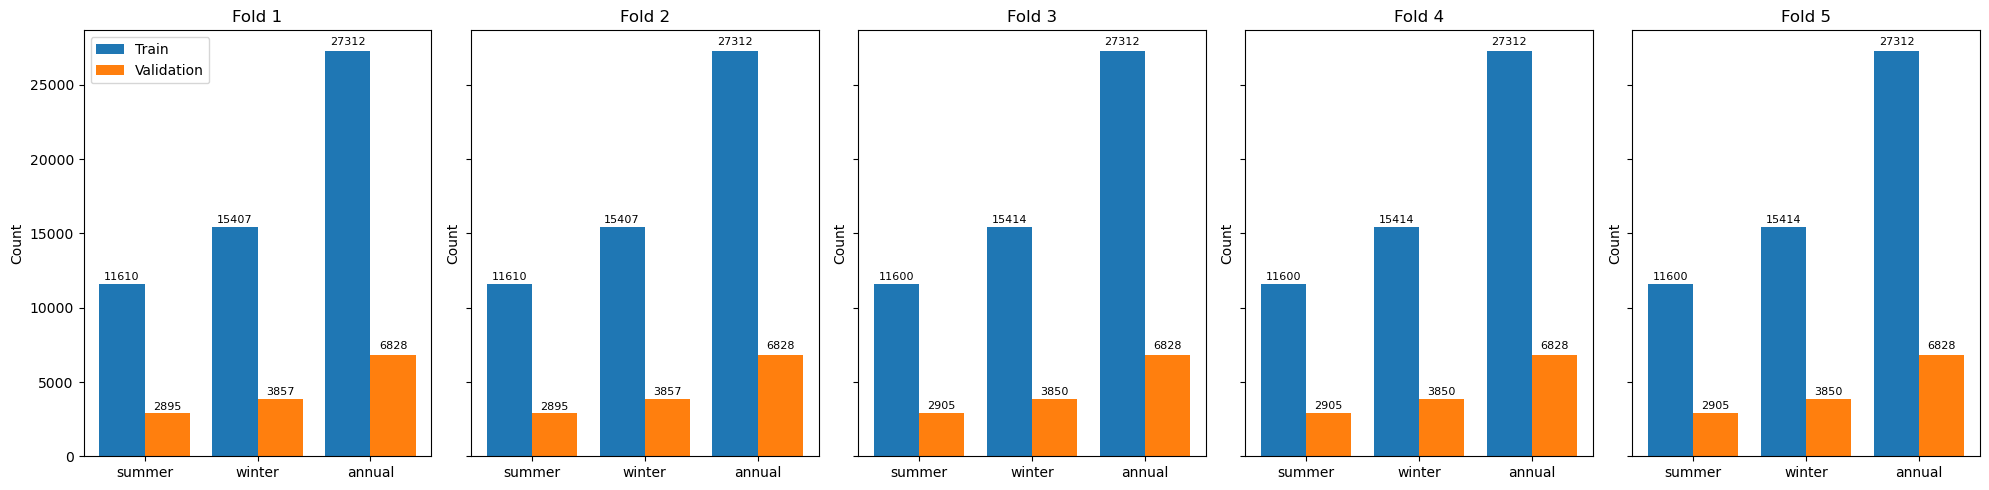

In [29]:
# Count number of annual and seasonal per fold

fig, axes = plt.subplots(1, 5, figsize=(20, 5), sharey=True)

# Create a color map or list for the bars
colors = ['C0', 'C1']

n_months_to_season = {5: 'summer', 7: 'winter', 12: 'annual'}

for i, (train_index, val_index) in enumerate(splits_s):
    ax = axes[i]

    n_months_train = df_train_X.iloc[train_index]['n_months']
    n_months_val = df_train_X.iloc[val_index]['n_months']
    
    # Counts
    n_months_train_counts = dict(zip(*np.unique(n_months_train, return_counts=True)))
    n_months_val_counts = dict(zip(*np.unique(n_months_val, return_counts=True)))
    
    #n_months_values = sorted(set(n_months_train_counts.keys()).union(n_months_val_counts.keys()))
    n_months_values = sorted(set(n_months_train_counts.keys()).union(n_months_val_counts.keys()))
    season_names = [n_months_to_season[n_months] for n_months in n_months_values]

    train_positions = np.arange(len(n_months_values))
    val_positions = train_positions + 0.4 
    
    train_counts = [n_months_train_counts.get(x, 0) for x in n_months_values]
    ax.bar(train_positions, train_counts, width=0.4, label='Train', color=colors[0])
    
    val_counts = [n_months_val_counts.get(x, 0) for x in n_months_values]
    ax.bar(val_positions, val_counts, width=0.4, label='Validation', color=colors[1])

    # Annotate each bar with the respective count
    for j in range(len(n_months_values)):
        train_count = n_months_train_counts.get(n_months_values[j], 0)
        val_count = n_months_val_counts.get(n_months_values[j], 0)
        train_pos = train_positions[j]
        val_pos = val_positions[j]
        
        ax.text(train_pos, train_count + max(train_count, val_count) * 0.01, str(train_count),
                ha='center', va='bottom', fontsize=8, color='k')

        ax.text(val_pos, val_count + max(train_count, val_count) * 0.01, str(val_count),
                ha='center', va='bottom', fontsize=8, color='k')
    
    ax.set_title(f'Fold {i+1}')
    #ax.set_xlabel('n_months')
    ax.set_ylabel('Count')
    ax.set_xticks(train_positions + 0.2) 
    #ax.set_xticklabels(n_months_values)  
    ax.set_xticklabels(season_names)
    
    if i == 0:
        ax.legend()

plt.tight_layout()
plt.show()

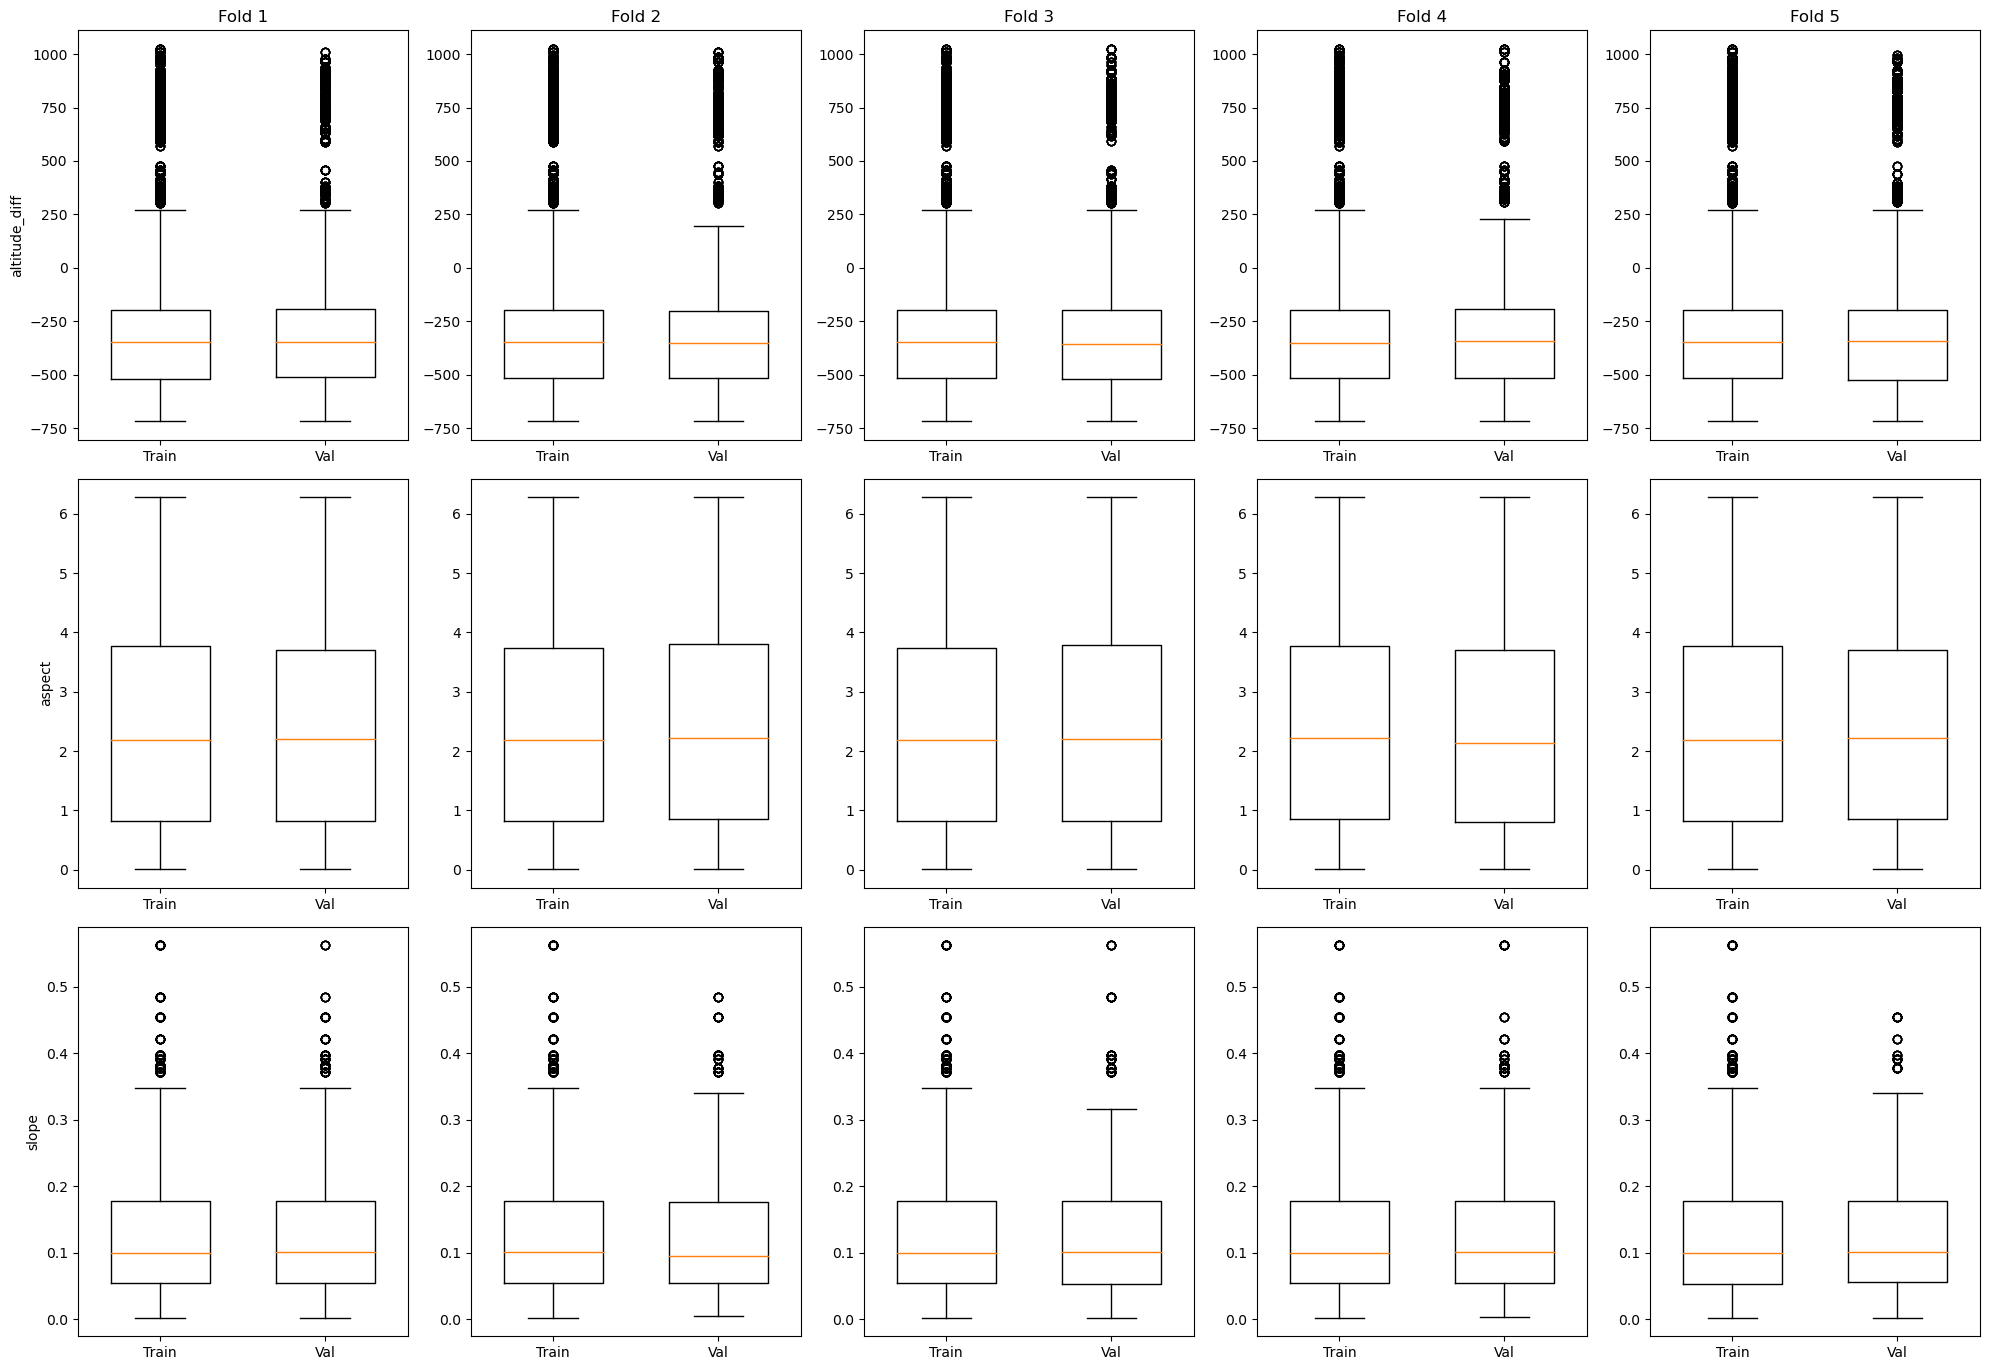

In [30]:
# Visualization of features
# Index(['altitude_diff', 'aspect', 'slope', 't2m', 'sshf', 'slhf', 'ssrd',
#       'fal', 'str', 'tp', 'id', 'n_months', 'month'],

feature_names = ['altitude_diff', 'aspect', 'slope']

fig, axes = plt.subplots(len(feature_names), 5, figsize=(20, len(feature_names) * 5))

for row, feature in enumerate(feature_names):
    for col, (train_index, val_index) in enumerate(splits_s):

        feature_train = df_train_X.iloc[train_index][feature]
        feature_val = df_train_X.iloc[val_index][feature]
        
        feature_data_combined = [feature_train, feature_val]
        
        axes[row, col].boxplot(feature_data_combined, positions=[1, 2], widths=0.6)
        
        if row == 0:
            axes[row, col].set_title(f'Fold {col+1}')
        if col == 0:
            axes[row, col].set_ylabel(feature)
        
        axes[row, col].set_xticks([1, 2])
        axes[row, col].set_xticklabels(['Train', 'Val'])

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

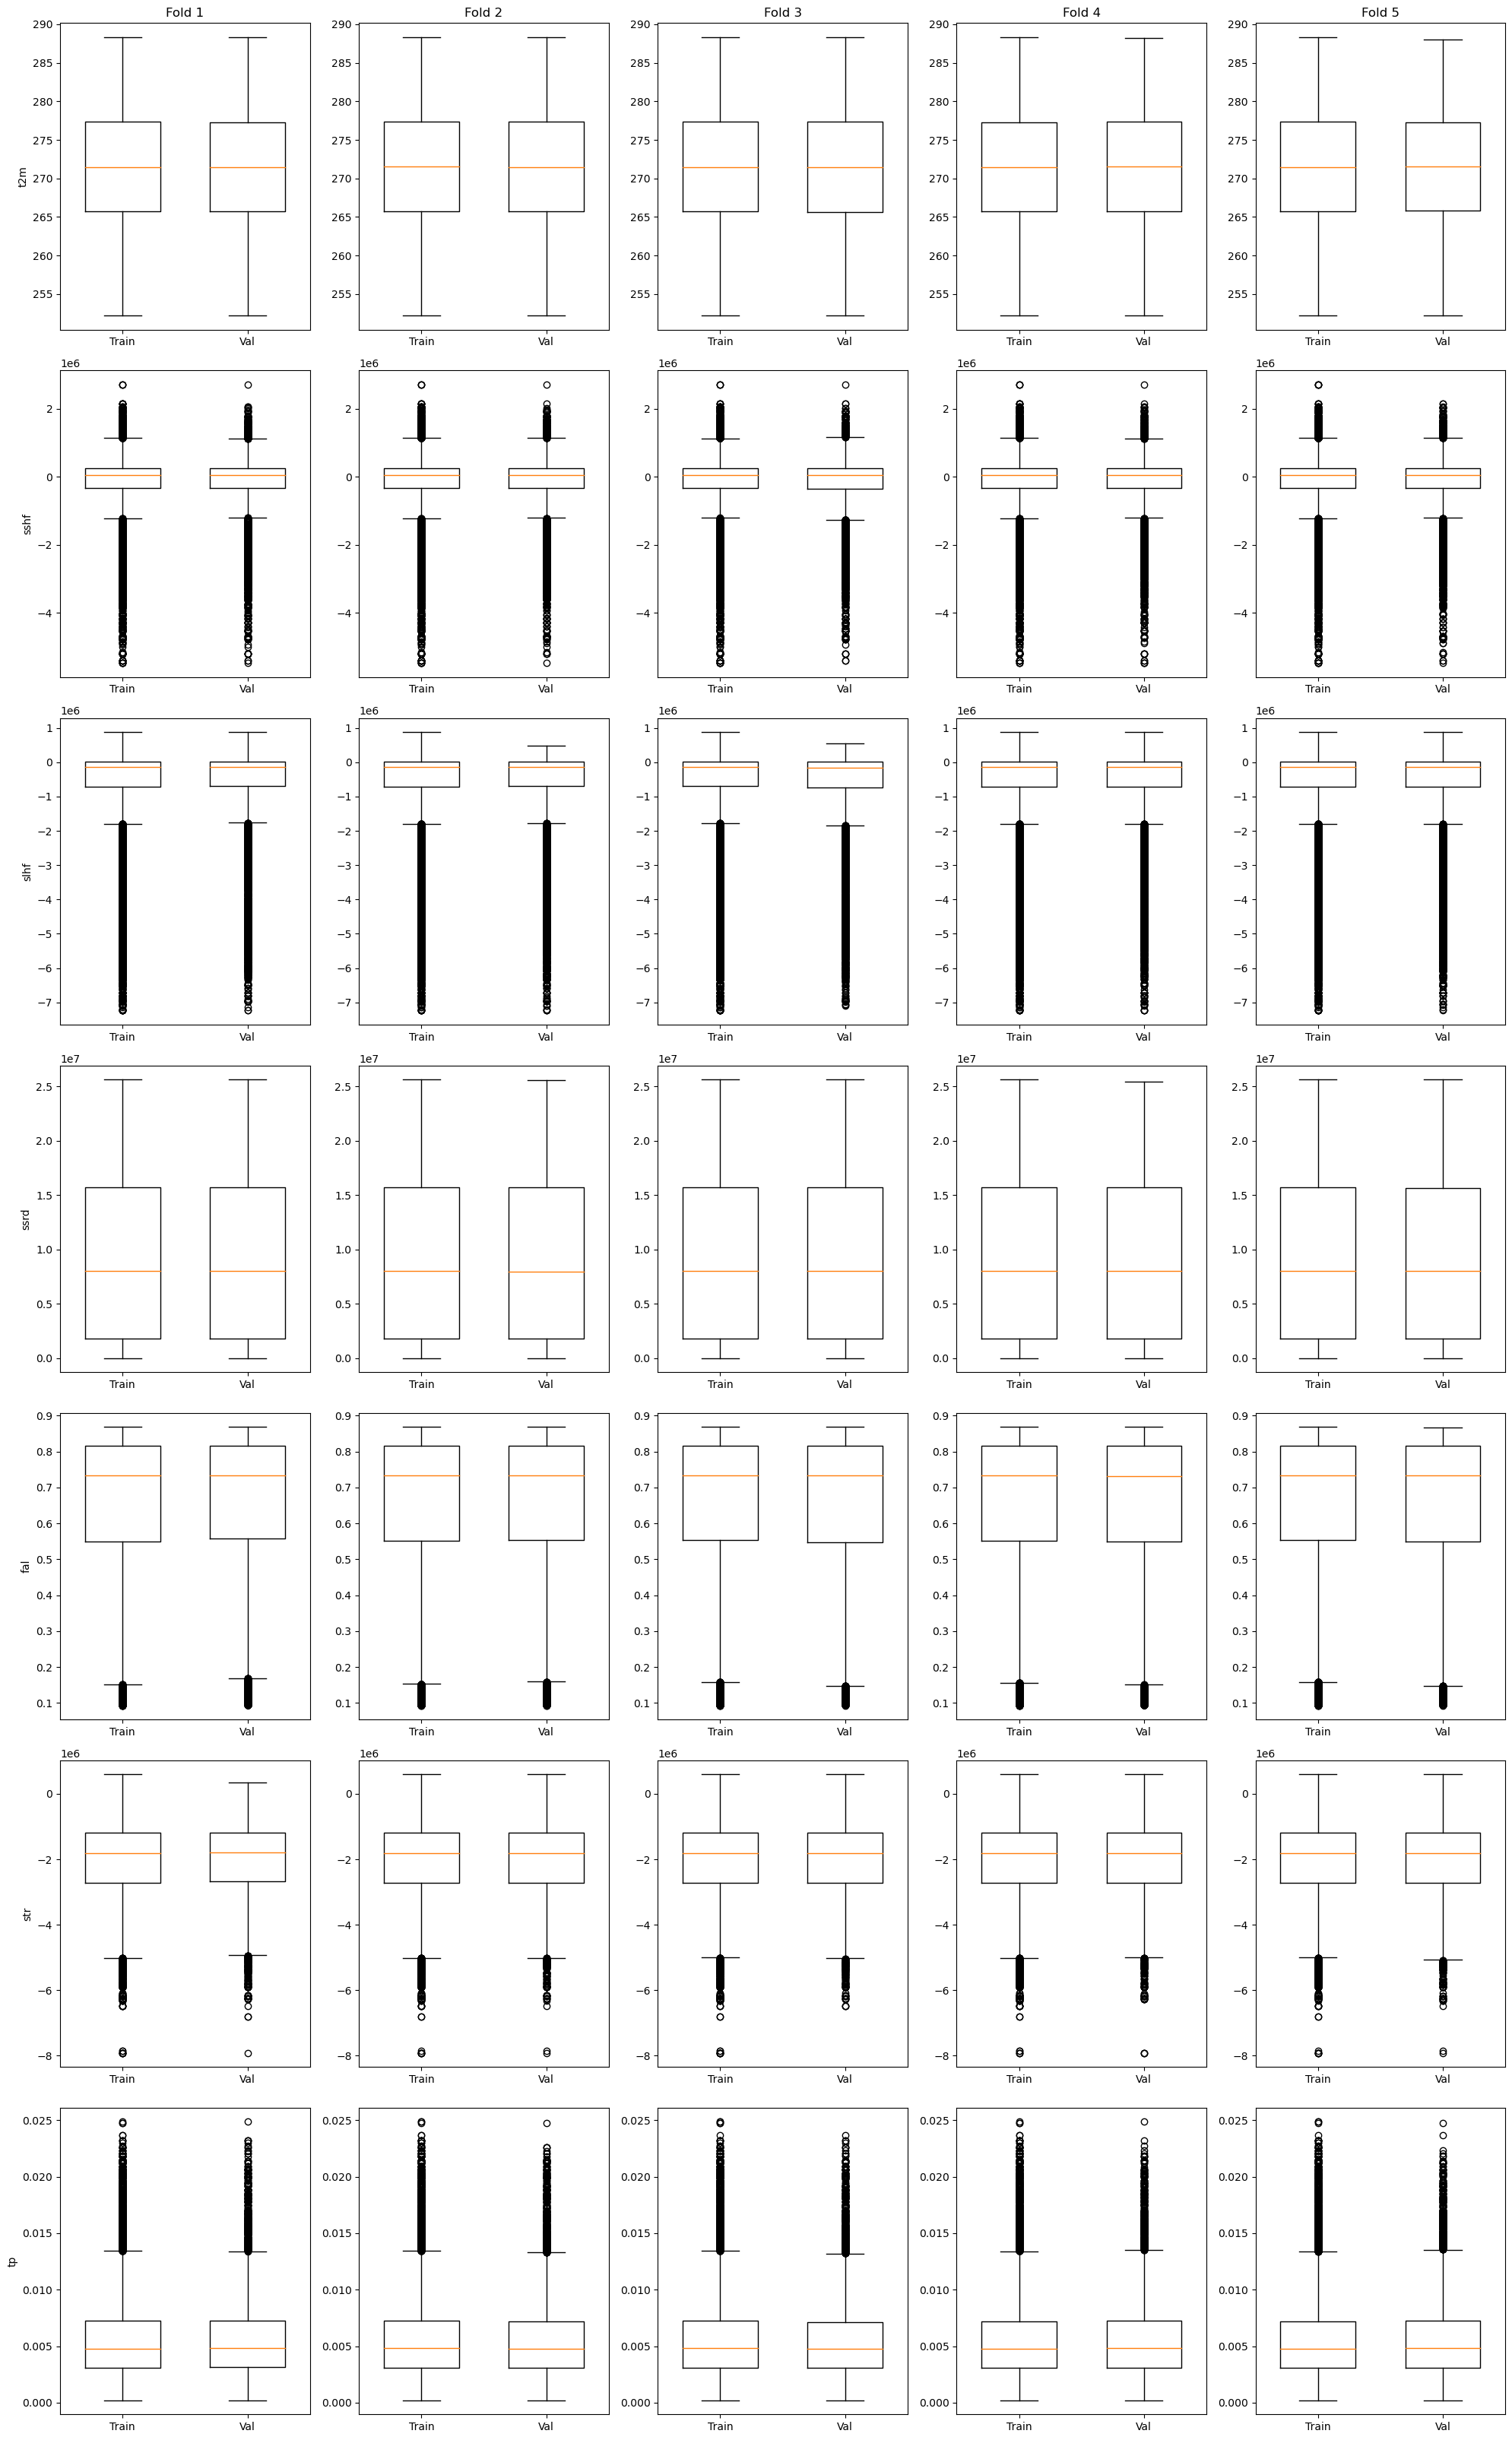

In [31]:
# Visualization of features
# Index(['altitude_diff', 'aspect', 'slope', 't2m', 'sshf', 'slhf', 'ssrd',
#       'fal', 'str', 'tp', 'id', 'n_months', 'month'],

feature_names = ['t2m', 'sshf', 'slhf', 'ssrd', 'fal', 'str', 'tp']

fig, axes = plt.subplots(len(feature_names), 5, figsize=(20, len(feature_names) * 5))

for row, feature in enumerate(feature_names):
    for col, (train_index, val_index) in enumerate(splits_s):

        feature_train = df_train_X.iloc[train_index][feature]
        feature_val = df_train_X.iloc[val_index][feature]
        
        feature_data_combined = [feature_train, feature_val]
        
        axes[row, col].boxplot(feature_data_combined, positions=[1, 2], widths=0.6)
        
        if row == 0:
            axes[row, col].set_title(f'Fold {col+1}')
        if col == 0:
            axes[row, col].set_ylabel(feature)
        
        axes[row, col].set_xticks([1, 2])
        axes[row, col].set_xticklabels(['Train', 'Val'])

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

## 3 Finalize test dataset

In [29]:
# Select features for test
df_test_X_reduce = df_test_final.drop(['balance','year','BREID'], axis=1)

# Move id and n_months to the end of the dataframe (these are to be used as metadata)
df_test_X = df_test_X_reduce[[c for c in df_test_X_reduce if c not in ['id','n_months','month']] + ['id','n_months','month']]

# Select labels for test
df_test_y = df_test_final[['balance']]

# Get arrays of features+metadata and targets
#X_test_unnorm, y_test = df_test_X.values, df_test_y.values
X_test, y_test = df_test_X.values, df_test_y.values

In [33]:
# Normalize features
# Using min-max scaling of training data

# Extract metadata columns
#metadata_columns_test = X_test_unnorm[:, -3:]

# Extract remaining columns
#remaining_columns_test = X_test_unnorm[:, :-3]

# Apply MinMaxScaler to the remaining columns
#scaled_remaining_columns_test = scaler.transform(remaining_columns_test)

# Combine scaled columns with metadata columns
#X_test = np.hstack((scaled_remaining_columns_test, metadata_columns_test))

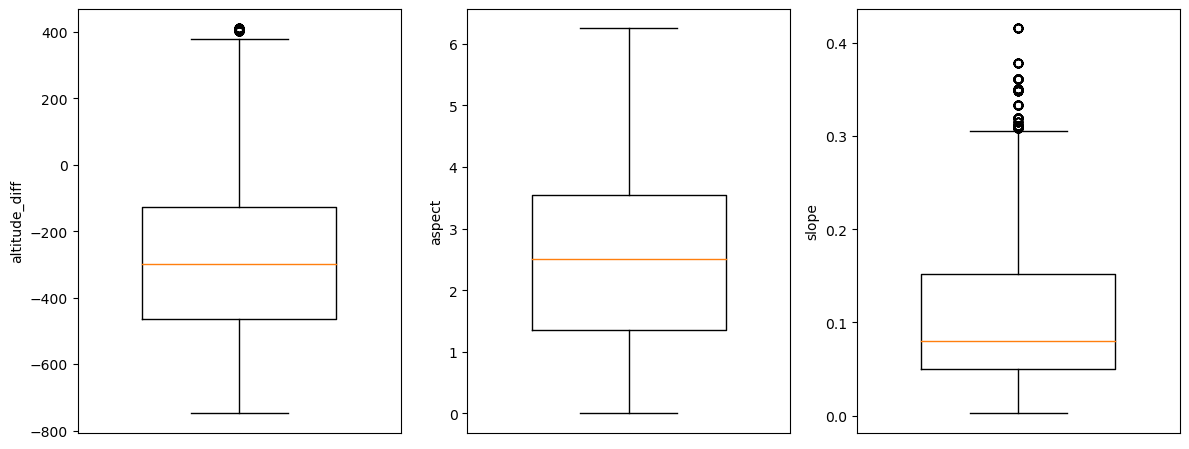

In [34]:
# Visualize test distributions

feature_names = ['altitude_diff', 'aspect', 'slope']

fig, axes = plt.subplots(1, len(feature_names), figsize=(12, 5))

for col, feature in enumerate(feature_names):
    feature_test = df_test_X[feature]  
    axes[col].boxplot(feature_test, positions=[1], widths=0.6)  

    axes[col].set_ylabel(feature)  

    axes[col].set_xticks([])

plt.tight_layout(rect=[0, 0.03, 1, 0.95]) 
plt.show()

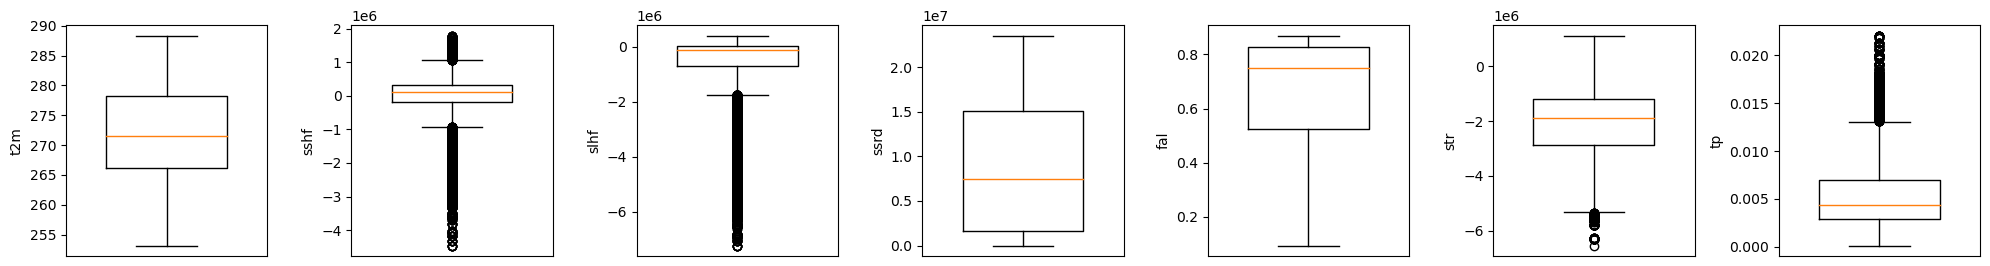

In [35]:
# Visualize test distributions

feature_names = ['t2m', 'sshf', 'slhf', 'ssrd', 'fal', 'str', 'tp']

fig, axes = plt.subplots(1, len(feature_names), figsize=(20, 3))

for col, feature in enumerate(feature_names):
    feature_test = df_test_X[feature]  
    axes[col].boxplot(feature_test, positions=[1], widths=0.6)  

    axes[col].set_ylabel(feature)  

    axes[col].set_xticks([])

plt.tight_layout(rect=[0, 0.03, 1, 0.95]) 
plt.show()

## 4 Define loss function and helper functions

#### Custom loss/objective function scikit learn api with metadata

To be used with custom XGBRegressor class

In [30]:
# REFACTORED VERSION FROM JULIAN

# Custom mse objective function scikit learn api with metadata, to be used with custom XGBRegressor class

def custom_mse_metadata(y_true, y_pred, metadata):
    """
    Custom Mean Squared Error (MSE) objective function for evaluating monthly predictions with respect to 
    seasonally or annually aggregated observations.
    
    For use in cases where predictions are done on a monthly time scale and need to be aggregated to be
    compared with the true aggregated seasonal or annual value. Aggregations are performed according to a
    unique ID provided by metadata. The function computes gradients and hessians 
    used in gradient boosting methods, specifically for use with the XGBoost library's custom objective 
    capabilities.
    
    Parameters
    ----------
    y_true : numpy.ndarray
        True (seasonally or annually aggregated) values for each instance. For a unique ID, 
        values are repeated n_months times across the group, e.g. the annual mass balance for a group
        of 12 monthly predictions with the same unique ID is repeated 12 times. Before calculating the 
        loss, the mean over the n unique IDs is taken.
    
    y_pred : numpy.ndarray
        Predicted monthly values. These predictions will be aggregated according to the 
        unique ID before calculating the loss, e.g. 12 monthly predictions with the same unique ID is
        aggregated for evaluation against the true annual value.
    
    metadata : numpy.ndarray
        An ND numpy array containing metadata for each monthly prediction. The first column is mandatory 
        and represents the ID of the aggregated group to which each instance belongs. Each group identified 
        by a unique ID will be aggregated together for the loss calculation. The following columns in the 
        metadata can include additional information for each instance that may be useful for tracking or further 
        processing but are not used in the loss calculation, e.g. number of months to be aggregated or the name 
        of the month.
        
        ID (column 0): An integer that uniquely identifies the group which the instance belongs to.
            
    Returns
    -------
    gradients : numpy.ndarray
        The gradient of the loss with respect to the predictions y_pred. This array has the same shape 
        as y_pred.
    
    hessians : numpy.ndarray
        The second derivative (hessian) of the loss with respect to the predictions y_pred. For MSE loss, 
        the hessian is constant and thus this array is filled with ones, having the same shape as y_pred.
    """
            
    # Initialize gradients and hessians
    gradients = np.zeros_like(y_pred)
    hessians = np.ones_like(y_pred)

    # Get the aggregated predictions and the mean score based on the true labels, and predicted labels
    # based on the metadata.
    #y_pred_agg, y_true_mean, grouped_ids, df_metadata = CustomXGBoostRegressor._create_metadata_scores(metadata, y_true, y_pred)
    df_metadata = pd.DataFrame(metadata, columns=['ID', 'N_MONTHS', 'MONTH'])

    # Aggregate y_pred and y_true for each group
    grouped_ids = df_metadata.assign(y_true=y_true, y_pred=y_pred).groupby('ID')
    y_pred_agg = grouped_ids['y_pred'].sum().values
    y_true_mean = grouped_ids['y_true'].mean().values
    
    # Compute gradients
    gradients_agg = y_pred_agg - y_true_mean

    # Create a mapping from ID to gradient
    gradient_map = dict(zip(grouped_ids.groups.keys(), gradients_agg))

    # Assign gradients to corresponding indices
    df_metadata['gradient'] = df_metadata['ID'].map(gradient_map)
    gradients[df_metadata.index] = df_metadata['gradient'].values

    return gradients, hessians

In [31]:
# Custom pseudo huber loss objective function scikit learn api with metadata, to be used with custom XGBRegressor class

# https://github.com/dmlc/xgboost/issues/5479

#def huber_approx_obj(y_true, y_pred):
#    z = y_pred - y_true
#    delta = 1
#    scale = 1 + (z/delta)**2
#    scale_sqrt = np.sqrt(scale)
#    grad = z/scale_sqrt
#    hess = 1/(scale*scale_sqrt)
#    return grad, hess

def custom_phl_metadata(y_true, y_pred, metadata):
    """
    Custom Mean Squared Error (MSE) objective function for evaluating monthly predictions with respect to 
    seasonally or annually aggregated observations.
    
    For use in cases where predictions are done on a monthly time scale and need to be aggregated to be
    compared with the true aggregated seasonal or annual value. Aggregations are performed according to a
    unique ID provided by metadata. The function computes gradients and hessians 
    used in gradient boosting methods, specifically for use with the XGBoost library's custom objective 
    capabilities.
    
    Parameters
    ----------
    y_true : numpy.ndarray
        True (seasonally or annually aggregated) values for each instance. For a unique ID, 
        values are repeated n_months times across the group, e.g. the annual mass balance for a group
        of 12 monthly predictions with the same unique ID is repeated 12 times. Before calculating the 
        loss, the mean over the n unique IDs is taken.
    
    y_pred : numpy.ndarray
        Predicted monthly values. These predictions will be aggregated according to the 
        unique ID before calculating the loss, e.g. 12 monthly predictions with the same unique ID is
        aggregated for evaluation against the true annual value.
    
    metadata : numpy.ndarray
        An ND numpy array containing metadata for each monthly prediction. The first column is mandatory 
        and represents the ID of the aggregated group to which each instance belongs. Each group identified 
        by a unique ID will be aggregated together for the loss calculation. The following columns in the 
        metadata can include additional information for each instance that may be useful for tracking or further 
        processing but are not used in the loss calculation, e.g. number of months to be aggregated or the name 
        of the month.
        
        ID (column 0): An integer that uniquely identifies the group which the instance belongs to.
            
    Returns
    -------
    gradients : numpy.ndarray
        The gradient of the loss with respect to the predictions y_pred. This array has the same shape 
        as y_pred.
    
    hessians : numpy.ndarray
        The second derivative (hessian) of the loss with respect to the predictions y_pred. For MSE loss, 
        the hessian is constant and thus this array is filled with ones, having the same shape as y_pred.
    """
            
    # Initialize gradients and hessians
    gradients = np.zeros_like(y_pred)
    hessians = np.ones_like(y_pred)

    # Get the aggregated predictions and the mean score based on the true labels, and predicted labels
    # based on the metadata.
    #y_pred_agg, y_true_mean, grouped_ids, df_metadata = CustomXGBoostRegressor._create_metadata_scores(metadata, y_true, y_pred)
    df_metadata = pd.DataFrame(metadata, columns=['ID', 'N_MONTHS', 'MONTH'])

    # Aggregate y_pred and y_true for each group
    grouped_ids = df_metadata.assign(y_true=y_true, y_pred=y_pred).groupby('ID')
    y_pred_agg = grouped_ids['y_pred'].sum().values
    y_true_mean = grouped_ids['y_true'].mean().values

    z = y_pred_agg - y_true_mean

    # Delta set to 1 for mae approximation
    # TO-DO: Possibly use 1 as default and have user choose delta
    delta = 1

    scale = 1 + (z/delta)**2
    scale_sqrt = np.sqrt(scale)

    # Compute gradients
    gradients_agg = z/scale_sqrt

    # Compute hessians
    hessians_agg = 1/(scale*scale_sqrt)

    # Create a mapping from ID to gradient
    gradient_map = dict(zip(grouped_ids.groups.keys(), gradients_agg))

    # Create a mapping from ID to hessians
    hessian_map = dict(zip(grouped_ids.groups.keys(), hessians_agg))

    # Assign gradients to corresponding indices
    df_metadata['gradient'] = df_metadata['ID'].map(gradient_map)
    gradients[df_metadata.index] = df_metadata['gradient'].values

    # Assign hessians to corresponding indices
    df_metadata['hessian'] = df_metadata['ID'].map(hessian_map)
    hessians[df_metadata.index] = df_metadata['hessian'].values

    return gradients, hessians

In [32]:
# Custom objective function scikit learn api with metadata, to be used with custom XGBRegressor class

def custom_mse_metadata_original(y_true, y_pred, metadata):
    """
    Custom Mean Squared Error (MSE) objective function for evaluating monthly predictions with respect to 
    seasonally or annually aggregated observations.
    
    For use in cases where predictions are done on a monthly time scale and need to be aggregated to be
    compared with the true aggregated seasonal or annual value. Aggregations are performed according to a
    unique ID provided by metadata. The function computes gradients and hessians 
    used in gradient boosting methods, specifically for use with the XGBoost library's custom objective 
    capabilities.
    
    Parameters
    ----------
    y_true : numpy.ndarray
        True (seasonally or annually aggregated) values for each instance. For a unique ID, 
        values are repeated n_months times across the group, e.g. the annual mass balance for a group
        of 12 monthly predictions with the same unique ID is repeated 12 times. Before calculating the 
        loss, the mean over the n unique IDs is taken.
    
    y_pred : numpy.ndarray
        Predicted monthly values. These predictions will be aggregated according to the 
        unique ID before calculating the loss, e.g. 12 monthly predictions with the same unique ID is
        aggregated for evaluation against the true annual value.
    
    metadata : numpy.ndarray
        An ND numpy array containing metadata for each monthly prediction. The first column is mandatory 
        and represents the ID of the aggregated group to which each instance belongs. Each group identified 
        by a unique ID will be aggregated together for the loss calculation. The following columns in the 
        metadata can include additional information for each instance that may be useful for tracking or further 
        processing but are not used in the loss calculation, e.g. number of months to be aggregated or the name 
        of the month.
        
        ID (column 0): An integer that uniquely identifies the group which the instance belongs to.
            
    Returns
    -------
    gradients : numpy.ndarray
        The gradient of the loss with respect to the predictions y_pred. This array has the same shape 
        as y_pred.
    
    hessians : numpy.ndarray
        The second derivative (hessian) of the loss with respect to the predictions y_pred. For MSE loss, 
        the hessian is constant and thus this array is filled with ones, having the same shape as y_pred.
    """
    
    # Initialize empty arrays for gradient and hessian
    gradients = np.zeros_like(y_pred)
    hessians = np.ones_like(y_pred) # Ones in case of mse
    
    # Unique aggregation groups based on the aggregation ID
    unique_ids = np.unique(metadata[:, 0])
    
    # Loop over each unique ID to aggregate accordingly
    for uid in unique_ids:
        # Find indexes for the current aggregation group
        indexes = metadata[:, 0] == uid
        
        # Aggregate y_pred for the current group
        y_pred_agg = np.sum(y_pred[indexes])
        
        # True value is the same repeated value for the group, so we can use the mean
        y_true_mean = np.mean(y_true[indexes])
        
        # Compute gradients for the group based on the aggregated prediction
        gradient = y_pred_agg - y_true_mean
        gradients[indexes] = gradient

    return gradients, hessians

#### Custom estimator class based on XGBRegressor

Inherits from xgboost.XGBRegressor 

Note/to-do: Modify def __init__(self,..) to retrieve kwarg for number of columns of metadata (n_metadata) with default n_metadata=None, to allow for flexibility in the number of metadata columns.

In [65]:
# REFACTORED VERSION FROM JULIAN

from xgboost import XGBRegressor
from sklearn.utils.validation import check_is_fitted

class CustomXGBRegressor(XGBRegressor):
    """
    CustomXGBRegressor is an extension of the XGBoost regressor that incorporates additional metadata into the learning process. The estimator
    is tailored to handle training datasets where the last three columns are metadata rather than features.
    
    The metadata is utilized in a custom mean squared error function. This function calculates gradients and hessians incorporating metadata, 
    allowing the model to learn from both standard feature data and additional information provided as metadata.
    
    The custom objective closure captures metadata along with the target values and predicted values to compute the gradients and hessians needed
    for the XGBoost training process.

    The class contains a custom score function (custom mse) that is used in GridSearchCV to evaluate validation performance for each fold.
    This is the default scorer for the class.
    
    Parameters inherited from XGBRegressor are customizable and additional parameters can be passed via kwargs, which will be handled by the
    XGBRegressor's __init__ method.
    
    Examples
    --------
    >>> model = CustomXGBRegressor(n_estimators=500, learning_rate=0.05)
    >>> model.fit(X_train, y_train)  # X_train includes metadata as the last 3 columns
    >>> predictions = model.predict(X_test)  # X_test includes metadata as the last 3 columns
    
    Note: CustomXGBRegressor requires a custom MSE function, `custom_mse_metadata`, which computes the gradient and hessian using additional metadata.
    """
    
    def __init__(self, metadata_shape=3, **kwargs):
        self.metadata_shape = metadata_shape
        super().__init__(**kwargs)

    def fit(self, X, y, **fit_params):
        # Split features from metadata
        metadata, features = X[:, -self.metadata_shape:], X[:, :-self.metadata_shape]

        # Define closure that captures metadata for use in custom objective
        def custom_objective(y_true, y_pred):
            return custom_mse_metadata(y_true, y_pred, metadata)
            #return custom_phl_metadata(y_true, y_pred, metadata)

        # Set custom objective
        self.set_params(objective=custom_objective)

        # Call fit method from parent class (XGBRegressor)
        super().fit(features, y, **fit_params)

        return self

    def predict(self, X):
        # Check if the model is fitted
        check_is_fitted(self)
        
        features = X[:, :-self.metadata_shape]
        
        return super().predict(features)

    def score(self, X, y, sample_weight=None):

        y_pred = self.predict(X)

        metadata, features = X[:, -self.metadata_shape:], X[:, :-self.metadata_shape]
        
        # Get the aggregated predictions and the mean score based on the true labels, and predicted labels
        # based on the metadata.
        df_metadata = pd.DataFrame(metadata, columns=['ID', 'N_MONTHS', 'MONTH'])

        # Aggregate y_pred and y_true for each group
        grouped_ids = df_metadata.assign(y_true=y, y_pred=y_pred).groupby('ID')
        y_pred_agg = grouped_ids['y_pred'].sum().values
        y_true_mean = grouped_ids['y_true'].mean().values

        # Compute mse 
        mse = ((y_pred_agg - y_true_mean) ** 2).mean()

        # Compute mae
        #mae = abs(y_pred_agg - y_true_mean).mean()

        return -mse # Return negative because GridSearchCV maximizes score
        #return -mae


In [34]:
from xgboost import XGBRegressor
from sklearn.utils.validation import check_is_fitted

class CustomXGBRegressor_orig(XGBRegressor):
    """
    CustomXGBRegressor is an extension of the XGBoost regressor that incorporates additional metadata into the learning process. The estimator
    is tailored to handle training datasets where the last three columns are metadata rather than features.
    
    The metadata is utilized in a custom mean squared error function. This function calculates gradients and hessians incorporating metadata, 
    allowing the model to learn from both standard feature data and additional information provided as metadata.
    
    The custom objective closure captures metadata along with the target values and predicted values to compute the gradients and hessians needed
    for the XGBoost training process.

    The class contains a custom score function (custom mse) that is used in GridSearchCV to evaluate validation performance for each fold.
    This is the default scorer for the class.
    
    Parameters inherited from XGBRegressor are customizable and additional parameters can be passed via kwargs, which will be handled by the
    XGBRegressor's __init__ method.
    
    Examples
    --------
    >>> model = CustomXGBRegressor(n_estimators=500, learning_rate=0.05)
    >>> model.fit(X_train, y_train)  # X_train includes metadata as the last 3 columns
    >>> predictions = model.predict(X_test)  # X_test includes metadata as the last 3 columns
    
    Note: CustomXGBRegressor requires a custom MSE function, `custom_mse_metadata`, which computes the gradient and hessian using additional metadata.
    """
    
    def __init__(self, metadata_shape=3, **kwargs):
        self.metadata_shape = metadata_shape
        super().__init__(**kwargs)

    def fit(self, X, y, **fit_params):
        # Split features from metadata
        metadata, features = X[:, -self.metadata_shape:], X[:, :-self.metadata_shape]

        # Define closure that captures metadata for use in custom objective
        def custom_objective(y_true, y_pred):
            return custom_mse_metadata_original(y_true, y_pred, metadata)

        # Set custom objective
        self.set_params(objective=custom_objective)

        # Call fit method from parent class (XGBRegressor)
        super().fit(features, y, **fit_params)

        return self

    def predict(self, X):
        # Check if the model is fitted
        check_is_fitted(self)
        
        features = X[:, :-self.metadata_shape]
        
        return super().predict(features)

    def score(self, X, y, sample_weight=None):

        y_pred = self.predict(X)

        metadata, features = X[:, -self.metadata_shape:], X[:, :-self.metadata_shape]
        
        all_pred_agg = []
        all_true_mean = []
    
        unique_ids = np.unique(metadata[:, 0]) # ID is first column of metadata

        # Loop over each unique ID to aggregate/get mean
        for uid in unique_ids:

            indexes = metadata[:, 0] == uid
        
            # Aggregate predictions for the current ID
            y_pred_agg = np.sum(y_pred[indexes])
        
            # Get mean of true values for the current ID
            y_true_mean = np.mean(y[indexes])

            all_pred_agg.append(y_pred_agg)
            all_true_mean.append(y_true_mean)
        
            #mse += (y_pred_agg - y_true_mean) ** 2

        all_pred_agg = np.array(all_pred_agg)
        all_true_mean = np.array(all_true_mean)

        # Compute mse 
        mse = ((all_pred_agg - all_true_mean) ** 2).mean()

        return -mse # Return negative because GridSearchCV maximizes score        


In [52]:
# This version of CustomXGBRegressor does not have a custom scorer and it uses the default scorer for
# XGBRegressor. Therefore it cannot directly be used in GridSearchCV, but must be used with a custom scorer passed to 
# GridSearchCV. I have not been able to get this to work. 

from xgboost import XGBRegressor
from sklearn.utils.validation import check_is_fitted

class CustomXGBRegressor_woScorer(XGBRegressor):
    """
    CustomXGBRegressor is an extension of the XGBoost regressor that incorporates additional metadata into the learning process. The estimator
    is tailored to handle training datasets where the last three columns are metadata rather than features.
    
    The metadata is utilized in a custom mean squared error function. This function calculates gradients and hessians incorporating metadata, 
    allowing the model to learn from both standard feature data and additional information provided as metadata.
    
    The custom objective closure captures metadata along with the target values and predicted values to compute the gradients and hessians needed
    for the XGBoost training process.
    
    Parameters inherited from XGBRegressor are customizable and additional parameters can be passed via kwargs, which will be handled by the
    XGBRegressor's __init__ method.
    
    Examples
    --------
    >>> model = CustomXGBRegressor(n_estimators=500, learning_rate=0.05)
    >>> model.fit(X_train, y_train)  # X_train includes metadata as the last 3 columns
    >>> predictions = model.predict(X_test)  # X_test includes metadata as the last 3 columns
    
    Note: CustomXGBRegressor requires a custom MSE function, `custom_mse_metadata`, which computes the gradient and hessian using additional metadata.
    """
    
    def __init__(self, metadata_shape=3, **kwargs):
        self.metadata_shape = metadata_shape
        super().__init__(**kwargs)

    def fit(self, X, y, **fit_params):
        # Split features from metadata
        metadata, features = X[:, -self.metadata_shape:], X[:, :-self.metadata_shape]

        # Define closure that captures metadata for use in custom objective
        def custom_objective(y_true, y_pred):
            return custom_mse_metadata(y_true, y_pred, metadata)

        # Set custom objective
        self.set_params(objective=custom_objective)

        # Call fit method from parent class (XGBRegressor)
        super().fit(features, y, **fit_params)

        return self

    def predict(self, X):
        # Check if the model is fitted
        check_is_fitted(self)
        
        features = X[:, :-self.metadata_shape]
        
        return super().predict(features)



#### Custom scoring function to be used with Scikit learn grid search cv - NOT WORKING!

To use sklearn GridSearchCV we need a custom scoring function to evaluate the mse of predictions from each trained model on the validation fold. 
Currently, preds are monthly and y_val are dummy/repeated seasonal observations, i.e. the custom scorer needs to aggregate preds from the trained model to seasonal resolution and get mean of y_val for each identifier.

https://scikit-learn.org/stable/modules/model_evaluation.html#implementing-your-own-scoring-object

To-do:
Using custom scorers in functions where n_jobs > 1

While defining the custom scoring function alongside the calling function should work out of the box with the default joblib backend (loky), importing it from another module will be a more robust approach and work independently of the joblib backend.

For example, to use n_jobs greater than 1 in the example below, custom_scoring_function function is saved in a user-created module (custom_scorer_module.py) and imported:

from custom_scorer_module import custom_scoring_fun
ction 
cross_val_score(model,
 X_train,
 y_train,
 scoring=make_scorer(custom_scoring_function, greater_is_better=False),
 cv=5,
 n_jobs=-1) 


In [39]:
# This custom_mse_scorer is not working with CustomXGBRegressor_noScorer in GridSearchCV. 
# Instead, a custom default scorer is implemented in CustomXGBRegressor.

from sklearn.metrics import make_scorer

def custom_mse_scorer(y_true, y_pred, X):
    # Extract metadata
    metadata = X[:, -3:] 


    all_pred_agg = []
    all_true_mean = []
    
    unique_ids = np.unique(metadata[:, 0]) # ID is first column of metadata
    
    # Loop over each unique ID to aggregate/get mean
    for uid in unique_ids:

        indexes = metadata[:, 0] == uid
        
        # Aggregate predictions for the current ID
        y_pred_agg = np.sum(y_pred[indexes])
        
        # Get mean of true values for the current ID
        y_true_mean = np.mean(y_true[indexes])

        all_pred_agg.append(y_pred_agg)
        all_true_mean.append(y_true_mean)
        
        #mse += (y_pred_agg - y_true_mean) ** 2

    all_pred_agg = np.array(all_pred_agg)
    all_true_mean = np.array(all_true_mean)

    # Compute mse 
    mse = ((all_pred_agg - all_true_mean) ** 2).mean()
    #mse /= len(unique_ids)    
    
    return -mse  # Return negative because GridSearchCV maximizes score

# Need to use the make_scorer function to turn the custom evaluation function into a scorer object
# Wrap custom mse scorer to pass metadata 
def make_custom_mse_scorer():
    """Generates a customized scorer callable as required by GridSearchCV"""
    return make_scorer(custom_mse_scorer, greater_is_better=False, needs_proba=False, needs_X=True)

custom_mse_scorer = make_custom_mse_scorer()

C:\Program Files\Anaconda3\envs\ML_MB_Norway_env\lib\site-packages\sklearn\metrics\_scorer.py:548: FutureWarning: The `needs_threshold` and `needs_proba` parameter are deprecated in version 1.4 and will be removed in 1.6. You can either let `response_method` be `None` or set it to `predict` to preserve the same behaviour.
  warnings.warn(


#### Helper functions

In [33]:
# Get true values (means) and predicted values (aggregates)

def get_ytrue_y_pred_agg(y_true, y_pred, X):
    # Extract the metadata
    metadata = X[:, -3:]  # Assuming last three columns are the metadata
    unique_ids = np.unique(metadata[:, 0]) # Assuming ID is the first column
    y_pred_agg_all = []
    y_true_mean_all = []
    
    # Loop over each unique ID to calculate MSE
    for uid in unique_ids:
        # Indexes for the current ID
        indexes = metadata[:, 0] == uid
        # Aggregate y_pred for the current ID
        y_pred_agg = np.sum(y_pred[indexes])
        y_pred_agg_all.append(y_pred_agg)
        # True value is the mean of true values for the group
        y_true_mean = np.mean(y_true[indexes])
        y_true_mean_all.append(y_true_mean)

    y_pred_agg_all_arr = np.array(y_pred_agg_all)
    y_true_mean_all_arr = np.array(y_true_mean_all)
    
    return y_true_mean_all_arr, y_pred_agg_all_arr

In [34]:
def get_ytrue_y_pred_agg_season(y_true, y_pred, X, months=12):

    # Get values for the given season
    mask = X[:, -2] == months  
    X = X[mask] 
    
    # Extract the metadata
    metadata = X[:, -3:]  # Assuming last three columns are the metadata
    unique_ids = np.unique(metadata[:, 0]) # Assuming ID is the first column
    y_pred_agg_all = []
    y_true_mean_all = []
    
    # Loop over each unique ID to calculate MSE
    for uid in unique_ids:
        # Indexes for the current ID
        indexes = metadata[:, 0] == uid
        # Aggregate y_pred for the current ID
        y_pred_agg = np.sum(y_pred[indexes])
        y_pred_agg_all.append(y_pred_agg)
        # True value is the mean of true values for the group
        y_true_mean = np.mean(y_true[indexes])
        y_true_mean_all.append(y_true_mean)

    y_pred_agg_all_arr = np.array(y_pred_agg_all)
    y_true_mean_all_arr = np.array(y_true_mean_all)
    
    return y_true_mean_all_arr, y_pred_agg_all_arr

## 5 Model training

### 5.0 Test custom_mse_scorer with GridSearchCV on smaller version of dataset

In [111]:
# Set up dataset with random sample from annual, winter, summer

# Get random sample of annual, summer, winter
df_train_annual_sample = df_train_annual_clean.sample(n=200, random_state=42)
df_train_summer_sample = df_train_summer_clean.sample(n=200, random_state=42)
df_train_winter_sample = df_train_winter_clean.sample(n=200, random_state=42)

# Reshape dataframes to monthly resolution
df_train_summer_sample_final = reshape_dataset_monthly(df_train_summer_sample, id_vars, variables, summer_months_order)
df_train_winter_sample_final = reshape_dataset_monthly(df_train_winter_sample, id_vars, variables, winter_months_order)
df_train_annual_sample_final = reshape_dataset_monthly(df_train_annual_sample, id_vars, variables, annual_months_order)

# Combine training data in one dataframe
df_train_summer_sample_final.reset_index(drop=True, inplace=True)
df_train_winter_sample_final.reset_index(drop=True, inplace=True)
df_train_annual_sample_final.reset_index(drop=True, inplace=True)

data_list = [df_train_summer_sample_final, df_train_winter_sample_final, df_train_annual_sample_final]
df_train_sample_final = pd.concat(data_list)
df_train_sample_final


id  BREID  year  altitude_diff  balance    aspect     slope  n_months  \
0       30    596  1966     -28.818057    -2.35  0.592837  0.148739         5   
1       30    596  1966     -28.818057    -2.35  0.592837  0.148739         5   
2       30    596  1966     -28.818057    -2.35  0.592837  0.148739         5   
3       30    596  1966     -28.818057    -2.35  0.592837  0.148739         5   
4       30    596  1966     -28.818057    -2.35  0.592837  0.148739         5   
...    ...    ...   ...            ...      ...       ...       ...       ...   
2395  8496   3129  1966    -595.166788    -1.11  2.339748  0.073072        12   
2396  8496   3129  1966    -595.166788    -1.11  2.339748  0.073072        12   
2397  8496   3129  1966    -595.166788    -1.11  2.339748  0.073072        12   
2398  8496   3129  1966    -595.166788    -1.11  2.339748  0.073072        12   
2399  8496   3129  1966    -595.166788    -1.11  2.339748  0.073072        12   

     month         t2m         sshf        slhf        ssrd       fal  \
0      may  269.770782  -417692.000  -726530.00  18630252.0  0.737786   
1      jun  276.377563  -686794.500 -1012983.50  20104626.0  0.461197   
2      jul  280.937714 -2075654.875 -4231882.00  13420254.0  0.134671   
3      aug  278.349060 -1943034.875 -3186403.75  10243961.0  0.160891   
4      sep  270.681732  -466190.625  -631556.50   6222793.0  0.584299   
...    ...         ...          ...         ...         ...       ...   
2395   may  274.581451  -999674.375  -365272.00  18374314.0  0.573719   
2396   jun  280.670502 -1438736.125 -2274706.00  18968526.0  0.371381   
2397   jul  281.674072 -3145626.500 -5401439.00  16085079.0  0.136652   
2398   aug  281.446350 -1882089.875 -4254349.00  12390017.0  0.129752   
2399   sep  277.422150 -1071778.375 -2225687.00   6327439.0  0.129534   

             str        tp  
0    -3028802.00  0.003094  
1    -2650516.00  0.001567  
2    -3604558.25  0.003896  
3    -2956512.50  0.004033  
4    -1683846.00  0.004845  
...          ...       ...  
2395 -2969140.00  0.004337  
2396 -2764532.50  0.003802  
2397 -4410726.50  0.004859  
2398 -4094664.75  0.004397  
2399 -2385331.50  0.011932  

[4800 rows x 16 columns]

In [112]:
# Select features for training
df_train_X_reduce = df_train_sample_final.drop(['balance','year','BREID'], axis=1)

# Move id and n_months to the end of the dataframe (these are to be used as metadata)
df_train_X_sample = df_train_X_reduce[[c for c in df_train_X_reduce if c not in ['id','n_months','month']] + ['id','n_months','month']]

# Select labels for training
df_train_y_sample = df_train_sample_final[['balance']]

# Get arrays of features+metadata and targets
X_train_s, y_train_s = df_train_X_sample.values, df_train_y_sample.values

# Get glacier IDs from training dataset (in the order of which they appear in training dataset).
# gp_s is an array with shape equal to the shape of X_train_s and y_train_s.
gp_s_s = np.array(df_train_sample_final['id'].values)

# Use five folds
group_kf_s = GroupKFold(n_splits=5)

# Split into folds according to group by glacier ID.
# For each unique glacier ID, indices in gp_s indicate which rows in X_train_s and y_train_s belong to the glacier.
splits_s_s = list(group_kf_s.split(X_train_s, y_train_s, gp_s_s))

print(len(gp_s_s))
print(y_train_s.shape)
print(X_train_s.shape)
print(df_train_X_sample.columns)
print(df_train_y_sample.columns)

4800
(4800, 1)
(4800, 13)
Index(['altitude_diff', 'aspect', 'slope', 't2m', 'sshf', 'slhf', 'ssrd',
       'fal', 'str', 'tp', 'id', 'n_months', 'month'],
      dtype='object')
Index(['balance'], dtype='object')


In [113]:
# Check fold indices for training/validation data
fold_indices = []

for train_index, val_index in group_kf_s.split(X_train_s, y_train_s, gp_s_s):
    #print("TRAIN:", train_index, "VALIDATION:", val_index)
    print("shape(train):", train_index.shape, "test:", val_index.shape)
    fold_indices.append((train_index, val_index))


shape(train): (3840,) test: (960,)
shape(train): (3840,) test: (960,)
shape(train): (3840,) test: (960,)
shape(train): (3840,) test: (960,)
shape(train): (3840,) test: (960,)


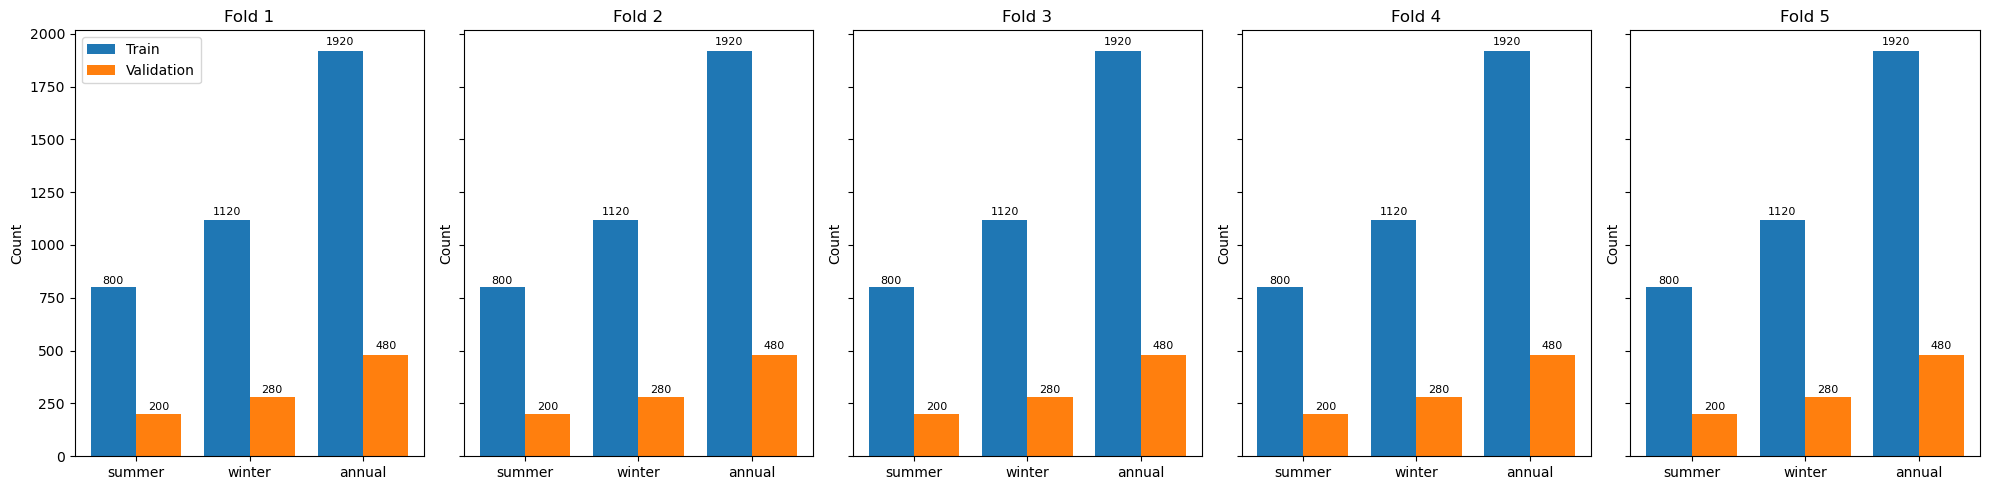

In [114]:
# Count number of annual and seasonal per fold

fig, axes = plt.subplots(1, 5, figsize=(20, 5), sharey=True)

# Create a color map or list for the bars
colors = ['C0', 'C1']

n_months_to_season = {5: 'summer', 7: 'winter', 12: 'annual'}

for i, (train_index, val_index) in enumerate(splits_s_s):
    ax = axes[i]

    n_months_train = df_train_X_sample.iloc[train_index]['n_months']
    n_months_val = df_train_X_sample.iloc[val_index]['n_months']
    
    # Counts
    n_months_train_counts = dict(zip(*np.unique(n_months_train, return_counts=True)))
    n_months_val_counts = dict(zip(*np.unique(n_months_val, return_counts=True)))
    
    #n_months_values = sorted(set(n_months_train_counts.keys()).union(n_months_val_counts.keys()))
    n_months_values = sorted(set(n_months_train_counts.keys()).union(n_months_val_counts.keys()))
    season_names = [n_months_to_season[n_months] for n_months in n_months_values]

    train_positions = np.arange(len(n_months_values))
    val_positions = train_positions + 0.4 
    
    train_counts = [n_months_train_counts.get(x, 0) for x in n_months_values]
    ax.bar(train_positions, train_counts, width=0.4, label='Train', color=colors[0])
    
    val_counts = [n_months_val_counts.get(x, 0) for x in n_months_values]
    ax.bar(val_positions, val_counts, width=0.4, label='Validation', color=colors[1])

    # Annotate each bar with the respective count
    for j in range(len(n_months_values)):
        train_count = n_months_train_counts.get(n_months_values[j], 0)
        val_count = n_months_val_counts.get(n_months_values[j], 0)
        train_pos = train_positions[j]
        val_pos = val_positions[j]
        
        ax.text(train_pos, train_count + max(train_count, val_count) * 0.01, str(train_count),
                ha='center', va='bottom', fontsize=8, color='k')

        ax.text(val_pos, val_count + max(train_count, val_count) * 0.01, str(val_count),
                ha='center', va='bottom', fontsize=8, color='k')
    
    ax.set_title(f'Fold {i+1}')
    #ax.set_xlabel('n_months')
    ax.set_ylabel('Count')
    ax.set_xticks(train_positions + 0.2) 
    #ax.set_xticklabels(n_months_values)  
    ax.set_xticklabels(season_names)
    
    if i == 0:
        ax.legend()

plt.tight_layout()
plt.show()

In [115]:
# Define hyperparameter grid
param_grid = {
    'max_depth': [3, 4, 5],#, 5, 6, 7, 8],
    'learning_rate': [0.01, 0.1],#, 0.2, 0.3],
    'n_estimators': [100, 200, 300, 400],
    'gamma':[0]#, 1, 10],
    }

xgb_model_s = CustomXGBRegressor()

clf = GridSearchCV(xgb_model_s, 
                   param_grid, 
                   cv=splits_s_s,
                   verbose=2, 
                   n_jobs=4, 
                   #scoring=custom_mse_scorer, 
                   scoring = None, # Uses default in CustomXGBRegressor()
                   refit=True, 
                   error_score='raise',
                   return_train_score=True) # Default False. If False, cv_results_ will not include training scores.

#X_features = X_train[:,:-3]

clf.fit(X_train_s, y_train_s)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


C:\Program Files\Anaconda3\envs\ML_MB_Norway_env\lib\site-packages\xgboost\core.py:160: UserWarning: [11:32:22] WARNING: D:\bld\xgboost-split_1705650032250\work\src\learner.cc:742: 
Parameters: { "metadata_shape" } are not used.

  warnings.warn(smsg, UserWarning)


GridSearchCV(cv=[(array([   0,    1,    2, ..., 4785, 4786, 4787]),
                  array([  10,   11,   12,   13,   14,   35,   36,   37,   38,   39,   55,
         56,   57,   58,   59,   60,   61,   62,   63,   64,   85,   86,
         87,   88,   89,  120,  121,  122,  123,  124,  145,  146,  147,
        148,  149,  170,  171,  172,  173,  174,  195,  196,  197,  198,
        199,  220,  221,  222,  223,  224,  260,  261,  262,  263,  264,
        285,  286,  287,  288,  289,  335,  336,  337,  338,  339,  340,
        341,  342,  343,  344,  365,  366,  367,  368,  369,  375,  376,
        377,  378,...
                                          max_delta_step=None, max_depth=None,
                                          max_leaves=None,
                                          min_child_weight=None, missing=nan,
                                          monotone_constraints=None,
                                          multi_strategy=None,
                                          n_estimators=None, n_jobs=None,
                                          num_parallel_tree=None,
                                          objective='reg:squarederror', ...),
             n_jobs=4,
             param_grid={'gamma': [0], 'learning_rate': [0.01, 0.1],
                         'max_depth': [3, 4, 5],
                         'n_estimators': [100, 200, 300, 400]},
             return_train_score=True, verbose=2)

In [116]:
clf.cv_results_

{'mean_fit_time': array([ 2.61558394,  5.51799755,  8.54584718, 12.05234299,  2.99711914,
         5.83598604,  9.22830358, 13.75065036,  3.87030668,  7.37608309,
        11.18019438, 15.31760588,  3.65978427,  7.18985877, 10.59135833,
        13.94584832,  3.51128964,  7.03577757, 10.94791026, 15.75783353,
         3.64811478,  6.95111113, 12.09521241, 14.19531493]),
 'std_fit_time': array([0.04828631, 0.1070452 , 0.17380347, 0.1970568 , 0.10068233,
        0.07755495, 0.32981464, 0.62857951, 0.3427156 , 0.11067639,
        0.09483409, 0.35095483, 0.13218643, 0.09463175, 0.15108734,
        0.10427224, 0.04852474, 0.08707772, 0.55192382, 0.52178398,
        0.16297478, 0.16508729, 0.52088337, 1.91688058]),
 'mean_score_time': array([0.00837464, 0.00812197, 0.01034493, 0.01098919, 0.00856733,
        0.00974278, 0.01181026, 0.01694136, 0.01224427, 0.013064  ,
        0.01878195, 0.01918049, 0.00850897, 0.01386962, 0.00892634,
        0.01182995, 0.01018085, 0.01101847, 0.01339922, 0.01

In [117]:
clf.best_estimator_

CustomXGBRegressor(base_score=None, booster=None, callbacks=None,
                   colsample_bylevel=None, colsample_bynode=None,
                   colsample_bytree=None, device=None,
                   early_stopping_rounds=None, enable_categorical=False,
                   eval_metric=None, feature_types=None, gamma=0,
                   grow_policy=None, importance_type=None,
                   interaction_constraints=None, learning_rate=0.01,
                   max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
                   max_delta_step=None, max_depth=5, max_leaves=None,
                   min_child_weight=None, missing=nan,
                   monotone_constraints=None, multi_strategy=None,
                   n_estimators=400, n_jobs=None, num_parallel_tree=None,
                   objective=<function CustomXGBRegressor.fit.<locals>.custom_objective at 0x000002178B824EE0>, ...)

In [118]:
# Save the model to a binary file
best_model = clf.best_estimator_

best_model.save_model('Models/Custom_loss/xgb_model_mini200_test_phl_200.bin')

C:\Program Files\Anaconda3\envs\ML_MB_Norway_env\lib\site-packages\xgboost\core.py:160: UserWarning: [11:34:14] WARNING: D:\bld\xgboost-split_1705650032250\work\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)


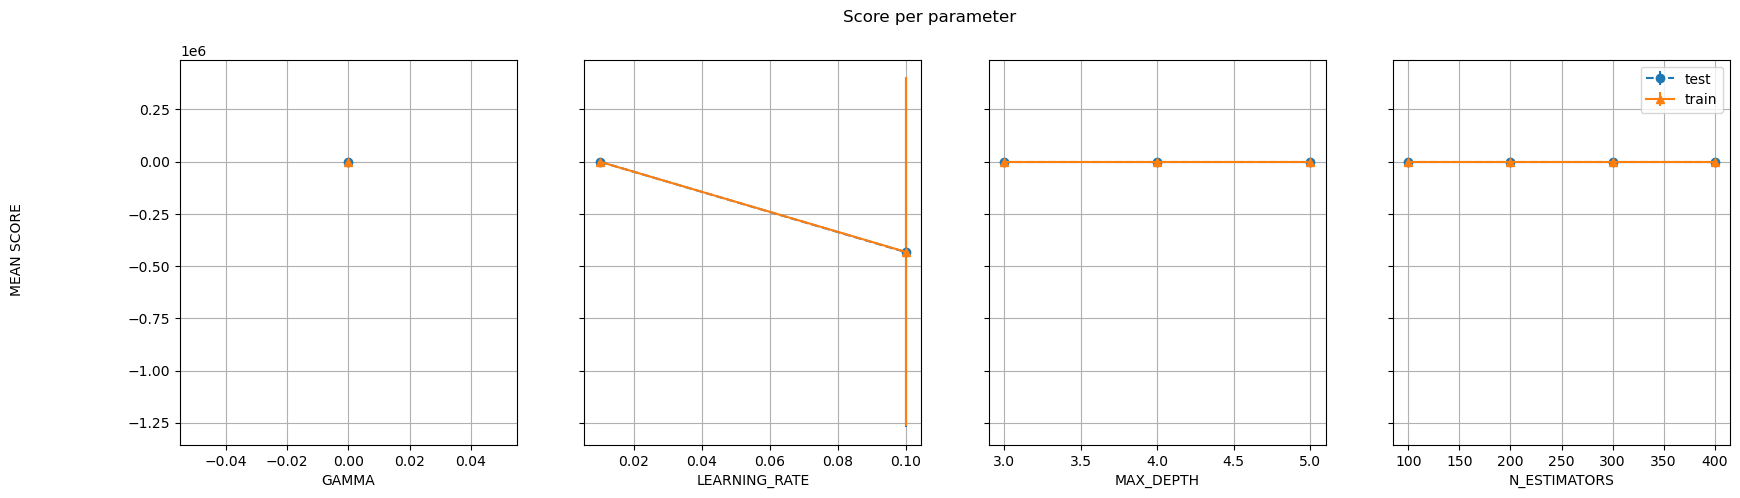

In [100]:
plot_gsearch_results(clf)

C:\Program Files\Anaconda3\envs\ML_MB_Norway_env\lib\site-packages\xgboost\core.py:160: UserWarning: [11:34:19] WARNING: D:\bld\xgboost-split_1705650032250\work\src\learner.cc:742: 
Parameters: { "metadata_shape" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Program Files\Anaconda3\envs\ML_MB_Norway_env\lib\site-packages\xgboost\core.py:160: UserWarning: [11:34:28] WARNING: D:\bld\xgboost-split_1705650032250\work\src\learner.cc:742: 
Parameters: { "metadata_shape" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Program Files\Anaconda3\envs\ML_MB_Norway_env\lib\site-packages\xgboost\core.py:160: UserWarning: [11:34:38] WARNING: D:\bld\xgboost-split_1705650032250\work\src\learner.cc:742: 
Parameters: { "metadata_shape" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Program Files\Anaconda3\envs\ML_MB_Norway_env\lib\site-packages\xgboost\core.py:160: UserWarning: [11:34:47] WARNING: D:\bld\xgboost-split_1705650032250\work\src\learner.cc:742: 
Parameters: { "metadata

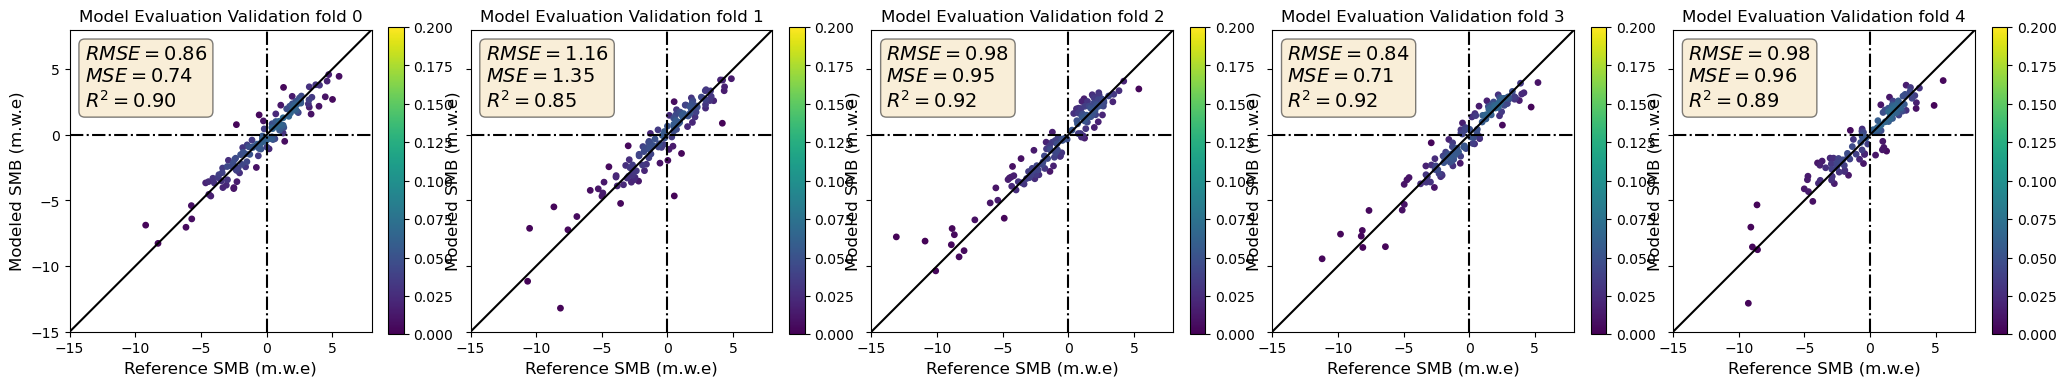

In [119]:
best_model = clf.best_estimator_

# Evaluate validation performance
fig, ax = plt.subplots(1,5, sharex=True, sharey=True, figsize=(25,25))
a = 0    
for train_index, val_index in splits_s_s:
    # Loops over n_splits iterations and gets train and test splits in each fold
    X_train_, X_val_ = X_train_s[train_index], X_train_s[val_index]
    y_train_, y_val_ = y_train_s[train_index], y_train_s[val_index]
    best_model.fit(X_train_, y_train_)
    y_pred = best_model.predict(X_val_)

    title = 'Validation fold ' + str(a)

    y_val_agg, y_pred_agg = get_ytrue_y_pred_agg(y_val_,y_pred,X_val_)

    plot_prediction_subplot(y_val_agg, y_pred_agg, title, ax[a], n_toplot=5000, fold=True)

    a=a+1


In [141]:
print(y_val_agg)
print(y_pred_agg)
print(y_val_agg.shape)
print(y_pred_agg.shape)

[-2.35 -2.08 -3.04 -1.68 -0.59 -2.93 -1.69 -4.   -5.01 -4.69 -1.94 -4.77
 -3.93 -4.36 -2.9  -2.72 -2.39 -1.64 -2.29 -8.61 -9.08 -2.95 -1.92 -2.52
 -1.72  0.94  1.05 -0.41 -1.27 -0.8  -3.82 -1.06 -1.5  -2.55 -2.91 -2.89
 -1.96 -3.38 -3.65 -3.79  1.4   2.24  1.16  2.67  3.53 -0.18  3.2   2.16
  2.75  3.51  4.88  3.76  2.51  3.41  3.1   2.75  5.57  2.19  0.42  1.71
  1.55  1.72  2.35  3.08  3.05  1.46  2.05  1.48  1.86  1.7   1.75  1.87
  1.69  0.99  1.47  2.61  1.98  1.66  1.94  1.7   0.6   0.3  -2.4  -1.35
 -0.6  -0.32 -0.5  -0.5  -1.54 -0.61  1.57 -0.62 -2.95  0.97  0.85  0.54
  1.26 -9.27 -8.57  1.41  2.47 -8.96 -0.6   0.69  0.84  2.12  1.14 -0.71
 -0.53 -0.42  0.56  2.34  0.24  1.4   0.48 -0.62 -4.73  1.56  0.82 -2.78]
[-1.9080148e+00 -1.9088889e+00 -1.5458356e+00 -1.6578267e+00
 -6.4450949e-01 -3.3073556e+00 -1.2694535e+00 -2.3767269e+00
 -4.3284373e+00 -4.4091816e+00 -2.2678347e+00 -3.1172514e+00
 -3.4749699e+00 -4.0131598e+00 -2.7909584e+00 -2.8921592e+00
 -2.2012308e+00 -2.214572

C:\Program Files\Anaconda3\envs\ML_MB_Norway_env\lib\site-packages\xgboost\core.py:160: UserWarning: [11:35:21] WARNING: D:\bld\xgboost-split_1705650032250\work\src\learner.cc:742: 
Parameters: { "metadata_shape" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Program Files\Anaconda3\envs\ML_MB_Norway_env\lib\site-packages\xgboost\core.py:160: UserWarning: [11:35:32] WARNING: D:\bld\xgboost-split_1705650032250\work\src\learner.cc:742: 
Parameters: { "metadata_shape" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Program Files\Anaconda3\envs\ML_MB_Norway_env\lib\site-packages\xgboost\core.py:160: UserWarning: [11:35:42] WARNING: D:\bld\xgboost-split_1705650032250\work\src\learner.cc:742: 
Parameters: { "metadata_shape" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Program Files\Anaconda3\envs\ML_MB_Norway_env\lib\site-packages\xgboost\core.py:160: UserWarning: [11:35:53] WARNING: D:\bld\xgboost-split_1705650032250\work\src\learner.cc:742: 
Parameters: { "metadata

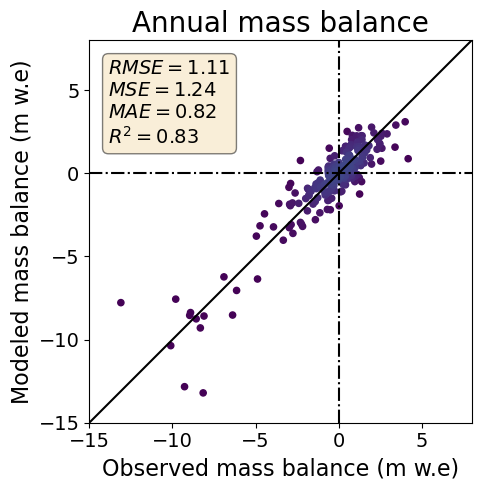

In [120]:
# Plot predictions vs. validation annual mass balance
y_val_annual, y_pred_annual = get_prediction_per_season(X_train_s, y_train_s, splits_s_s, best_model, months=12)
y_val_annual_mean, y_pred_annual_agg = get_ytrue_y_pred_agg_season(y_val_annual, y_pred_annual, X_train_s, months=12)
plot_prediction_per_season(y_val_annual_mean, y_pred_annual_agg, season='Annual')

C:\Program Files\Anaconda3\envs\ML_MB_Norway_env\lib\site-packages\xgboost\core.py:160: UserWarning: [11:36:26] WARNING: D:\bld\xgboost-split_1705650032250\work\src\learner.cc:742: 
Parameters: { "metadata_shape" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Program Files\Anaconda3\envs\ML_MB_Norway_env\lib\site-packages\xgboost\core.py:160: UserWarning: [11:36:36] WARNING: D:\bld\xgboost-split_1705650032250\work\src\learner.cc:742: 
Parameters: { "metadata_shape" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Program Files\Anaconda3\envs\ML_MB_Norway_env\lib\site-packages\xgboost\core.py:160: UserWarning: [11:36:47] WARNING: D:\bld\xgboost-split_1705650032250\work\src\learner.cc:742: 
Parameters: { "metadata_shape" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Program Files\Anaconda3\envs\ML_MB_Norway_env\lib\site-packages\xgboost\core.py:160: UserWarning: [11:36:58] WARNING: D:\bld\xgboost-split_1705650032250\work\src\learner.cc:742: 
Parameters: { "metadata

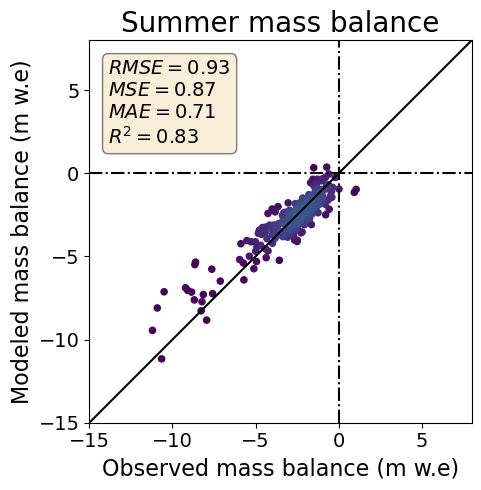

In [121]:
y_val_summer, y_pred_summer = get_prediction_per_season(X_train_s, y_train_s, splits_s_s, best_model, months=5)
y_val_summer_mean, y_pred_summer_agg = get_ytrue_y_pred_agg_season(y_val_summer, y_pred_summer, X_train_s, months=5)
plot_prediction_per_season(y_val_summer_mean, y_pred_summer_agg, season='Summer')

C:\Program Files\Anaconda3\envs\ML_MB_Norway_env\lib\site-packages\xgboost\core.py:160: UserWarning: [11:37:30] WARNING: D:\bld\xgboost-split_1705650032250\work\src\learner.cc:742: 
Parameters: { "metadata_shape" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Program Files\Anaconda3\envs\ML_MB_Norway_env\lib\site-packages\xgboost\core.py:160: UserWarning: [11:37:41] WARNING: D:\bld\xgboost-split_1705650032250\work\src\learner.cc:742: 
Parameters: { "metadata_shape" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Program Files\Anaconda3\envs\ML_MB_Norway_env\lib\site-packages\xgboost\core.py:160: UserWarning: [11:37:52] WARNING: D:\bld\xgboost-split_1705650032250\work\src\learner.cc:742: 
Parameters: { "metadata_shape" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Program Files\Anaconda3\envs\ML_MB_Norway_env\lib\site-packages\xgboost\core.py:160: UserWarning: [11:38:04] WARNING: D:\bld\xgboost-split_1705650032250\work\src\learner.cc:742: 
Parameters: { "metadata

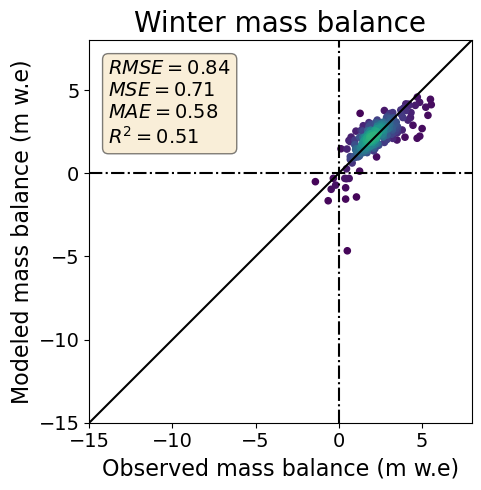

In [122]:
y_val_winter, y_pred_winter = get_prediction_per_season(X_train_s, y_train_s, splits_s_s, best_model, months=7)
y_val_winter_mean, y_pred_winter_agg = get_ytrue_y_pred_agg_season(y_val_winter, y_pred_winter, X_train_s, months=7)
plot_prediction_per_season(y_val_winter_mean, y_pred_winter_agg, season='Winter')

In [123]:
# Load trained model
xgb_model = CustomXGBRegressor()
xgb_model.load_model('Models/Custom_loss/xgb_model_mini200_test_phl_200.bin')

In [124]:
# TEST

y_pred_test = xgb_model.predict(X_test)

#plot_prediction(y_test_mean, y_test_pred_agg, data_type='test')

In [125]:
def get_prediction_per_season_test(X_test, y_test, best_model, months=12):

    y_pred = best_model.predict(X_test)

    indices = np.argwhere((X_test[:,-2] == months))[:,0]
    y_test_crop = y_test[indices]
    y_pred_crop = y_pred[indices]

    return y_test_crop, y_pred_crop

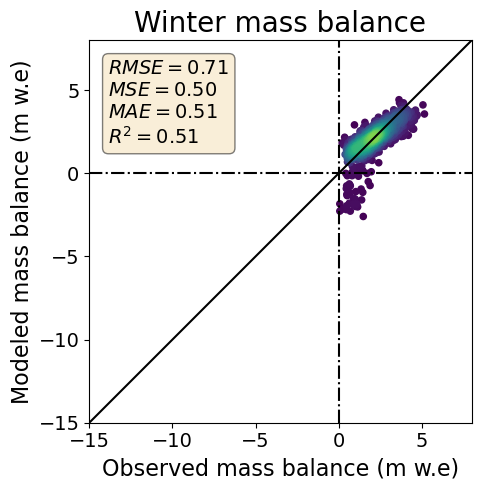

In [126]:
y_test_winter, y_pred_winter = get_prediction_per_season_test(X_test, y_test, xgb_model, months=7)
winter_indices = X_test[:, -2] == 7
X_test_winter = X_test[winter_indices]
y_test_winter_mean, y_pred_winter_agg = get_ytrue_y_pred_agg_season(y_test_winter, y_pred_winter, X_test_winter, months=7)
plot_prediction_per_season(y_test_winter_mean, y_pred_winter_agg, season='Winter')

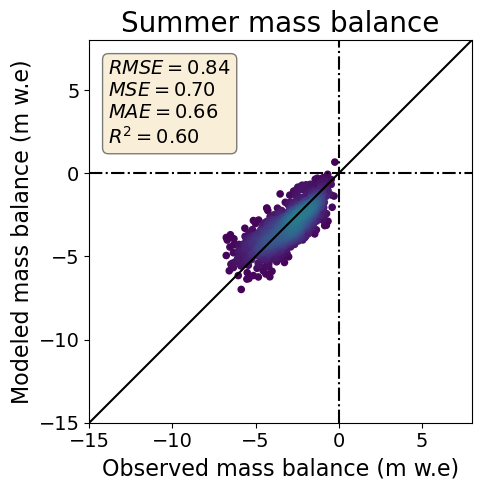

In [127]:
y_test_summer, y_pred_summer = get_prediction_per_season_test(X_test, y_test, xgb_model, months=5)
summer_indices = X_test[:, -2] == 5
X_test_summer = X_test[summer_indices]
y_test_summer_mean, y_pred_summer_agg = get_ytrue_y_pred_agg_season(y_test_summer, y_pred_summer, X_test_summer, months=5)
plot_prediction_per_season(y_test_summer_mean, y_pred_summer_agg, season='Summer')

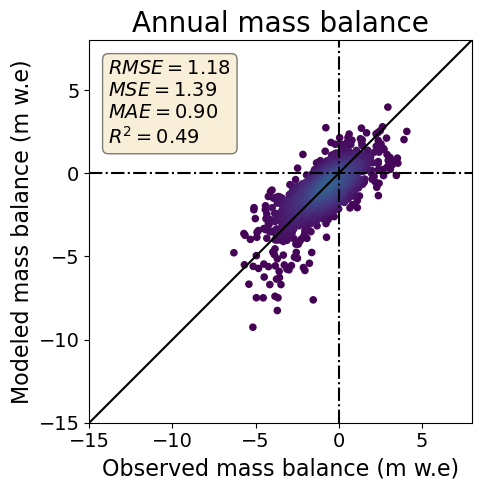

In [128]:
y_test_annual, y_pred_annual = get_prediction_per_season_test(X_test, y_test, xgb_model, months=12)
annual_indices = X_test[:, -2] == 12
X_test_annual = X_test[annual_indices]
y_test_annual_mean, y_pred_annual_agg = get_ytrue_y_pred_agg_season(y_test_annual, y_pred_annual, X_test_annual, months=12)
plot_prediction_per_season(y_test_annual_mean, y_pred_annual_agg, season='Annual')

### 5.1 Model testing: Train model on one fold of full dataset 

In [19]:
# Select fold 0 as training data and fold 1 as validation data
X_train_crop = X_train[fold_indices[0][0],:]
X_val_crop = X_train[fold_indices[0][1],:]
y_train_crop = y_train[fold_indices[0][0]]
y_val_crop = y_train[fold_indices[0][1]]
#X_train_crop = X_train[fold_indices[1][0],:]
#X_val_crop = X_train[fold_indices[1][1],:]
#y_train_crop = y_train[fold_indices[1][0]]
#y_val_crop = y_train[fold_indices[1][1]]

# Check folds
print(X_train_crop.shape)
print(X_val_crop.shape)
print(y_train_crop.shape)
print(y_val_crop.shape)

(54329, 13)
(13580, 13)
(54329, 1)
(13580, 1)


In [48]:
# Define custom XGBRegressor object
xgb_model = CustomXGBRegressor(max_depth=3, learning_rate=0.1, n_estimators=100, gamma=0)

# Fit model for fold 1
xgb_model.fit(X_train_crop, y_train_crop)

C:\Program Files\Anaconda3\envs\ML_MB_Norway_env\lib\site-packages\xgboost\core.py:160: UserWarning: [14:09:10] WARNING: D:\bld\xgboost-split_1705650032250\work\src\learner.cc:742: 
Parameters: { "metadata_shape" } are not used.

  warnings.warn(smsg, UserWarning)


CustomXGBRegressor(base_score=None, booster=None, callbacks=None,
                   colsample_bylevel=None, colsample_bynode=None,
                   colsample_bytree=None, device=None,
                   early_stopping_rounds=None, enable_categorical=False,
                   eval_metric=None, feature_types=None, gamma=0,
                   grow_policy=None, importance_type=None,
                   interaction_constraints=None, learning_rate=0.1,
                   max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
                   max_delta_step=None, max_depth=3, max_leaves=None,
                   min_child_weight=None, missing=nan,
                   monotone_constraints=None, multi_strategy=None,
                   n_estimators=100, n_jobs=None, num_parallel_tree=None,
                   objective=<function CustomXGBRegressor.fit.<locals>.custom_objective at 0x00000231C9547B50>, ...)

In [67]:
# Save the model to a binary file
xgb_model.save_model('Models/Custom_loss/xgb_model_fold1_test.bin')

C:\Program Files\Anaconda3\envs\ML_MB_Norway_env\lib\site-packages\xgboost\core.py:160: UserWarning: [16:26:32] WARNING: D:\bld\xgboost-split_1705650032250\work\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)


In [20]:
# Load model
loaded_model = CustomXGBRegressor()
loaded_model.load_model('Models/Custom_loss/xgb_model_fold1_test.bin')

In [21]:
# Make predictions on the validation data
predictions = loaded_model.predict(X_val_crop)

In [22]:
# Get validation true values and predictions
y_true_mean, y_pred_agg = get_ytrue_y_pred_agg(y_val_crop,predictions,X_val_crop)

C:\Program Files\Anaconda3\envs\ML_MB_Norway_env\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Program Files\Anaconda3\envs\ML_MB_Norway_env\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


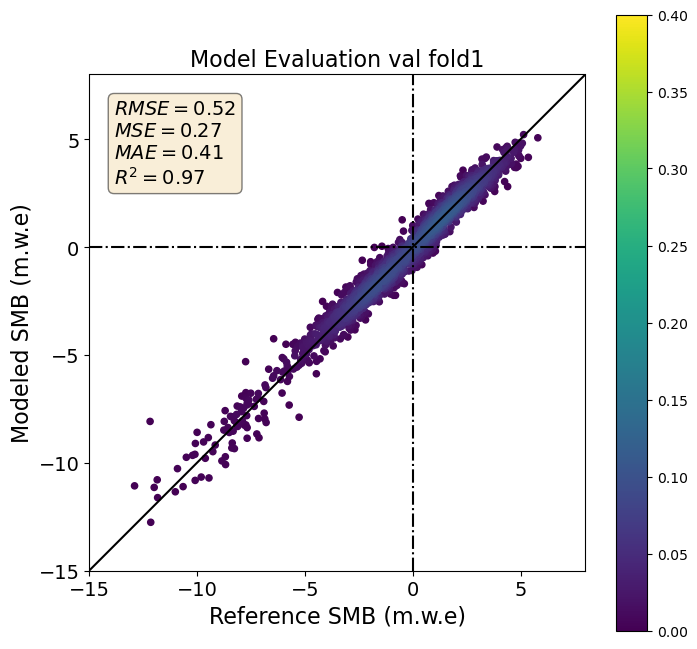

In [23]:
# Plot predictions vs true values for fold 1
plot_prediction(y_true_mean, y_pred_agg, data_type='val fold1')

### 5.2 Full model trained on cluster

In [55]:
# Load model
#loaded_model = CustomXGBRegressor()
#loaded_model.load_model('Models/Custom_loss/2024-06-14_19-29-23/custom_loss_best_model.bin')

# Model trained on cluster using up to 0.2 for learning rate. 
# Learning rate [0.01, 0.1, 0.2]
# Max depth [2, 4, 6]
# n_estimators [50, 100, 200, 300]
#with open('Training_cluster/2024-07-10_20-37-03/custom_loss_cv_grid.pkl', 'rb') as f:
#    clf_loaded = pickle.load(f)

# Model trained on cluster using extended grid search (after implementing custom loss funciton performance improvement)
# param_ranges = {'max_depth': [4, 5, 6, 7, 8], # Depth of tree
#                'n_estimators': [200, 300, 400, 500, 600, 700], # Number of trees (too many = overfitting, too few = underfitting)
#                'learning_rate': [0.1, 0.15, 0.2, 0.25], #[0,1]
#with open('Training_cluster/2024-08-06_12-07-32/custom_loss_cv_grid.pkl', 'rb') as f:
#    clf_loaded = pickle.load(f)

# Model trained on cluster using extended grid search (after implementing custom loss funciton performance improvement)
#param_ranges = {'max_depth': [5, 6, 7, 8], # Depth of tree
#                'n_estimators': [400, 500, 600, 700, 800], # Number of trees (too many = overfitting, too few = underfitting)
#                'learning_rate': [0.1, 0.15], #[0,1]
#                'gamma': [0, 10], # Regularization parameter, minimum loss reduction required to make split [0,inf]
#                'random_state': [23]
#               } 
#with open('Training_cluster/2024-08-07_13-11-48/custom_loss_cv_grid.pkl', 'rb') as f:
#    clf_loaded = pickle.load(f)

# Model trained on cluster forcing gamma=10
#param_ranges = {'max_depth': [5, 6, 7, 8], # Depth of tree
#                'n_estimators': [400, 500, 600, 700, 800], # Number of trees (too many = overfitting, too few = underfitting)
#                'learning_rate': [0.1, 0.15, 0.2], #[0,1]
#                'gamma': [10], # Regularization parameter, minimum loss reduction required to make split [0,inf]
#                'random_state': [23]
#               } 
with open('Training_cluster/2024-08-07_15-43-29/custom_loss_cv_grid.pkl', 'rb') as f:
    clf_loaded = pickle.load(f)

# Model trained on cluster with custom pseudo-huber loss ## NOT WORKING, TOO HIGH LEARNING RATE!
#param_ranges = {'max_depth': [5, 6, 7, 8], # Depth of tree
#                'n_estimators': [400, 500, 600, 700, 800], # Number of trees (too many = overfitting, too few = underfitting)
#                'learning_rate': [0.1, 0.15, 0.2], #[0,1]
#                'gamma': [0], # Regularization parameter, minimum loss reduction required to make split [0,inf]
#                'random_state': [23]
#               } 
#with open('Training_cluster/2024-08-08_12-41-40/custom_loss_cv_grid.pkl', 'rb') as f:
#    clf_loaded = pickle.load(f)

In [56]:
clf_loaded.best_estimator_


CustomXGBRegressor(base_score=None, booster=None, callbacks=None,
                   colsample_bylevel=None, colsample_bynode=None,
                   colsample_bytree=None, device=None,
                   early_stopping_rounds=None, enable_categorical=False,
                   eval_metric=None, feature_types=None, gamma=10,
                   grow_policy=None, importance_type=None,
                   interaction_constraints=None, learning_rate=0.1,
                   max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
                   max_delta_step=None, max_depth=7, max_leaves=None,
                   min_child_weight=None, missing=nan,
                   monotone_constraints=None, multi_strategy=None,
                   n_estimators=400, n_jobs=None, num_parallel_tree=None,
                   objective=<function CustomXGBRegressor.fit.<locals>.custom_objective at 0x0000029D90BC7010>, ...)

In [37]:
# Load cv-results
#import joblib
#cv_grid = joblib.load('Models/Custom_loss/2024-06-14_19-29-23/custom_loss_best_model.bin')
#best_model = cv_grid.best_estimator_

In [57]:

def plot_gsearch_results_mod(grid, learning_rate_threshold=0.3):
    """
    Params: 
        grid: A trained GridSearchCV object.
        learning_rate_threshold: The maximum learning rate to include in the plot.
    """
    # Results from grid search
    results = grid.cv_results_
    means_test = results['mean_test_score']
    stds_test = results['std_test_score']
    means_train = results['mean_train_score']
    stds_train = results['std_train_score']
    
    params_list = results['params']

    # Create a mask to filter out parameter combinations with learning rates > threshold
    learning_rate_mask = [param['learning_rate'] <= learning_rate_threshold for param in params_list]
    
    filtered_means_test = means_test[learning_rate_mask]
    filtered_stds_test = stds_test[learning_rate_mask]
    filtered_means_train = means_train[learning_rate_mask]
    filtered_stds_train = stds_train[learning_rate_mask]
    filtered_params_list = [params_list[i] for i in range(len(params_list)) if learning_rate_mask[i]]

    # Extract the unique values for each parameter to plot
    unique_param_values = {param_name: sorted(set(param_dict[param_name] for param_dict in filtered_params_list))
                           for param_name in grid.param_grid.keys()}

    width = len(grid.param_grid.keys()) * 5

    # Plot results
    fig, ax = plt.subplots(1, len(unique_param_values), sharex='none', sharey='all', figsize=(width, 5))
    fig.suptitle('Score per parameter')
    fig.text(0.04, 0.5, 'MEAN SCORE', va='center', rotation='vertical')

    for i, (param_name, param_values) in enumerate(unique_param_values.items()):
        # For each parameter, extract the means and stds of the scores
        param_results_test = {val: [] for val in param_values}
        param_results_train = {val: [] for val in param_values}
        
        for j, params in enumerate(filtered_params_list):
            param_results_test[params[param_name]].append((filtered_means_test[j], filtered_stds_test[j]))
            param_results_train[params[param_name]].append((filtered_means_train[j], filtered_stds_train[j]))

        # Aggregate the results for plotting
        x = param_values
        y_test = [np.mean([score[0] for score in param_results_test[val]]) for val in x]
        e_test = [np.mean([score[1] for score in param_results_test[val]]) for val in x]
        y_train = [np.mean([score[0] for score in param_results_train[val]]) for val in x]
        e_train = [np.mean([score[1] for score in param_results_train[val]]) for val in x]

        ax[i].errorbar(x, y_test, e_test, linestyle='--', marker='o', label='validation')
        ax[i].errorbar(x, y_train, e_train, linestyle='-', marker='^', label='train')
        ax[i].set_xlabel(param_name.upper())
        ax[i].grid()

    plt.legend()
    plt.show()


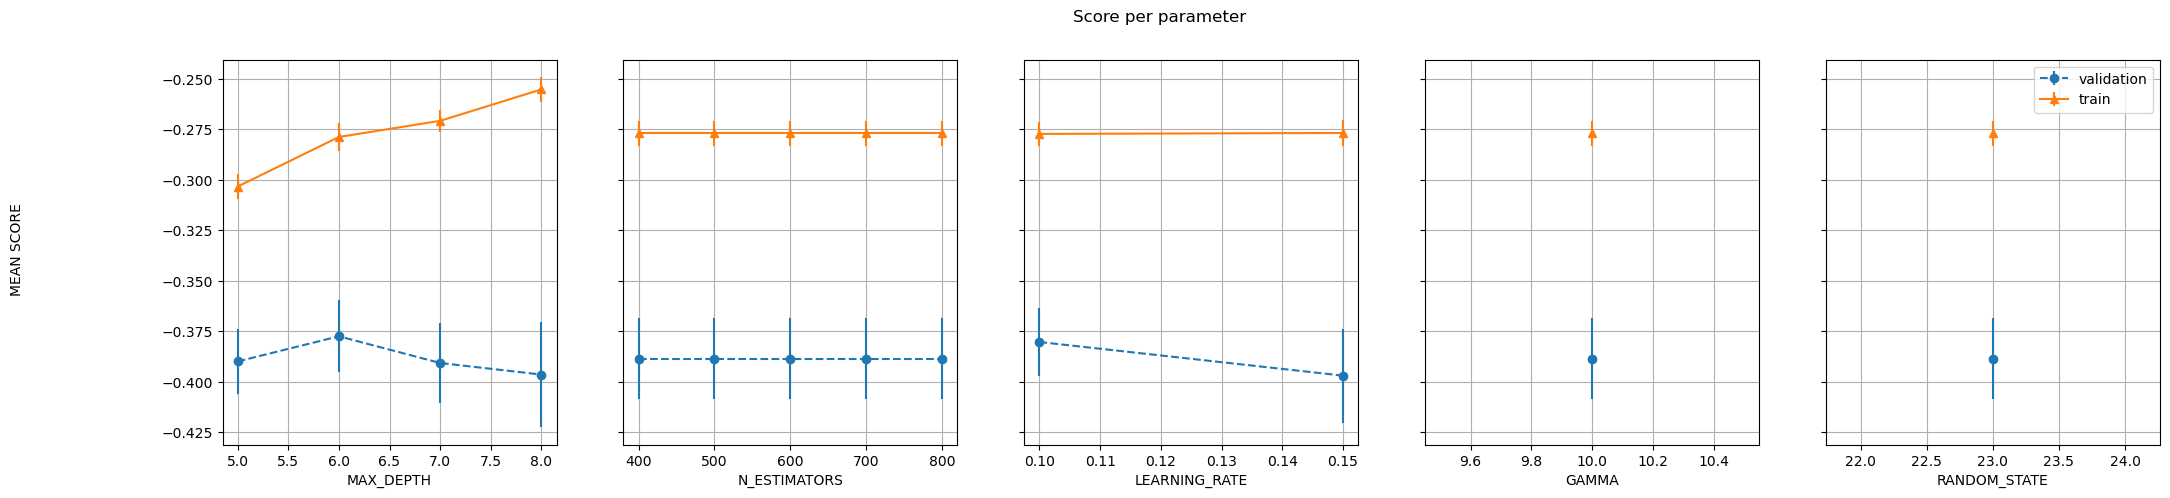

In [58]:
plot_gsearch_results_mod(clf_loaded, learning_rate_threshold=0.15)

In [59]:
clf_loaded.cv_results_


{'mean_fit_time': array([ 94.95724554,  97.89422259, 145.48802319, 169.58176694,
        170.39366517,  79.57706838, 123.54383531, 111.99206815,
        132.55708556, 161.7695292 ,  95.47004619, 102.46250954,
        144.82394609, 170.15583506, 170.2865149 ,  94.14708829,
        116.19287972, 122.9466681 , 135.11851416, 171.90516019,
         94.56096549, 121.07220964, 121.0450798 , 168.2090951 ,
        171.5264544 ,  81.03778749, 111.97245302, 142.4256813 ,
        154.29146318, 165.5962152 ,  75.96406674, 109.59625859,
        133.0972127 , 162.45461497, 180.45357623,  80.86625209,
        118.09134374, 118.16135116, 148.97398839, 180.5053587 ,
         80.78293839, 112.17459826, 144.80154095, 157.46634021,
        174.26139016,  84.18926373, 122.33755784, 122.14747014,
        155.01751733, 173.12903757,  93.37466016, 114.23097858,
        139.37591939, 149.64715333, 165.96610608,  90.1671279 ,
        109.05323334, 115.27953467, 116.11487827, 125.34160347]),
 'std_fit_time': arra

In [46]:
# Load separately because clf_loaded.best_estimator_ is refit using all data during 
# grid search and below the model is refit for each fold
fold_model = clf_loaded.best_estimator_

C:\Program Files\Anaconda3\envs\ML_MB_Norway_env\lib\site-packages\xgboost\core.py:160: UserWarning: [19:55:16] WARNING: D:\bld\xgboost-split_1705650032250\work\src\learner.cc:742: 
Parameters: { "metadata_shape" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Program Files\Anaconda3\envs\ML_MB_Norway_env\lib\site-packages\xgboost\core.py:160: UserWarning: [19:56:47] WARNING: D:\bld\xgboost-split_1705650032250\work\src\learner.cc:742: 
Parameters: { "metadata_shape" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Program Files\Anaconda3\envs\ML_MB_Norway_env\lib\site-packages\xgboost\core.py:160: UserWarning: [19:58:20] WARNING: D:\bld\xgboost-split_1705650032250\work\src\learner.cc:742: 
Parameters: { "metadata_shape" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Program Files\Anaconda3\envs\ML_MB_Norway_env\lib\site-packages\xgboost\core.py:160: UserWarning: [19:59:49] WARNING: D:\bld\xgboost-split_1705650032250\work\src\learner.cc:742: 
Parameters: { "metadata

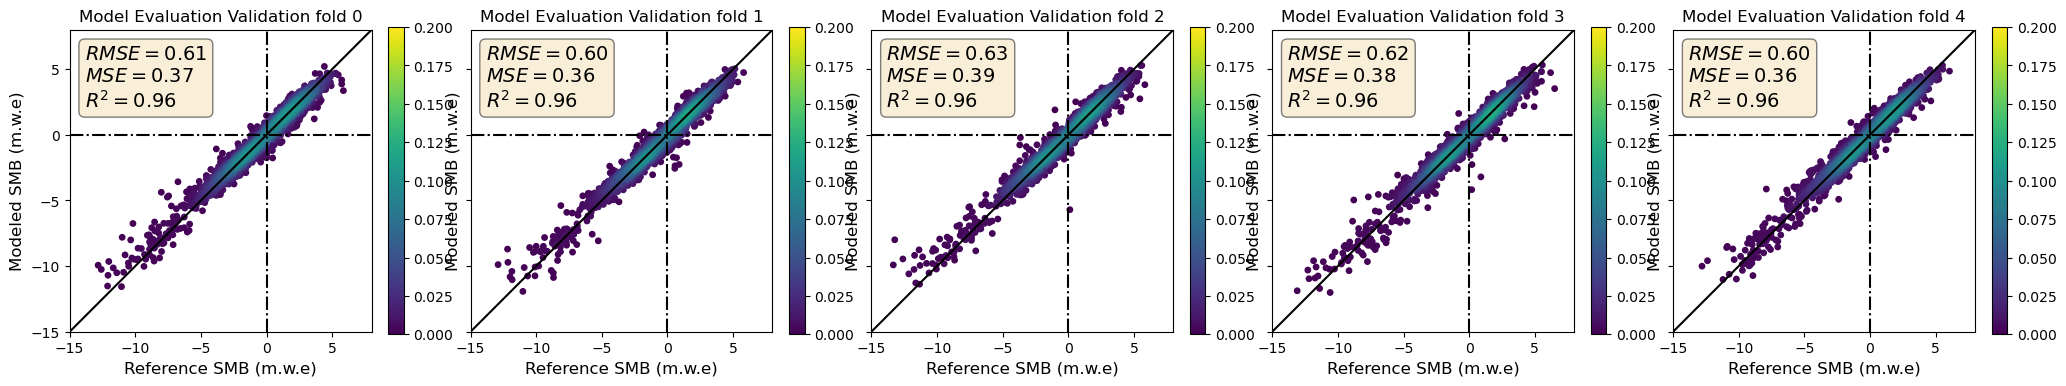

In [47]:
# Evaluate validation performance
fig, ax = plt.subplots(1,5, sharex=True, sharey=True, figsize=(25,25))
a = 0    
for train_index, val_index in splits_s:
    # Loops over n_splits iterations and gets train and test splits in each fold
    X_train_, X_val_ = X_train[train_index], X_train[val_index]
    y_train_, y_val_ = y_train[train_index], y_train[val_index]
    fold_model.fit(X_train_, y_train_)
    y_pred = fold_model.predict(X_val_)

    title = 'Validation fold ' + str(a)

    y_val_agg, y_pred_agg = get_ytrue_y_pred_agg(y_val_,y_pred,X_val_)

    plot_prediction_subplot(y_val_agg, y_pred_agg, title, ax[a], n_toplot=5000, fold=True)

    a=a+1

In [61]:
# Load best model refit to all training data
best_model = clf_loaded.best_estimator_

In [62]:
best_model

CustomXGBRegressor(base_score=None, booster=None, callbacks=None,
                   colsample_bylevel=None, colsample_bynode=None,
                   colsample_bytree=None, device=None,
                   early_stopping_rounds=None, enable_categorical=False,
                   eval_metric=None, feature_types=None, gamma=10,
                   grow_policy=None, importance_type=None,
                   interaction_constraints=None, learning_rate=0.1,
                   max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
                   max_delta_step=None, max_depth=7, max_leaves=None,
                   min_child_weight=None, missing=nan,
                   monotone_constraints=None, multi_strategy=None,
                   n_estimators=400, n_jobs=None, num_parallel_tree=None,
                   objective=<function CustomXGBRegressor.fit.<locals>.custom_objective at 0x0000029D90BC7010>, ...)

In [91]:
best_model = CustomXGBRegressor(max_depth=7, learning_rate=0.1, n_estimators=400, gamma=15, random_state=23)
best_model.fit(X_train, y_train)

C:\Program Files\Anaconda3\envs\ML_MB_Norway_env\lib\site-packages\xgboost\core.py:160: UserWarning: [14:03:45] WARNING: D:\bld\xgboost-split_1705650032250\work\src\learner.cc:742: 
Parameters: { "metadata_shape" } are not used.

  warnings.warn(smsg, UserWarning)


CustomXGBRegressor(base_score=None, booster=None, callbacks=None,
                   colsample_bylevel=None, colsample_bynode=None,
                   colsample_bytree=None, device=None,
                   early_stopping_rounds=None, enable_categorical=False,
                   eval_metric=None, feature_types=None, gamma=15,
                   grow_policy=None, importance_type=None,
                   interaction_constraints=None, learning_rate=0.1,
                   max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
                   max_delta_step=None, max_depth=7, max_leaves=None,
                   min_child_weight=None, missing=nan,
                   monotone_constraints=None, multi_strategy=None,
                   n_estimators=400, n_jobs=None, num_parallel_tree=None,
                   objective=<function CustomXGBRegressor.fit.<locals>.custom_objective at 0x0000029D91368040>, ...)

C:\Program Files\Anaconda3\envs\ML_MB_Norway_env\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Program Files\Anaconda3\envs\ML_MB_Norway_env\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


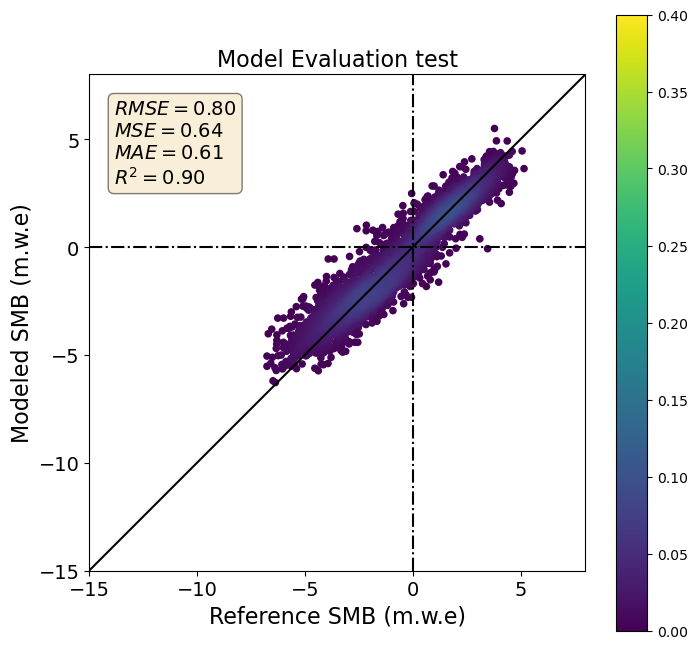

In [92]:
test_pred = best_model.predict(X_test)

# Get test true values and predictions
y_test_mean, y_test_pred_agg = get_ytrue_y_pred_agg(y_test,test_pred,X_test)

# Plot predictions vs true values for test
plot_prediction(y_test_mean, y_test_pred_agg, data_type='test')

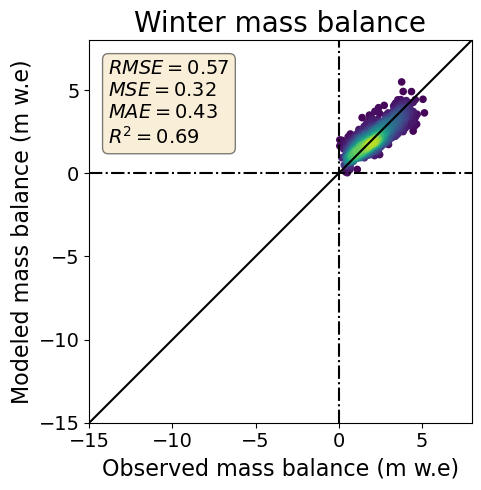

In [93]:
y_test_winter, y_pred_winter = get_prediction_per_season_test(X_test, y_test, best_model, months=7)
winter_indices = X_test[:, -2] == 7
X_test_winter = X_test[winter_indices]
y_test_winter_mean, y_pred_winter_agg = get_ytrue_y_pred_agg_season(y_test_winter, y_pred_winter, X_test_winter, months=7)
plot_prediction_per_season(y_test_winter_mean, y_pred_winter_agg, season='Winter')

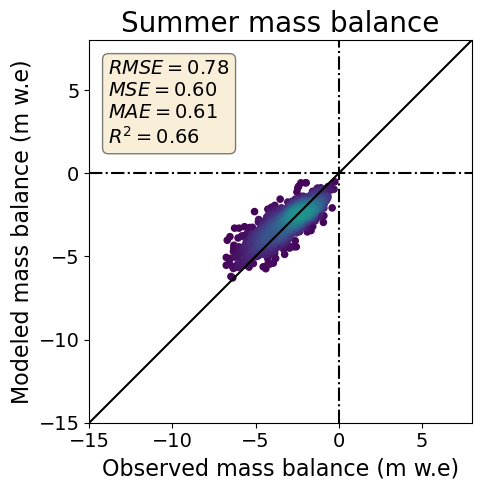

In [94]:
y_test_summer, y_pred_summer = get_prediction_per_season_test(X_test, y_test, best_model, months=5)
summer_indices = X_test[:, -2] == 5
X_test_summer = X_test[summer_indices]
y_test_summer_mean, y_pred_summer_agg = get_ytrue_y_pred_agg_season(y_test_summer, y_pred_summer, X_test_summer, months=5)
plot_prediction_per_season(y_test_summer_mean, y_pred_summer_agg, season='Summer')

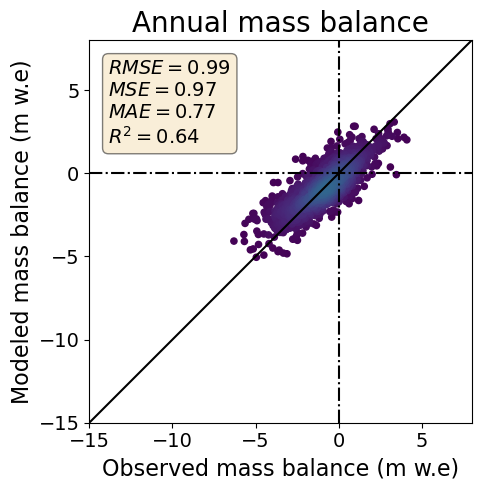

In [95]:
y_test_annual, y_pred_annual = get_prediction_per_season_test(X_test, y_test, best_model, months=12)
annual_indices = X_test[:, -2] == 12
X_test_annual = X_test[annual_indices]
y_test_annual_mean, y_pred_annual_agg = get_ytrue_y_pred_agg_season(y_test_annual, y_pred_annual, X_test_annual, months=12)
plot_prediction_per_season(y_test_annual_mean, y_pred_annual_agg, season='Annual')

In [89]:
best_model = CustomXGBRegressor(max_depth=6, learning_rate=0.1, n_estimators=600, gamma=10, random_state=23)
best_model.fit(X_train, y_train)

C:\Program Files\Anaconda3\envs\ML_MB_Norway_env\lib\site-packages\xgboost\core.py:160: UserWarning: [14:55:01] WARNING: D:\bld\xgboost-split_1705650032250\work\src\learner.cc:742: 
Parameters: { "metadata_shape" } are not used.

  warnings.warn(smsg, UserWarning)


CustomXGBRegressor(base_score=None, booster=None, callbacks=None,
                   colsample_bylevel=None, colsample_bynode=None,
                   colsample_bytree=None, device=None,
                   early_stopping_rounds=None, enable_categorical=False,
                   eval_metric=None, feature_types=None, gamma=10,
                   grow_policy=None, importance_type=None,
                   interaction_constraints=None, learning_rate=0.1,
                   max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
                   max_delta_step=None, max_depth=6, max_leaves=None,
                   min_child_weight=None, missing=nan,
                   monotone_constraints=None, multi_strategy=None,
                   n_estimators=600, n_jobs=None, num_parallel_tree=None,
                   objective=<function CustomXGBRegressor.fit.<locals>.custom_objective at 0x000001A662A888B0>, ...)

C:\Program Files\Anaconda3\envs\ML_MB_Norway_env\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Program Files\Anaconda3\envs\ML_MB_Norway_env\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


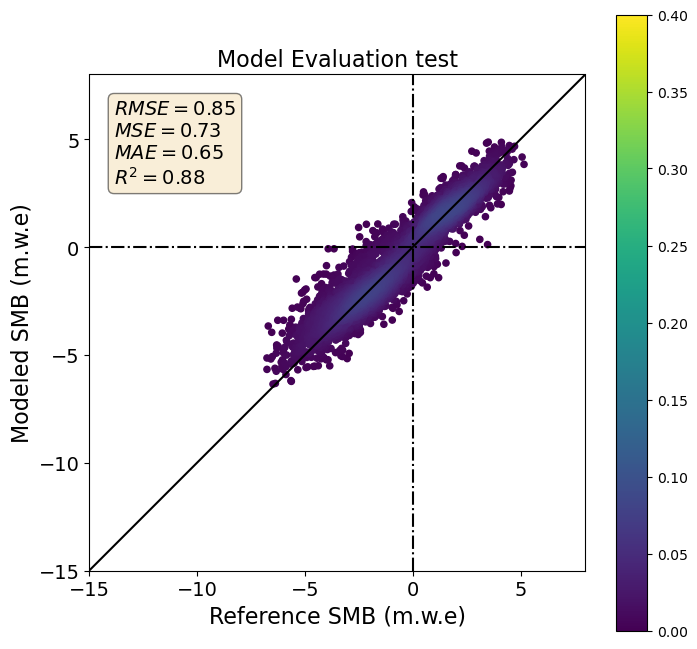

In [94]:
test_pred = best_model.predict(X_test)

# Get test true values and predictions
y_test_mean, y_test_pred_agg = get_ytrue_y_pred_agg(y_test,test_pred,X_test)

# Plot predictions vs true values for test
plot_prediction(y_test_mean, y_test_pred_agg, data_type='test')

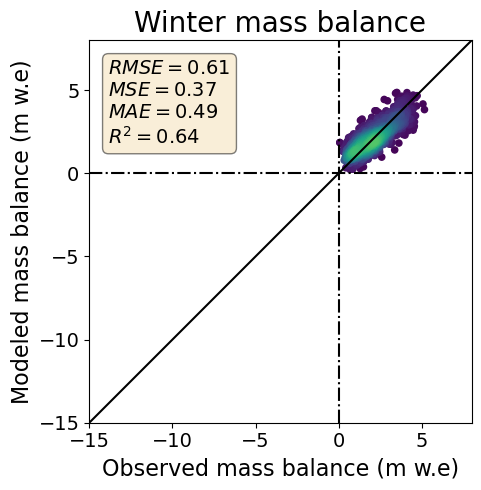

In [95]:
y_test_winter, y_pred_winter = get_prediction_per_season_test(X_test, y_test, best_model, months=7)
winter_indices = X_test[:, -2] == 7
X_test_winter = X_test[winter_indices]
y_test_winter_mean, y_pred_winter_agg = get_ytrue_y_pred_agg_season(y_test_winter, y_pred_winter, X_test_winter, months=7)
plot_prediction_per_season(y_test_winter_mean, y_pred_winter_agg, season='Winter')

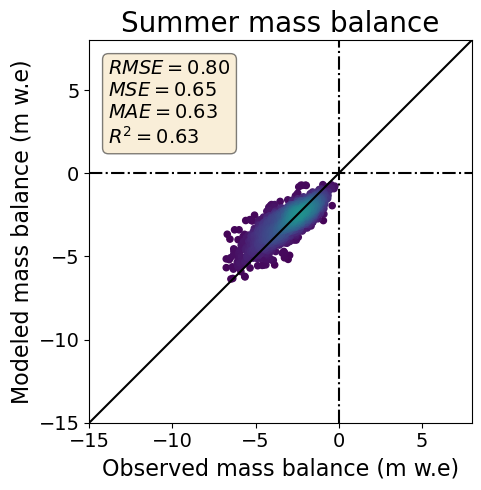

In [92]:
y_test_summer, y_pred_summer = get_prediction_per_season_test(X_test, y_test, best_model, months=5)
summer_indices = X_test[:, -2] == 5
X_test_summer = X_test[summer_indices]
y_test_summer_mean, y_pred_summer_agg = get_ytrue_y_pred_agg_season(y_test_summer, y_pred_summer, X_test_summer, months=5)
plot_prediction_per_season(y_test_summer_mean, y_pred_summer_agg, season='Summer')

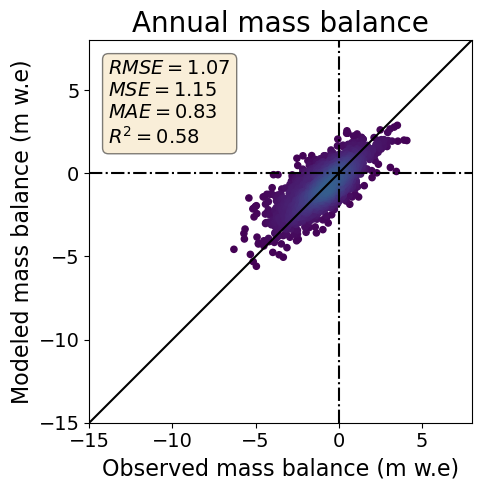

In [93]:
y_test_annual, y_pred_annual = get_prediction_per_season_test(X_test, y_test, best_model, months=12)
annual_indices = X_test[:, -2] == 12
X_test_annual = X_test[annual_indices]
y_test_annual_mean, y_pred_annual_agg = get_ytrue_y_pred_agg_season(y_test_annual, y_pred_annual, X_test_annual, months=12)
plot_prediction_per_season(y_test_annual_mean, y_pred_annual_agg, season='Annual')

### 5.2 Full model trained on cluster WITH NORMALIZED FEATURES

In [31]:
# Load model
#loaded_model = CustomXGBRegressor()
#loaded_model.load_model('Models/Custom_loss/2024-06-14_19-29-23/custom_loss_best_model.bin')

# Model trained on cluster using up to 0.2 for learning rate. 
# NORMALIZED FEATURES
# Learning rate [0.01, 0.1, 0.2]
# Max depth [2, 4, 6]
# n_estimators [50, 100, 200, 300]
with open('Training_cluster/2024-08-05_15-44-58/custom_loss_cv_grid.pkl', 'rb') as f:
    clf_loaded = pickle.load(f)

In [32]:
clf_loaded.best_estimator_


CustomXGBRegressor(base_score=None, booster=None, callbacks=None,
                   colsample_bylevel=None, colsample_bynode=None,
                   colsample_bytree=None, device=None,
                   early_stopping_rounds=None, enable_categorical=False,
                   eval_metric=None, feature_types=None, gamma=None,
                   grow_policy=None, importance_type=None,
                   interaction_constraints=None, learning_rate=0.1,
                   max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
                   max_delta_step=None, max_depth=6, max_leaves=None,
                   min_child_weight=None, missing=nan,
                   monotone_constraints=None, multi_strategy=None,
                   n_estimators=300, n_jobs=None, num_parallel_tree=None,
                   objective=<function CustomXGBRegressor.fit.<locals>.custom_objective at 0x000002B570F05900>, ...)

In [52]:
# Load cv-results
#import joblib
#cv_grid = joblib.load('Models/Custom_loss/2024-06-14_19-29-23/custom_loss_best_model.bin')
#best_model = cv_grid.best_estimator_

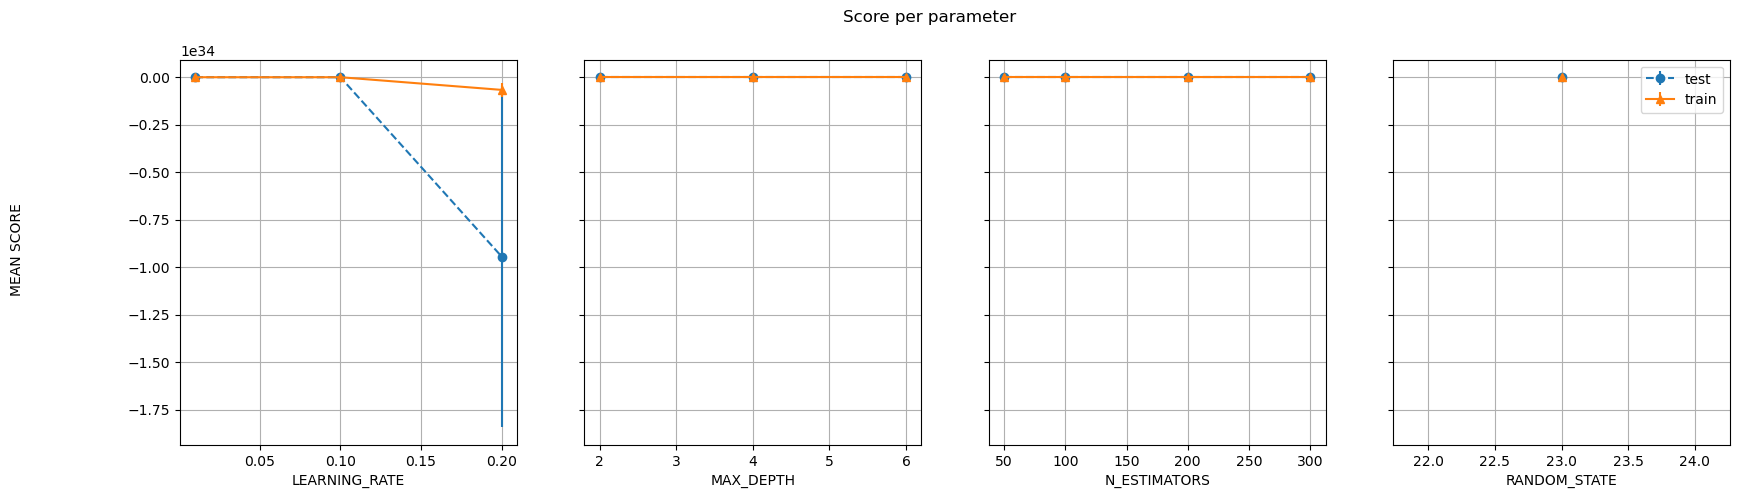

In [33]:
plot_gsearch_results(clf_loaded)

In [34]:

def plot_gsearch_results_mod(grid, learning_rate_threshold=0.3):
    """
    Params: 
        grid: A trained GridSearchCV object.
        learning_rate_threshold: The maximum learning rate to include in the plot.
    """
    # Results from grid search
    results = grid.cv_results_
    means_test = results['mean_test_score']
    stds_test = results['std_test_score']
    means_train = results['mean_train_score']
    stds_train = results['std_train_score']
    
    params_list = results['params']

    # Create a mask to filter out parameter combinations with learning rates > threshold
    learning_rate_mask = [param['learning_rate'] <= learning_rate_threshold for param in params_list]
    
    filtered_means_test = means_test[learning_rate_mask]
    filtered_stds_test = stds_test[learning_rate_mask]
    filtered_means_train = means_train[learning_rate_mask]
    filtered_stds_train = stds_train[learning_rate_mask]
    filtered_params_list = [params_list[i] for i in range(len(params_list)) if learning_rate_mask[i]]

    # Extract the unique values for each parameter to plot
    unique_param_values = {param_name: sorted(set(param_dict[param_name] for param_dict in filtered_params_list))
                           for param_name in grid.param_grid.keys()}

    width = len(grid.param_grid.keys()) * 5

    # Plot results
    fig, ax = plt.subplots(1, len(unique_param_values), sharex='none', sharey='all', figsize=(width, 5))
    fig.suptitle('Score per parameter')
    fig.text(0.04, 0.5, 'MEAN SCORE', va='center', rotation='vertical')

    for i, (param_name, param_values) in enumerate(unique_param_values.items()):
        # For each parameter, extract the means and stds of the scores
        param_results_test = {val: [] for val in param_values}
        param_results_train = {val: [] for val in param_values}
        
        for j, params in enumerate(filtered_params_list):
            param_results_test[params[param_name]].append((filtered_means_test[j], filtered_stds_test[j]))
            param_results_train[params[param_name]].append((filtered_means_train[j], filtered_stds_train[j]))

        # Aggregate the results for plotting
        x = param_values
        y_test = [np.mean([score[0] for score in param_results_test[val]]) for val in x]
        e_test = [np.mean([score[1] for score in param_results_test[val]]) for val in x]
        y_train = [np.mean([score[0] for score in param_results_train[val]]) for val in x]
        e_train = [np.mean([score[1] for score in param_results_train[val]]) for val in x]

        ax[i].errorbar(x, y_test, e_test, linestyle='--', marker='o', label='validation')
        ax[i].errorbar(x, y_train, e_train, linestyle='-', marker='^', label='train')
        ax[i].set_xlabel(param_name.upper())
        ax[i].grid()

    plt.legend()
    plt.show()


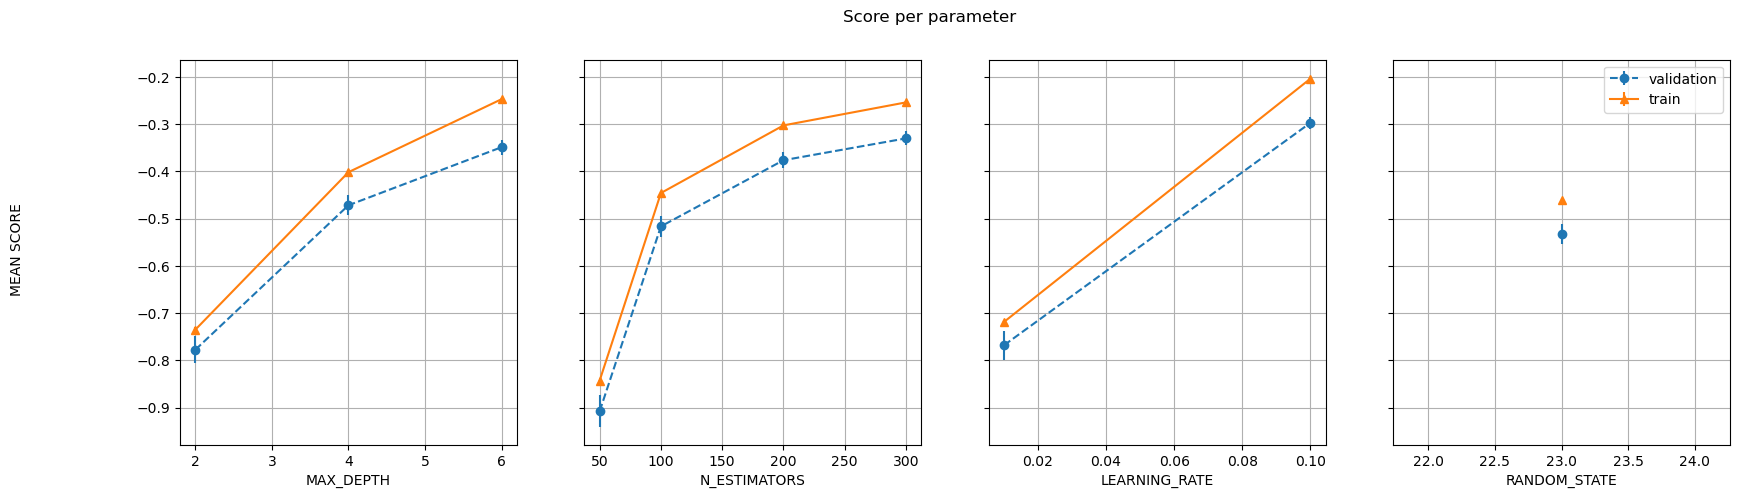

In [35]:
plot_gsearch_results_mod(clf_loaded, learning_rate_threshold=0.1)

In [61]:
# Load best model refit to all training data
best_model = clf_loaded.best_estimator_

In [62]:
best_model

CustomXGBRegressor(base_score=None, booster=None, callbacks=None,
                   colsample_bylevel=None, colsample_bynode=None,
                   colsample_bytree=None, device=None,
                   early_stopping_rounds=None, enable_categorical=False,
                   eval_metric=None, feature_types=None, gamma=None,
                   grow_policy=None, importance_type=None,
                   interaction_constraints=None, learning_rate=0.1,
                   max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
                   max_delta_step=None, max_depth=6, max_leaves=None,
                   min_child_weight=None, missing=nan,
                   monotone_constraints=None, multi_strategy=None,
                   n_estimators=300, n_jobs=None, num_parallel_tree=None,
                   objective=<function CustomXGBRegressor.fit.<locals>.custom_objective at 0x000002B570F05900>, ...)

In [63]:
test_pred = best_model.predict(X_test)

In [64]:
# Get test true values and predictions
y_test_mean, y_test_pred_agg = get_ytrue_y_pred_agg(y_test,test_pred,X_test)

C:\Program Files\Anaconda3\envs\ML_MB_Norway_env\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Program Files\Anaconda3\envs\ML_MB_Norway_env\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


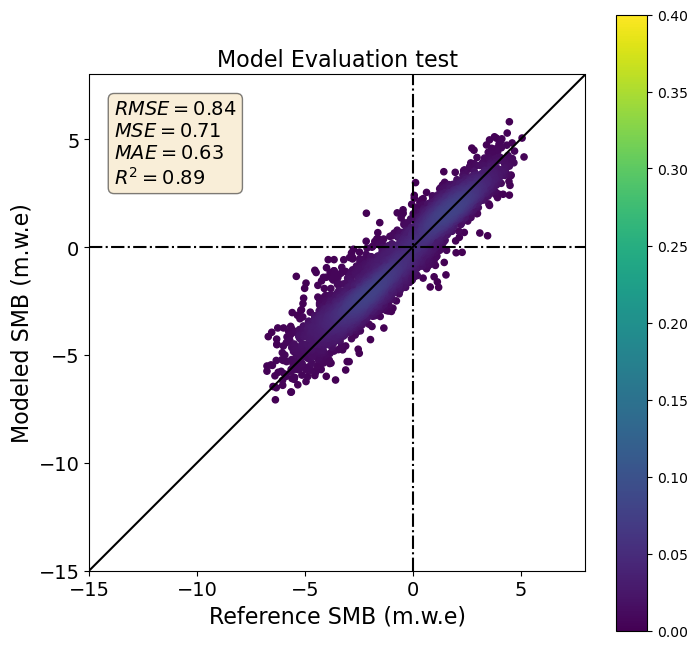

In [65]:
# Plot predictions vs true values for test
plot_prediction(y_test_mean, y_test_pred_agg, data_type='test')

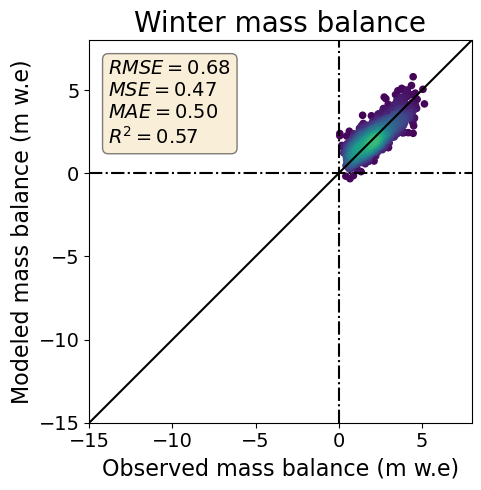

In [67]:
y_test_winter, y_pred_winter = get_prediction_per_season_test(X_test, y_test, best_model, months=7)
winter_indices = X_test[:, -2] == 7
X_test_winter = X_test[winter_indices]
y_test_winter_mean, y_pred_winter_agg = get_ytrue_y_pred_agg_season(y_test_winter, y_pred_winter, X_test_winter, months=7)
plot_prediction_per_season(y_test_winter_mean, y_pred_winter_agg, season='Winter')

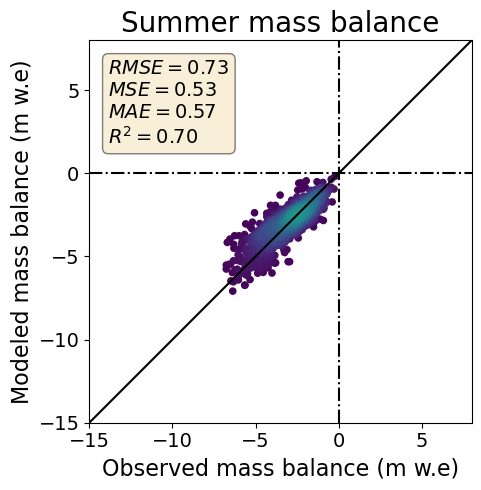

In [68]:
y_test_summer, y_pred_summer = get_prediction_per_season_test(X_test, y_test, best_model, months=5)
summer_indices = X_test[:, -2] == 5
X_test_summer = X_test[summer_indices]
y_test_summer_mean, y_pred_summer_agg = get_ytrue_y_pred_agg_season(y_test_summer, y_pred_summer, X_test_summer, months=5)
plot_prediction_per_season(y_test_summer_mean, y_pred_summer_agg, season='Summer')

In [70]:
y_pred_annual_agg.shape

(1065,)

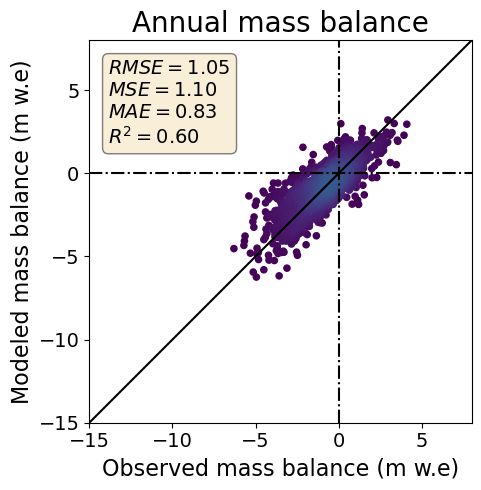

In [69]:
y_test_annual, y_pred_annual = get_prediction_per_season_test(X_test, y_test, best_model, months=12)
annual_indices = X_test[:, -2] == 12
X_test_annual = X_test[annual_indices]
y_test_annual_mean, y_pred_annual_agg = get_ytrue_y_pred_agg_season(y_test_annual, y_pred_annual, X_test_annual, months=12)
plot_prediction_per_season(y_test_annual_mean, y_pred_annual_agg, season='Annual')

## 5.3 Test custom loss updated with more efficient code from Julian 

In [37]:
# Model trained on cluster using up to 0.2 for learning rate. 
# USING UPDATED VERSION OF CustomXGBRegressor from Julian
# Learning rate [0.01, 0.1, 0.2]
# Max depth [2, 4, 6]
# n_estimators [50, 100, 200, 300]
with open('Training_cluster/2024-08-06_10-50-40/custom_loss_cv_grid.pkl', 'rb') as f:
    clf_loaded = pickle.load(f)

In [38]:
clf_loaded.best_estimator_


CustomXGBRegressor(base_score=None, booster=None, callbacks=None,
                   colsample_bylevel=None, colsample_bynode=None,
                   colsample_bytree=None, device=None,
                   early_stopping_rounds=None, enable_categorical=False,
                   eval_metric=None, feature_types=None, gamma=None,
                   grow_policy=None, importance_type=None,
                   interaction_constraints=None, learning_rate=0.1,
                   max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
                   max_delta_step=None, max_depth=6, max_leaves=None,
                   min_child_weight=None, missing=nan,
                   monotone_constraints=None, multi_strategy=None,
                   n_estimators=300, n_jobs=None, num_parallel_tree=None,
                   objective=<function CustomXGBRegressor.fit.<locals>.custom_objective at 0x0000022ED63EE950>, ...)

In [52]:
# Load cv-results
#import joblib
#cv_grid = joblib.load('Models/Custom_loss/2024-06-14_19-29-23/custom_loss_best_model.bin')
#best_model = cv_grid.best_estimator_

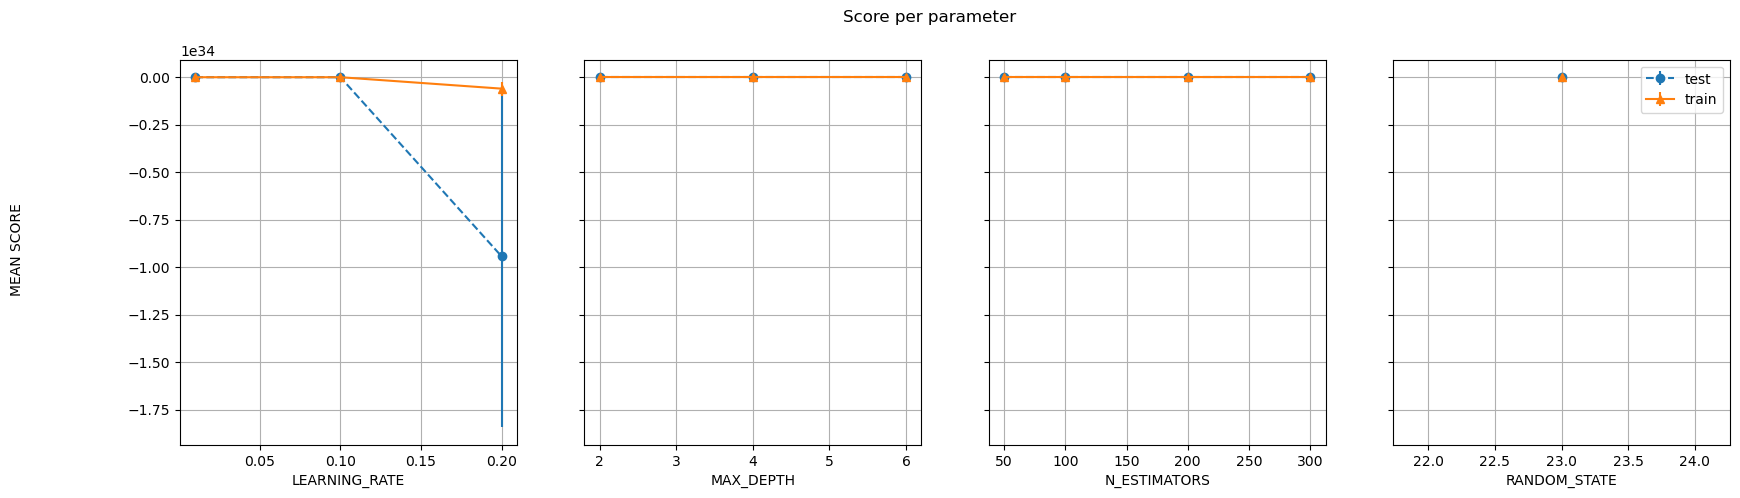

In [39]:
plot_gsearch_results(clf_loaded)

In [40]:

def plot_gsearch_results_mod(grid, learning_rate_threshold=0.3):
    """
    Params: 
        grid: A trained GridSearchCV object.
        learning_rate_threshold: The maximum learning rate to include in the plot.
    """
    # Results from grid search
    results = grid.cv_results_
    means_test = results['mean_test_score']
    stds_test = results['std_test_score']
    means_train = results['mean_train_score']
    stds_train = results['std_train_score']
    
    params_list = results['params']

    # Create a mask to filter out parameter combinations with learning rates > threshold
    learning_rate_mask = [param['learning_rate'] <= learning_rate_threshold for param in params_list]
    
    filtered_means_test = means_test[learning_rate_mask]
    filtered_stds_test = stds_test[learning_rate_mask]
    filtered_means_train = means_train[learning_rate_mask]
    filtered_stds_train = stds_train[learning_rate_mask]
    filtered_params_list = [params_list[i] for i in range(len(params_list)) if learning_rate_mask[i]]

    # Extract the unique values for each parameter to plot
    unique_param_values = {param_name: sorted(set(param_dict[param_name] for param_dict in filtered_params_list))
                           for param_name in grid.param_grid.keys()}

    width = len(grid.param_grid.keys()) * 5

    # Plot results
    fig, ax = plt.subplots(1, len(unique_param_values), sharex='none', sharey='all', figsize=(width, 5))
    fig.suptitle('Score per parameter')
    fig.text(0.04, 0.5, 'MEAN SCORE', va='center', rotation='vertical')

    for i, (param_name, param_values) in enumerate(unique_param_values.items()):
        # For each parameter, extract the means and stds of the scores
        param_results_test = {val: [] for val in param_values}
        param_results_train = {val: [] for val in param_values}
        
        for j, params in enumerate(filtered_params_list):
            param_results_test[params[param_name]].append((filtered_means_test[j], filtered_stds_test[j]))
            param_results_train[params[param_name]].append((filtered_means_train[j], filtered_stds_train[j]))

        # Aggregate the results for plotting
        x = param_values
        y_test = [np.mean([score[0] for score in param_results_test[val]]) for val in x]
        e_test = [np.mean([score[1] for score in param_results_test[val]]) for val in x]
        y_train = [np.mean([score[0] for score in param_results_train[val]]) for val in x]
        e_train = [np.mean([score[1] for score in param_results_train[val]]) for val in x]

        ax[i].errorbar(x, y_test, e_test, linestyle='--', marker='o', label='validation')
        ax[i].errorbar(x, y_train, e_train, linestyle='-', marker='^', label='train')
        ax[i].set_xlabel(param_name.upper())
        ax[i].grid()

    plt.legend()
    plt.show()


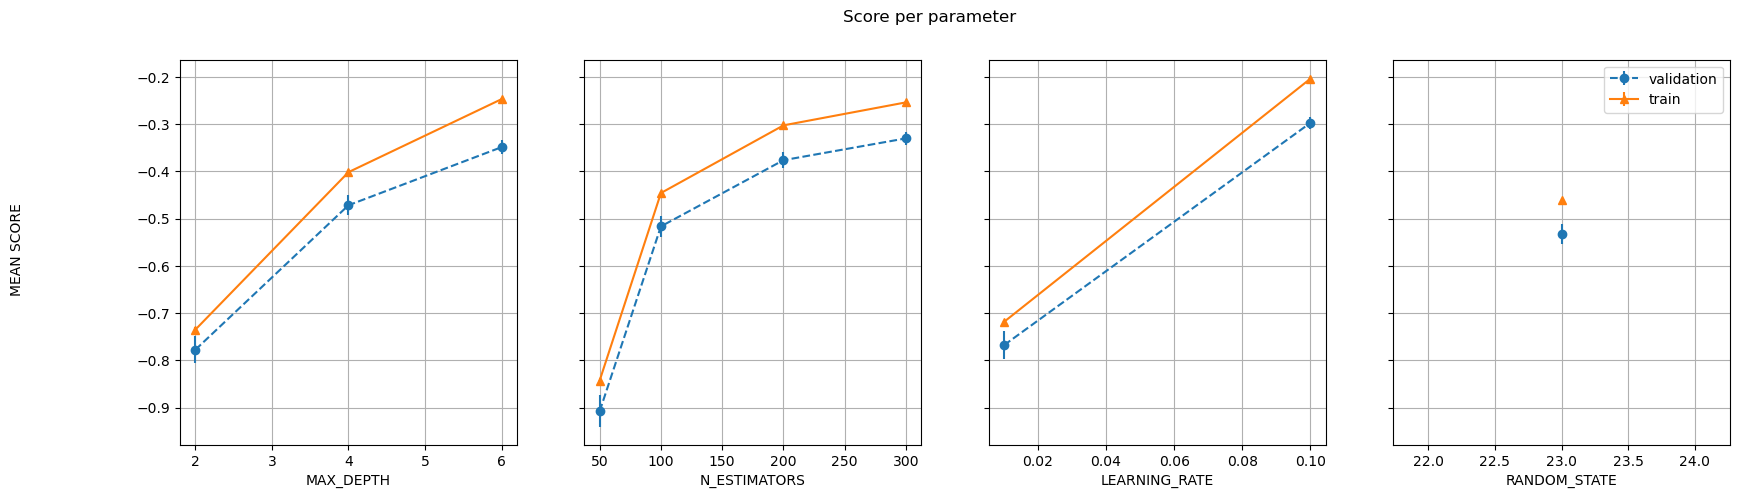

In [41]:
plot_gsearch_results_mod(clf_loaded, learning_rate_threshold=0.1)

In [42]:
# Load best model refit to all training data
best_model = clf_loaded.best_estimator_

In [43]:
best_model

CustomXGBRegressor(base_score=None, booster=None, callbacks=None,
                   colsample_bylevel=None, colsample_bynode=None,
                   colsample_bytree=None, device=None,
                   early_stopping_rounds=None, enable_categorical=False,
                   eval_metric=None, feature_types=None, gamma=None,
                   grow_policy=None, importance_type=None,
                   interaction_constraints=None, learning_rate=0.1,
                   max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
                   max_delta_step=None, max_depth=6, max_leaves=None,
                   min_child_weight=None, missing=nan,
                   monotone_constraints=None, multi_strategy=None,
                   n_estimators=300, n_jobs=None, num_parallel_tree=None,
                   objective=<function CustomXGBRegressor.fit.<locals>.custom_objective at 0x0000022ED63EE950>, ...)

In [44]:
test_pred = best_model.predict(X_test)

In [45]:
# Get test true values and predictions
y_test_mean, y_test_pred_agg = get_ytrue_y_pred_agg(y_test,test_pred,X_test)

C:\Program Files\Anaconda3\envs\ML_MB_Norway_env\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Program Files\Anaconda3\envs\ML_MB_Norway_env\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


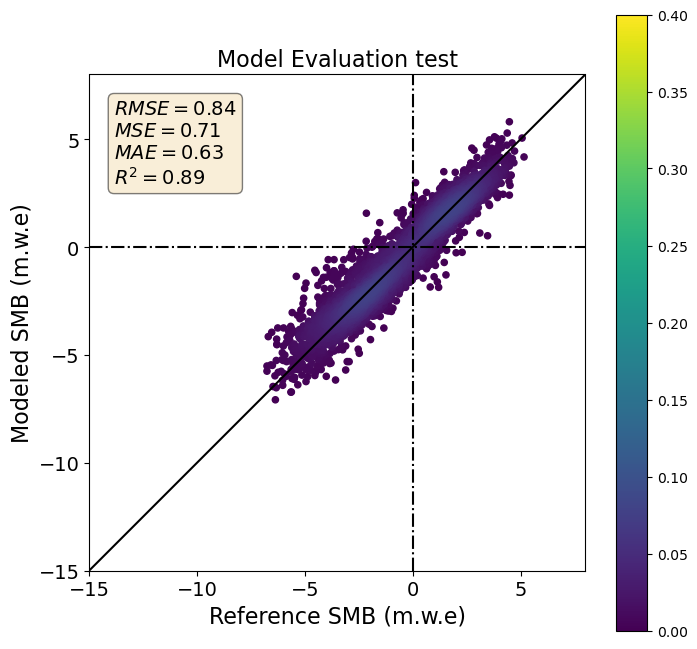

In [46]:
# Plot predictions vs true values for test
plot_prediction(y_test_mean, y_test_pred_agg, data_type='test')

In [37]:
def get_prediction_per_season_test(X_test, y_test, best_model, months=12):

    y_pred = best_model.predict(X_test)

    indices = np.argwhere((X_test[:,-2] == months))[:,0]
    y_test_crop = y_test[indices]
    y_pred_crop = y_pred[indices]

    return y_test_crop, y_pred_crop

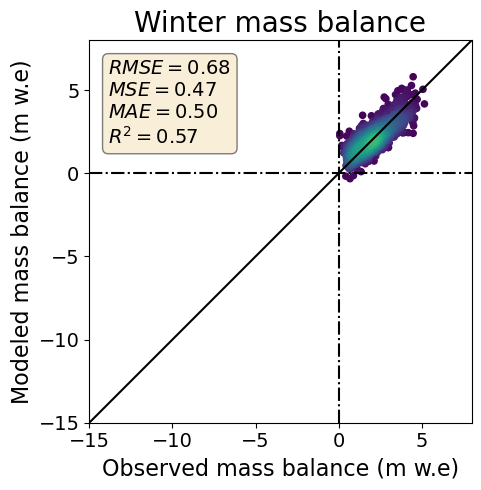

In [48]:
y_test_winter, y_pred_winter = get_prediction_per_season_test(X_test, y_test, best_model, months=7)
winter_indices = X_test[:, -2] == 7
X_test_winter = X_test[winter_indices]
y_test_winter_mean, y_pred_winter_agg = get_ytrue_y_pred_agg_season(y_test_winter, y_pred_winter, X_test_winter, months=7)
plot_prediction_per_season(y_test_winter_mean, y_pred_winter_agg, season='Winter')

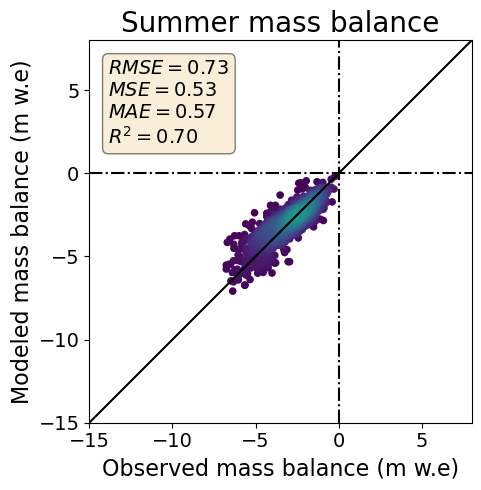

In [49]:
y_test_summer, y_pred_summer = get_prediction_per_season_test(X_test, y_test, best_model, months=5)
summer_indices = X_test[:, -2] == 5
X_test_summer = X_test[summer_indices]
y_test_summer_mean, y_pred_summer_agg = get_ytrue_y_pred_agg_season(y_test_summer, y_pred_summer, X_test_summer, months=5)
plot_prediction_per_season(y_test_summer_mean, y_pred_summer_agg, season='Summer')

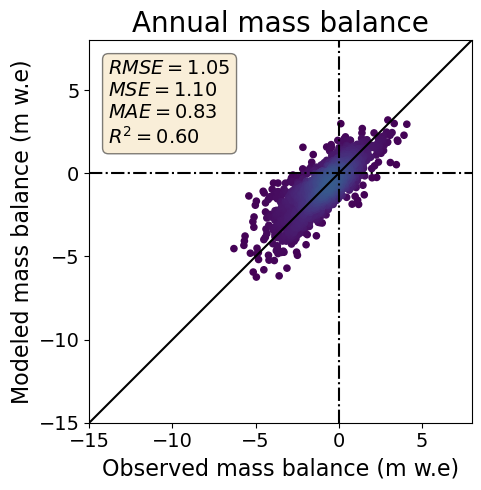

In [51]:
y_test_annual, y_pred_annual = get_prediction_per_season_test(X_test, y_test, best_model, months=12)
annual_indices = X_test[:, -2] == 12
X_test_annual = X_test[annual_indices]
y_test_annual_mean, y_pred_annual_agg = get_ytrue_y_pred_agg_season(y_test_annual, y_pred_annual, X_test_annual, months=12)
plot_prediction_per_season(y_test_annual_mean, y_pred_annual_agg, season='Annual')

## 5.4 Test with ssr_net instead of ssr_down and fal

In [154]:
#best_model = clf_loaded.best_estimator_
#best_model.fit(X_train, y_train)
best_model = CustomXGBRegressor(max_depth=7, learning_rate=0.1, gamma=10, n_estimators=800)
best_model.fit(X_train, y_train)

C:\Program Files\Anaconda3\envs\ML_MB_Norway_env\lib\site-packages\xgboost\core.py:160: UserWarning: [16:28:12] WARNING: D:\bld\xgboost-split_1705650032250\work\src\learner.cc:742: 
Parameters: { "metadata_shape" } are not used.

  warnings.warn(smsg, UserWarning)


CustomXGBRegressor(base_score=None, booster=None, callbacks=None,
                   colsample_bylevel=None, colsample_bynode=None,
                   colsample_bytree=None, device=None,
                   early_stopping_rounds=None, enable_categorical=False,
                   eval_metric=None, feature_types=None, gamma=10,
                   grow_policy=None, importance_type=None,
                   interaction_constraints=None, learning_rate=0.1,
                   max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
                   max_delta_step=None, max_depth=7, max_leaves=None,
                   min_child_weight=None, missing=nan,
                   monotone_constraints=None, multi_strategy=None,
                   n_estimators=800, n_jobs=None, num_parallel_tree=None,
                   objective=<function CustomXGBRegressor.fit.<locals>.custom_objective at 0x000002C38B292680>, ...)

C:\Program Files\Anaconda3\envs\ML_MB_Norway_env\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Program Files\Anaconda3\envs\ML_MB_Norway_env\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


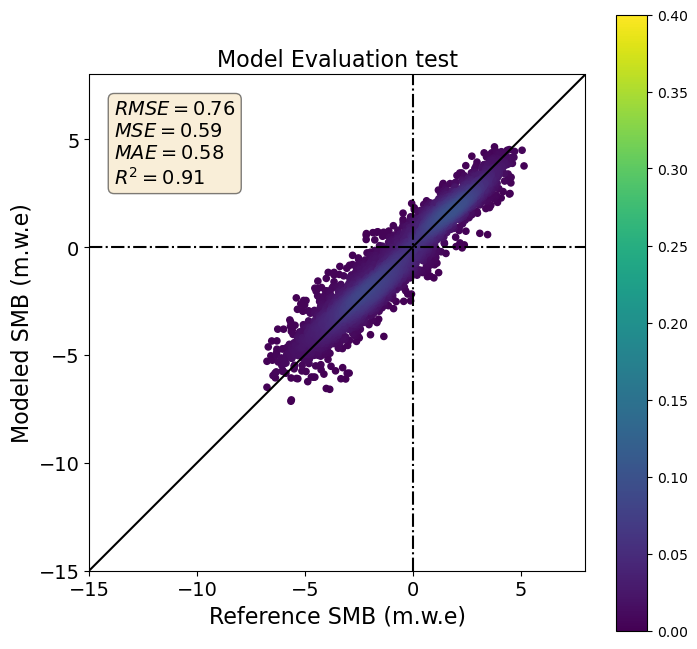

In [155]:
test_pred = best_model.predict(X_test)

# Get test true values and predictions
y_test_mean, y_test_pred_agg = get_ytrue_y_pred_agg(y_test,test_pred,X_test)

# Plot predictions vs true values for test
plot_prediction(y_test_mean, y_test_pred_agg, data_type='test')

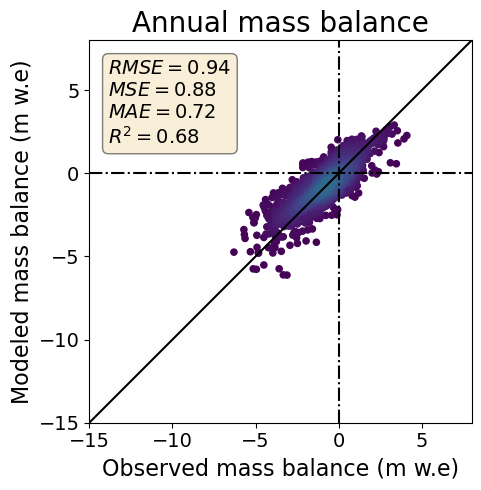

In [156]:
y_test_annual, y_pred_annual = get_prediction_per_season_test(X_test, y_test, best_model, months=12)
annual_indices = X_test[:, -2] == 12
X_test_annual = X_test[annual_indices]
y_test_annual_mean, y_pred_annual_agg = get_ytrue_y_pred_agg_season(y_test_annual, y_pred_annual, X_test_annual, months=12)
plot_prediction_per_season(y_test_annual_mean, y_pred_annual_agg, season='Annual')

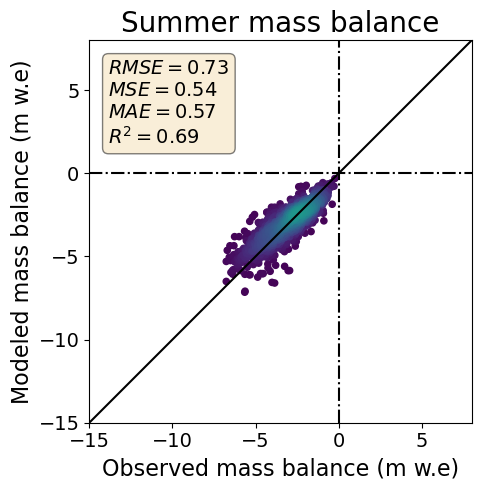

In [157]:
y_test_summer, y_pred_summer = get_prediction_per_season_test(X_test, y_test, best_model, months=5)
summer_indices = X_test[:, -2] == 5
X_test_summer = X_test[summer_indices]
y_test_summer_mean, y_pred_summer_agg = get_ytrue_y_pred_agg_season(y_test_summer, y_pred_summer, X_test_summer, months=5)
plot_prediction_per_season(y_test_summer_mean, y_pred_summer_agg, season='Summer')

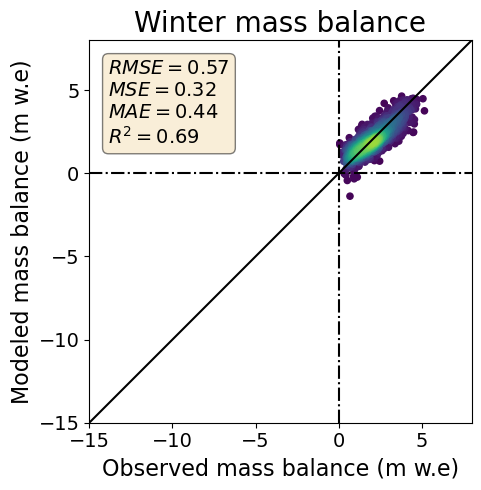

In [158]:
y_test_winter, y_pred_winter = get_prediction_per_season_test(X_test, y_test, best_model, months=7)
winter_indices = X_test[:, -2] == 7
X_test_winter = X_test[winter_indices]
y_test_winter_mean, y_pred_winter_agg = get_ytrue_y_pred_agg_season(y_test_winter, y_pred_winter, X_test_winter, months=7)
plot_prediction_per_season(y_test_winter_mean, y_pred_winter_agg, season='Winter')

## 5.5 Test with only prec and temp

In [196]:
best_model = clf_loaded.best_estimator_
best_model.fit(X_train, y_train)

C:\Program Files\Anaconda3\envs\ML_MB_Norway_env\lib\site-packages\xgboost\core.py:160: UserWarning: [12:01:34] WARNING: D:\bld\xgboost-split_1705650032250\work\src\learner.cc:742: 
Parameters: { "metadata_shape" } are not used.

  warnings.warn(smsg, UserWarning)


CustomXGBRegressor(base_score=None, booster=None, callbacks=None,
                   colsample_bylevel=None, colsample_bynode=None,
                   colsample_bytree=None, device=None,
                   early_stopping_rounds=None, enable_categorical=False,
                   eval_metric=None, feature_types=None, gamma=None,
                   grow_policy=None, importance_type=None,
                   interaction_constraints=None, learning_rate=0.1,
                   max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
                   max_delta_step=None, max_depth=7, max_leaves=None,
                   min_child_weight=None, missing=nan,
                   monotone_constraints=None, multi_strategy=None,
                   n_estimators=700, n_jobs=None, num_parallel_tree=None,
                   objective=<function CustomXGBRegressor.fit.<locals>.custom_objective at 0x0000024F61E751B0>, ...)

C:\Program Files\Anaconda3\envs\ML_MB_Norway_env\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Program Files\Anaconda3\envs\ML_MB_Norway_env\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


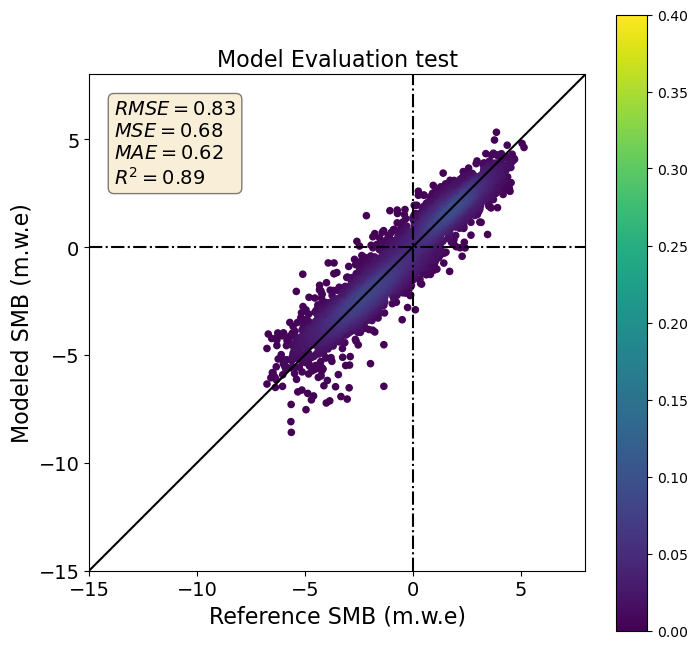

In [199]:
test_pred = best_model.predict(X_test)

# Get test true values and predictions
y_test_mean, y_test_pred_agg = get_ytrue_y_pred_agg(y_test,test_pred,X_test)

# Plot predictions vs true values for test
plot_prediction(y_test_mean, y_test_pred_agg, data_type='test')

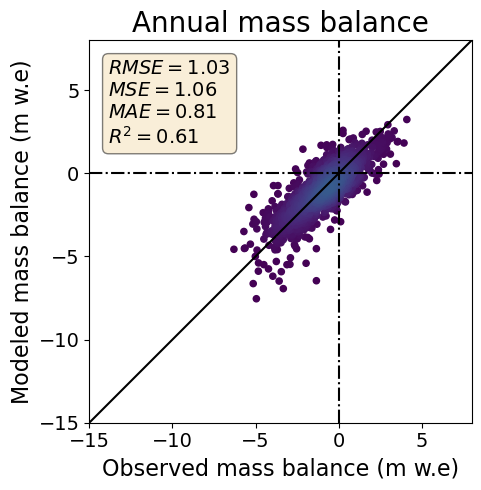

In [200]:
y_test_annual, y_pred_annual = get_prediction_per_season_test(X_test, y_test, best_model, months=12)
annual_indices = X_test[:, -2] == 12
X_test_annual = X_test[annual_indices]
y_test_annual_mean, y_pred_annual_agg = get_ytrue_y_pred_agg_season(y_test_annual, y_pred_annual, X_test_annual, months=12)
plot_prediction_per_season(y_test_annual_mean, y_pred_annual_agg, season='Annual')

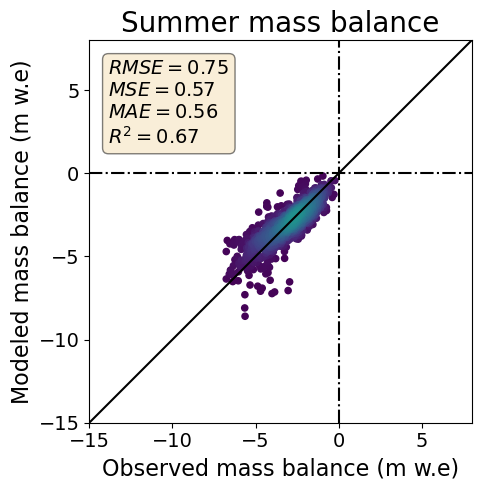

In [201]:
y_test_summer, y_pred_summer = get_prediction_per_season_test(X_test, y_test, best_model, months=5)
summer_indices = X_test[:, -2] == 5
X_test_summer = X_test[summer_indices]
y_test_summer_mean, y_pred_summer_agg = get_ytrue_y_pred_agg_season(y_test_summer, y_pred_summer, X_test_summer, months=5)
plot_prediction_per_season(y_test_summer_mean, y_pred_summer_agg, season='Summer')

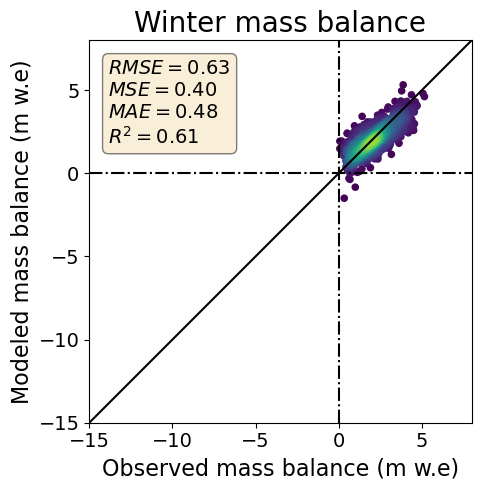

In [202]:
y_test_winter, y_pred_winter = get_prediction_per_season_test(X_test, y_test, best_model, months=7)
winter_indices = X_test[:, -2] == 7
X_test_winter = X_test[winter_indices]
y_test_winter_mean, y_pred_winter_agg = get_ytrue_y_pred_agg_season(y_test_winter, y_pred_winter, X_test_winter, months=7)
plot_prediction_per_season(y_test_winter_mean, y_pred_winter_agg, season='Winter')

# 6 Test

In [63]:
# Make predictions on test data
test_pred = xgb_model.predict(X_test)

In [64]:
# Get test true values and predictions
y_test_mean, y_test_pred_agg = get_ytrue_y_pred_agg(y_test,test_pred,X_test)

C:\Program Files\Anaconda3\envs\ML_MB_Norway_env\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Program Files\Anaconda3\envs\ML_MB_Norway_env\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


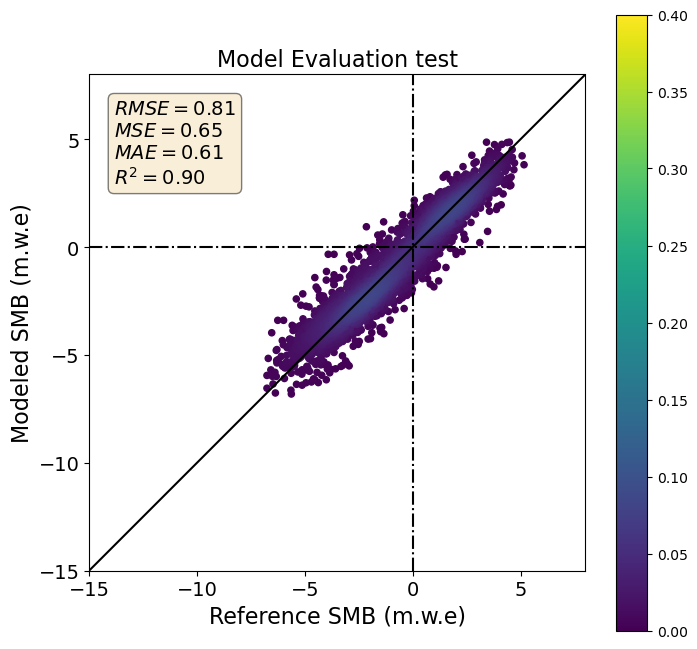

In [65]:
# Plot predictions vs true values for test
plot_prediction(y_test_mean, y_test_pred_agg, data_type='test')

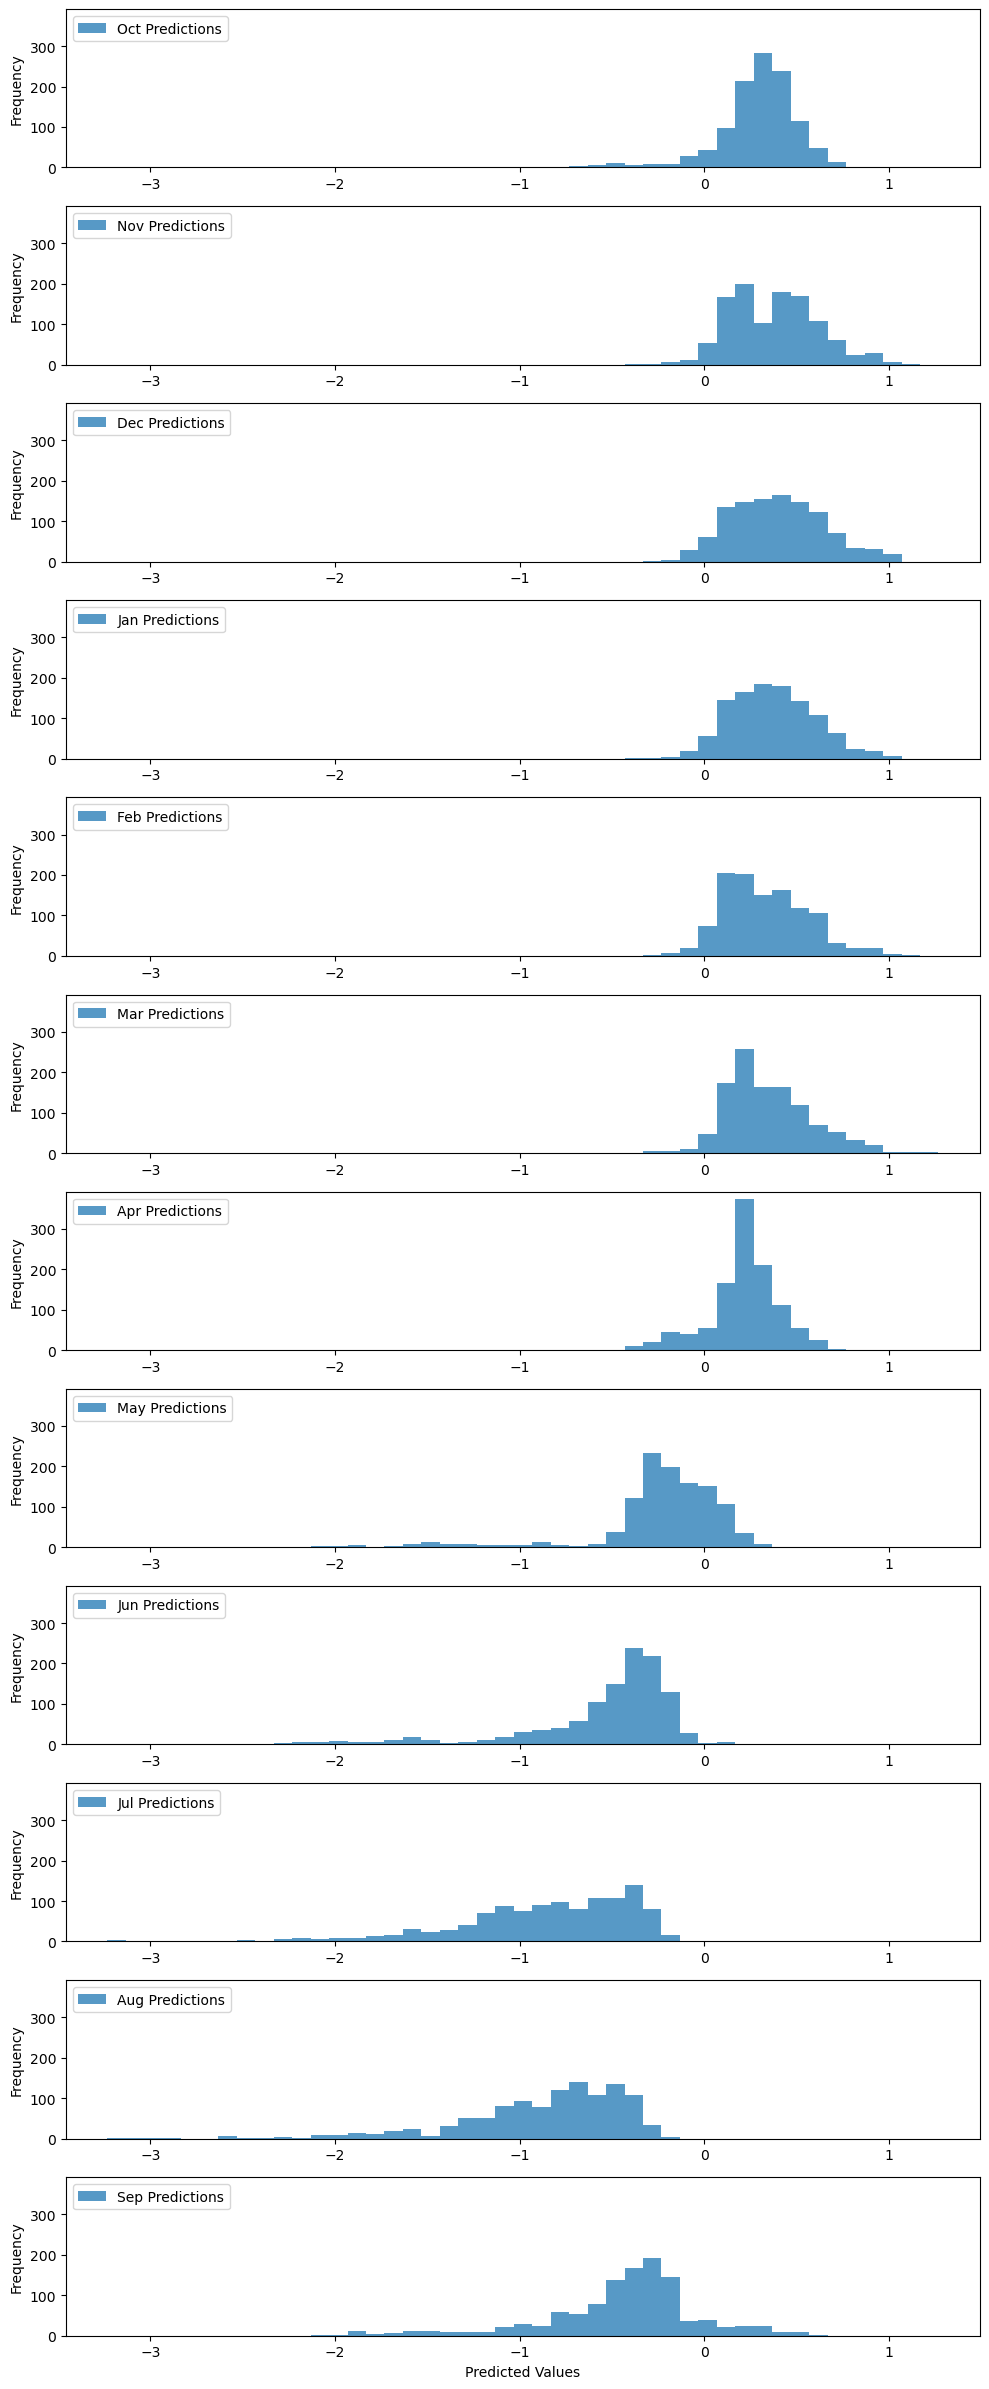

In [56]:
# Plot predicted mass balance distribution for each month

import matplotlib.pyplot as plt

months = X_val_crop[:,-1]

# Define the month order
month_order = ['oct', 'nov', 'dec', 'jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep']

bin_width = 0.1 

min_pred = predictions.min()
max_pred = predictions.max()

# Create bins with the specified width from the global min to max prediction
bins = np.arange(min_pred, max_pred + bin_width, bin_width)

fig, ax = plt.subplots(len(month_order), 1, figsize=(10, 2*len(month_order)), sharex = True, sharey=True)

for i, month in enumerate(month_order):
    month_predictions = predictions[months == month]
    
    ax[i].hist(month_predictions, bins=bins, alpha=0.75, label=f'{month.capitalize()} Predictions')

    ax[i].xaxis.set_tick_params(which='both', labelbottom=True)
    
    ax[i].set_ylabel('Frequency')
    ax[i].legend(loc='upper left')

ax[-1].set_xlabel('Predicted Values')

plt.tight_layout()

plt.show()

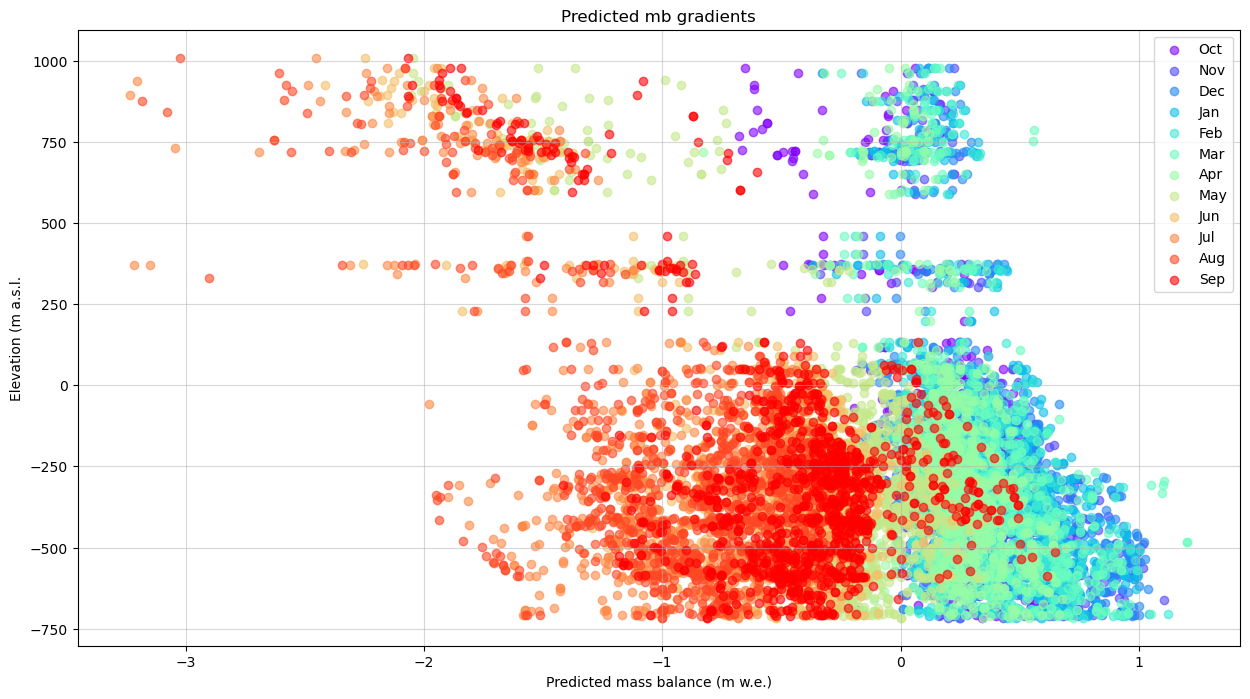

In [57]:
# Plot predicted mass balance gradient for each month

import matplotlib.pyplot as plt

months = X_val_crop[:,-1]
elevation = X_val_crop[:,0]

# Define month order
month_order = ['oct', 'nov', 'dec', 'jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep']
colors = plt.cm.rainbow(np.linspace(0, 1, len(month_order)))

# Map month to color
month_to_color = dict(zip(month_order, colors))

fig, ax = plt.subplots(figsize=(15, 8))

for month in month_order:
    idx = months == month
    ax.scatter(predictions[idx], elevation[idx], label=month.capitalize(), alpha=0.6, c=[month_to_color[month]])

ax.set_xlabel('Predicted mass balance (m w.e.)')
ax.set_ylabel('Elevation (m a.s.l.')
ax.set_title('Predicted mb gradients')
ax.legend()

plt.grid(alpha=0.5)
plt.show()